# Construisez un modèle de scoring

# Prêt à dépenser

<img src="logo_pret_a_depenser.png" alt="logo_pret_a_depenser" width="300"/>

# Sommaire

* [Problématique de l'entreprise](#1)
* [Imports de librairies](#2)
* [Import des datasets brutes](#3)
* [Première exploration, pour améliorer nos datasets](#4)
    * [Describe](#41)
    * [Valeurs reflétant une absence d'information](#42)
    * [Amender `HomeCredit_columns_description.csv` avec des informations utiles](#43)
    * [Stocker ces informations](#44)
    * [Versions optimisées des datasets](#45)
* [Exploration, seconde partie - TARGET](#5)
* [Créer de nouvelles features dans `application_train.csv`](#6)
* [Unifier les datasets](#7)
    * [Unifier les datasets - Comment ?](#71)
    * [Unifier les datasets - Encodage des features catégorielles avant aggrégation](#72)
    * [Unifier les datasets - Création de quelques features, avant aggrégations](#73)
    * [Unifier les datasets - Agrégation `bureau_balance.csv` & Merge avec `bureau.csv`](#74)
    * [Unifier les datasets - Agrégations des `xxx.csv` & Merge avec `application_train.csv`](#75)
    * [Unifier les datasets - bilan](#76)
* [Méthode d'évaluation](#8)
    * [Approche coût métier](#81)
    * [Choix de la métrique d'évaluation](#82)
    * [Optimisation du modèle final](#83)
* [Création des jeux d'entraînement et de test](#9)
* [Gérer la multicolinéarité](#10)
* [Création des pipelines de preprocessing...](#11)
    * [... pour les features numériques](#111)
    * [... pour les features nominales avec beaucoup de catégories](#112)
    * [... pour les features nominales](#113)
    * [... pour les features ordinales](#114)
* [Création du `column transformer`](#12)
* [Création des `samplers`](#13)
* [Outil(s) de feature selection](#14)
    * [Outil(s) de feature selection - méthode](#141)
    * [Outil(s) de feature selection - `VarianceSelector`](#142)
    * [Outil(s) de feature selection - `FscoreSelector`](#143)
    * [Outil(s) de feature selection - `RFESelector`](#144)
    * [Outil(s) de feature selection - Test](#145)
* [MODELES : méthodologie](#15)
* [MODELES : modèle de référence naïf - `dummy`](#16)
* [MODELES : `Random Forest`](#17)
* [MODELES : `Logistic Regression`](#18)
* [MODELES : `LightGBM`](#19)
* [MODELE CHOISI - Essai sur le Test set](#20)
* [MODELE CHOISI - et sans les features composites ?](#21)
* [MODELE CHOISI - sélectionner un seuil basé sur notre hypothèse business](#22)
* [MODELE CHOISI - faire des prédictions](#23)
* [MODELE CHOISI - expliquer nos prédictions](#24)
    * [Préambule](#241)
    * [`shap.plots.bar`](#242)
    * [`shap.decision_plot`](#243)
    * [`shap.plots.waterfall`](#244)

# Problématique de l'entreprise<a class="anchor" id="1"></a>

"Prêt à dépenser" propose des crédits à la consommation pour les particuliers. La cible commerciale de l'entreprise sont les personnes n'ayant pas ou peu d'historique de prêt.

Afin d'éviter des pertes importantes, l'entreprise souhaite mettre en oeuvre un outil d'évalutation du risque de crédit associé à un prospect avant une éventuelle signature.

Cet outil prendra la forme d'un "scoring crédit" et :
- calculera la probabilité de défaut du prospect
- classifiera la demande de prêt : "crédit accordé" ou "crédit refusé"

# Imports de librairies<a class="anchor" id="2"></a>

In [1]:
import time
start_time = time.time()

In [196]:
import pandas as pd # to manipulate the dataset with dataframes
import numpy as np # for statistics and calculations

import matplotlib.pyplot as plt # for data visualisation
%matplotlib inline
import matplotlib.ticker as mtick # for format axis in percent %
from matplotlib.patches import Patch # for custom legends
import seaborn as sns # for data visualisation, with different proporties

# from math import floor

import ipywidgets as widgets # for interactive plots

import os # for folders management
import sys # for memory management
import gc # for memory management

In [3]:
from sklearn.model_selection import train_test_split # to create train and test sets

from sklearn.preprocessing import OneHotEncoder,TargetEncoder,OrdinalEncoder # for encoding categorical features
from sklearn.preprocessing import StandardScaler,RobustScaler # for scaling numerical features

from sklearn.impute import SimpleImputer # imputers

from sklearn.pipeline import Pipeline as sklPipeline # to make pipeline
from sklearn.compose import ColumnTransformer # to handle features preprocessing

from imblearn.over_sampling import SMOTE # SMOTE over sampler (based on nearest neighbors)
from imblearn.under_sampling import RandomUnderSampler # random under sampler

from sklearn.feature_selection import RFECV # for main feature selection
from sklearn.feature_selection import VarianceThreshold,SelectPercentile,f_classif # for pre feature selection

from imblearn.pipeline import Pipeline as imbPipeline # imblearn pipeline (to ignore sampler when using .predit)

from sklearn.model_selection import StratifiedKFold # to create train/validation sets for cross validation
from sklearn.model_selection import GridSearchCV # for hyperparameters tuning
from sklearn.model_selection import cross_val_predict # for out of folds scores
from skopt import BayesSearchCV # for grid search using bayesian optimisation

# models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.base import clone # to create copies of model

from sklearn.metrics import average_precision_score,precision_score,recall_score # metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay # confusion matrix

from joblib import dump,load # to make saves

import shap # for ML interpretability

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
import myFunctions as mf # for using custom functions

# Options du notebook & sauvegardes<a class="anchor" id="options"></a>

Afin de réduire le temps d'exécution lors du développement du projet, nous avons utilisé les fonctions `dump` et `load` de `joblib`. 
Les enregistrements sont inclus dans le dossier `/mySaves`.

**Le notebook n'a pas besoin de ce dossier pour fonctionner**. Le temps d'exécution sera en revanche **plus long** lors de la première exécution.

L'option `rapidProcessing` peut être désactivée pour ignorer les sauvegardes (ou les recréer après des modifications par exemple).

In [5]:
# bools for notebook options
rapidProcessing = True 
# if true : use ".joblib"s  saved in /mySaves folder to speed up processing

Le projet comporte plusieurs `.csv` que nous avons utilisés et modelés (pour réduire l'espace mémoire, pour l'encodage, pour les agrégats, etc.). Afin de réduire l'espace mémoire, nous effaçons au fur et à mesure les dataframes inutilisés.

La désactivation des options suivantes permet de les conserver :

In [6]:
# bools, wether or not delete memory consuming dataframes
deleteRawDfs = False
deleteLowMemDfs = False
deleteLastNxx_dfs = False
deleteEncodedDfs = False

Une dernière option pour imprimer ou non le nom des features rajoutées au dataset principal `application_train.csv` :

In [7]:
printNewFeatures = True

# Import des datasets brutes<a class="anchor" id="3"></a>

In [8]:
os.listdir("Projet+Mise+en+prod+-+home-credit-default-risk")

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [9]:
if os.path.isdir("Projet+Mise+en+prod+-+home-credit-default-risk") :
    rawCsvNames=os.listdir("Projet+Mise+en+prod+-+home-credit-default-risk")
    rawCsvNames.remove('application_test.csv')
#     rawCsvNames.remove('HomeCredit_columns_description.csv')
    rawCsvNames.remove('sample_submission.csv')
    rawDfNames=[
        "rawAppliDf",
        "rawBurDf",
        "rawBurBalDf",
        "rawCcBalDf",
        "rawColDescripDf",
        "rawInstalPaymDf",
        "rawPosDf",
        "rawPrevAppDf"
    ]
    rawDfDict={}

    for dfName,csvName in zip(rawDfNames,rawCsvNames) :
        vars()[dfName]=pd.read_csv(
            "Projet+Mise+en+prod+-+home-credit-default-risk/"+csvName,
            encoding_errors="ignore"
        )
        rawDfDict[dfName]=vars()[dfName]
else : 
    print("attention le dossier de base contenant les .csv du projet n'est pas présent")

In [10]:
realRawDfNames=[ # create a list of the dataframes based on "real" datasets
    "rawAppliDf",
    "rawBurDf",
    "rawBurBalDf",
    "rawCcBalDf",
    "rawInstalPaymDf",
    "rawPosDf",
    "rawPrevAppDf"
]

realRawCsvNames=[ # same list but with corresponding csv files names
     'application_train.csv',
     'bureau.csv',
     'bureau_balance.csv',
     'credit_card_balance.csv',
     'installments_payments.csv',
     'POS_CASH_balance.csv',
     'previous_application.csv'
]

# Première exploration, pour améliorer nos datasets<a class="anchor" id="4"></a>

Nous allons dans un premier temps regarder nos jeux de données à l'aide la méthode .describe() pour nous intéresser :
- au nombre de valeurs uniques (pour les features catégorielles)
- aux valeurs min, max

L'objectif étant de détecter facilement d'éventuelles incohérences.

## Describe<a class="anchor" id="41"></a>

In [11]:
# custom .Describe
mf.myDescribe(rawDfDict)

Dropdown(description='Which dataframe :', options=('rawAppliDf', 'rawBurDf', 'rawBurBalDf', 'rawCcBalDf', 'raw…

Output()

Ce que l'on peut en retenir :
- la colonne `TARGET` est **déséquilibrée**. En effet, ce qui est assez logique, il y a peu (8%) de clients avec des défaut de paiement.
- pour certaines features `DAYS...` nous renseignant sur un nombre de jours, le **maximum est la valeur `365243`, ce qui est incohérent**. Cette valeur représente surement $\infty$.
    *(exemple : dataframe `rawAppliDf` - feature `DAYS_EMPLOYED`)*
    

- certaines features qualitatives ne semblent comporter que **2 valeurs uniques**. Celles-ci pourraient être transformées en features numériques avec les valeurs 0 ou 1.
    *(exemple : dataframe `rawAppliDf` - feature `FLAG_OWN_CAR`)*

- sur le même principe, certaines features ont 3 valeurs uniques là il serait plus logique qu'elles en aient 2. la **troisième valeur pourrait refléter une absence d'information**, et donc passée en valeur manquante.
    *(exemple : dataframe `rawAppliDf` - feature `CODE_GENDER`)*
    
- certaines features ont un **taux de valeurs manquantes très élevé**.
    *(exemple : dataframe `rawPrevAppDf` - feature `RATE_INTEREST_PRIMARY` : 99.6%)*
    
- certaines features ont des **problèmes d'outliers** *(notamment dans `rawBurDf`)*

## Valeurs reflétant une absence d'information<a class="anchor" id="42"></a>

Recherchons les valeurs représentant une "absence d'information" :

In [12]:
# # print qualitative unique values to find values that can be replace with NaN
# for dfName in realRawDfNames :
#     print(dfName)
#     print("-------------")
#     df=vars()[dfName].copy()
#     test=pd.Series(df.apply(lambda s : s.unique().tolist() \
#                                                            if ((s.dtype=="O")) \
#                                     else np.nan,axis=0

#                                                           ))
#     for i,v in test.items() :
#         print(i,":",v)
#     print("-------------")
#     del test, df
#     gc.collect()

Les valeurs : `"XNA"`,  `'Unknown'`, `'not specified'`, `'Unknown type of loan'`, `'X'` peuvent être considérées comme des valeurs manquantes.

## Amender `HomeCredit_columns_description.csv` avec des informations utiles<a class="anchor" id="43"></a>

In [13]:
rawColDescripDf.shape

(219, 5)

Il y a apparemment 219 features dans les différents datasets à notre disposition. 

Nous pouvons nous appuyer sur ce tableau `HomeCredit_columns_description.csv` pour notre exploration : Nous allons ajouter différentes colonnes avec des informations importantes :
- le **type**
- le type qui serait le plus approprié en terme d'**espace mémoire**
- le taux de **valeurs manquantes**
- les **valeurs uniques**
- les valeurs que nous considérerons **comme des valeurs manquantes** (comme vu précédemment)
- les colonnes qui n'ont **que 2 valeurs uniques**.

In [14]:
if not os.path.isdir("mySaves") :
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/myDataFrames") :
    os.mkdir("mySaves/myDataFrames")
if not os.path.isdir("mySaves/myDataFrames/columnsDescription") :
    os.mkdir("mySaves/myDataFrames/columnsDescription")

In [15]:
%%time
# add informations in the columns description dataframe

if ("proColDescripDf.joblib" not in os.listdir("mySaves/myDataFrames/columnsDescription")) or (rapidProcessing==False) :
    proColDescripDf = rawColDescripDf.copy() # create copy


   
    # change "application_{train|test}.csv" for 'application_train.csv' in the columns description df : proColDescripDf
    proColDescripDf.loc[proColDescripDf["Table"]=="application_{train|test}.csv","Table"] \
    = 'application_train.csv'
    # correct proColDescripDf issues
    proColDescripDf=proColDescripDf.drop(columns="Unnamed: 0")
    proColDescripDf["Row"]=proColDescripDf["Row"].str.strip()
    proColDescripDf.loc[proColDescripDf["Row"]=="SK_BUREAU_ID","Row"]="SK_ID_BUREAU"
    proColDescripDf=proColDescripDf.loc[proColDescripDf["Row"]!="NFLAG_MICRO_CASH"]

    # create columns with informations


    for dfName,csvName in zip(realRawDfNames,realRawCsvNames) :  # iterate on dataframes and their csv files
        df=vars()[dfName].copy()
        mask = ( # in the columns description dataframe, filter on csvName and df's columns
            (proColDescripDf["Table"]==csvName)&
            (proColDescripDf["Row"].isin(df.columns))
        )
#         print(    proColDescripDf.loc[mask,"Row"].tolist()==df.columns.tolist()    )
        
        # TYPES
        
        # get columns dtypes
        proColDescripDf.loc[mask,"type"]=df.dtypes.values.tolist()
        
        # lowest memory consumming dtype, using a function from myFunctions
        proColDescripDf.loc[mask,"bestType"] = proColDescripDf.loc[mask].apply(lambda r : mf.bestDtype(df[r["Row"]]), axis=1)
                        
        # get percentage of missing values
        proColDescripDf.loc[mask,"NaN_rate"]=(df.isna().mean(axis=0)).values.tolist()

        # get unique values
        proColDescripDf.loc[mask,"Uniques"]=pd.Series(df.apply(lambda s : s.dropna().unique().tolist() \
                                                               if s.dtype=="O"
                                                               else np.nan,
                                                               axis=0
                                                      )).values

        # for concerned columns, add the new NaN value 365243 in a list 
        mask2 = (proColDescripDf["type"]=='int64')|(proColDescripDf["type"]=='float64')
        
        
        proColDescripDf.loc[mask&mask2,"otherNanValues"]=pd.Series(df.select_dtypes(['int64', 'float64'])\
                                                                    .apply(lambda s : 365243
                                                                              if s.max()==365243
                                                                              else np.nan,
                                                                              axis=0)).values
        
        
        
        del df,mask,mask2
        gc.collect()

    # list of new NaN values if columns have "XNA",  'Unknown', 'not specified', 'Unknown type of loan', 'X' within their values
    nanValuesList=["XNA",  'Unknown', 'not specified', 'Unknown type of loan','X']
    nanValuesList.append("XAP") # add "XAP"
    
    mask = proColDescripDf["otherNanValues"].isna()
    proColDescripDf.loc[mask,"otherNanValues"]=proColDescripDf.loc[mask,"Uniques"]\
    .apply(lambda lst : [nanVal for nanVal in nanValuesList if nanVal in lst] \
           if type(lst)==list
           else np.nan)\
    .apply(lambda lst : lst if (type(lst)==list and len(lst)>0) else np.nan)

    # true or false - columns have only 2 unique values
    proColDescripDf["bin"]=(
        proColDescripDf["Uniques"].apply(lambda l : len(l) if type(l)==list else np.nan) \
        - proColDescripDf["otherNanValues"].apply(lambda l : len(l) if type(l)==list else 0)
    )==2
    # store both values
    proColDescripDf.loc[(proColDescripDf["bin"]==True)&(proColDescripDf["otherNanValues"].isna()),"binValues"] = \
    proColDescripDf.loc[(proColDescripDf["bin"]==True)&(proColDescripDf["otherNanValues"].isna()),"Uniques"]
    
    
    proColDescripDf.loc[(proColDescripDf["bin"]==True)&(proColDescripDf["otherNanValues"].notna()),"binValues"] = \
    proColDescripDf.loc[(proColDescripDf["bin"]==True)&(proColDescripDf["otherNanValues"].notna()),["Uniques","otherNanValues"]]\
    .apply(lambda r : [elt for elt in r["Uniques"] if elt not in r["otherNanValues"]],
                                                axis=1)
    
    
    dump(proColDescripDf,"mySaves/myDataFrames/columnsDescription/proColDescripDf.joblib")

else :
    proColDescripDf=load("mySaves/myDataFrames/columnsDescription/proColDescripDf.joblib")
    
display(proColDescripDf)

,Table,Row,Description,Special,type,bestType,NaN_rate,Uniques,otherNanValues,bin,binValues
0,application_train.csv,SK_ID_CURR,ID of loan in our sample,NaN,int64,uint32,0.000000,NaN,NaN,False,NaN
1,application_train.csv,TARGET,Target variable (1 - client with payment diffi...,NaN,int64,uint8,0.000000,NaN,NaN,False,NaN
2,application_train.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN,object,category,0.000000,"[Cash loans, Revolving loans]",NaN,True,"[Cash loans, Revolving loans]"
3,application_train.csv,CODE_GENDER,Gender of the client,NaN,object,category,0.000000,"[M, F, XNA]",[XNA],True,"[M, F]"
4,application_train.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN,object,category,0.000000,"[N, Y]",NaN,True,"[N, Y]"
...,...,...,...,...,...,...,...,...,...,...,...
214,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN,int64,uint16,0.000000,NaN,NaN,False,NaN
215,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application,float64,int16,0.000000,NaN,NaN,False,NaN
216,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application,float64,float32,0.000214,NaN,NaN,False,NaN
217,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN,float64,float64,0.000000,NaN,NaN,False,NaN


CPU times: total: 0 ns
Wall time: 16.3 ms


## Stocker ces informations<a class="anchor" id="44"></a>

Nous allons utiliser le fruit du travail effectué sur `proColDescripDf` pour créer différents dictionnaires que nous pourrons utiliser plus tard pour améliorer nos datasets :

Nous pouvons tout d'abord stocker le `dtype` qui optimise l'espace mémoire, pour chaque colonne.

In [16]:
# dictionnary for dtypes
lowMemTypesDict = {
                    csvName : {
                                col : bestTyp for col,bestTyp in zip(
                                    proColDescripDf.loc[proColDescripDf["Table"]==csvName,"Row"].values.tolist(),
                                    proColDescripDf.loc[proColDescripDf["Table"]==csvName,"bestType"].values.tolist()
                                                                    )
                         

}
               for csvName in realRawCsvNames}



Les valeurs que nous supprimerons (car considérées comme valeurs manquantes) :

In [17]:
# dictionnary for categorical columns nan values


catNanValuesDict = {
                    csvName : {
                                col : nanLst for col,nanLst in zip(
                                    
                                    proColDescripDf.loc[
                                        (
                                            (proColDescripDf["Table"]==csvName)&
                                            (proColDescripDf["otherNanValues"].notna())&
                                            (proColDescripDf["otherNanValues"]!=365243)
                                    ),
                                        "Row"].values.tolist(),
                                    
                                    proColDescripDf.loc[(
                                            (proColDescripDf["Table"]==csvName)&
                                            (proColDescripDf["otherNanValues"].notna())&
                                            (proColDescripDf["otherNanValues"]!=365243)
                                    ),
                                        "otherNanValues"].values.tolist()
                                )
                    }
    for csvName in realRawCsvNames
}



In [18]:
catNanValuesDict

{'application_train.csv': {'CODE_GENDER': ['XNA'],
  'NAME_FAMILY_STATUS': ['Unknown'],
  'ORGANIZATION_TYPE': ['XNA'],
  'FONDKAPREMONT_MODE': ['not specified']},
 'bureau.csv': {'CREDIT_TYPE': ['Unknown type of loan']},
 'bureau_balance.csv': {'STATUS': ['X']},
 'credit_card_balance.csv': {},
 'installments_payments.csv': {},
 'POS_CASH_balance.csv': {'NAME_CONTRACT_STATUS': ['XNA']},
 'previous_application.csv': {'NAME_CONTRACT_TYPE': ['XNA'],
  'NAME_CASH_LOAN_PURPOSE': ['XNA', 'XAP'],
  'NAME_PAYMENT_TYPE': ['XNA'],
  'CODE_REJECT_REASON': ['XNA', 'XAP'],
  'NAME_CLIENT_TYPE': ['XNA'],
  'NAME_GOODS_CATEGORY': ['XNA'],
  'NAME_PORTFOLIO': ['XNA'],
  'NAME_PRODUCT_TYPE': ['XNA'],
  'NAME_SELLER_INDUSTRY': ['XNA'],
  'NAME_YIELD_GROUP': ['XNA']}}

In [19]:
# dictionnary for numerical columns nan values


numNanValuesDict = {
                    csvName : {
                                col : nanLst for col,nanLst in zip(
                                    
                                    proColDescripDf.loc[
                                        (
                                            (proColDescripDf["Table"]==csvName)&
                                            (proColDescripDf["otherNanValues"]==365243)
                                    ),
                                        "Row"].values.tolist(),
                                    
                                    proColDescripDf.loc[(
                                            (proColDescripDf["Table"]==csvName)&
                                            (proColDescripDf["otherNanValues"]==365243)
                                    ),
                                        "otherNanValues"].values.tolist()
                                )
                    }
    for csvName in realRawCsvNames
}



In [20]:
numNanValuesDict

{'application_train.csv': {'DAYS_EMPLOYED': 365243.0},
 'bureau.csv': {},
 'bureau_balance.csv': {},
 'credit_card_balance.csv': {},
 'installments_payments.csv': {},
 'POS_CASH_balance.csv': {},
 'previous_application.csv': {'DAYS_FIRST_DRAWING': 365243.0,
  'DAYS_FIRST_DUE': 365243.0,
  'DAYS_LAST_DUE_1ST_VERSION': 365243.0,
  'DAYS_LAST_DUE': 365243.0,
  'DAYS_TERMINATION': 365243.0}}

Les features avec seulement deux valeurs uniques :

In [21]:
# dictionnary for bin columns

booleanDict = {
                csvName : {
                            col : colVals for col,colVals in zip(
                                
                                proColDescripDf.loc[
                                    (
                                        (proColDescripDf["Table"]==csvName)&
                                        (proColDescripDf["bin"]==True)
                                    ),
                                    "Row"
                                ].values.tolist() 
                                ,
                                proColDescripDf.loc[
                                    (
                                        (proColDescripDf["Table"]==csvName)&
                                        (proColDescripDf["bin"]==True)
                                    ),
                                    "binValues"
                                ].values.tolist()
                            )
                }

               for csvName in realRawCsvNames}

In [22]:
booleanDict

{'application_train.csv': {'NAME_CONTRACT_TYPE': ['Cash loans',
   'Revolving loans'],
  'CODE_GENDER': ['M', 'F'],
  'FLAG_OWN_CAR': ['N', 'Y'],
  'FLAG_OWN_REALTY': ['Y', 'N'],
  'EMERGENCYSTATE_MODE': ['No', 'Yes']},
 'bureau.csv': {},
 'bureau_balance.csv': {},
 'credit_card_balance.csv': {},
 'installments_payments.csv': {},
 'POS_CASH_balance.csv': {},
 'previous_application.csv': {'FLAG_LAST_APPL_PER_CONTRACT': ['Y', 'N'],
  'NAME_PRODUCT_TYPE': ['x-sell', 'walk-in']}}

On peut attribuer les numéros 0 et 1 à ces valeurs :

In [23]:
booleanEncodeDict = {
    'Cash loans':1,'Revolving loans':0,
    'F':1,'M':0,
    'Y':1,'N':0,
    'Yes':1,'No':0,
    'walk-in':1,'x-sell':0
}

## Versions optimisées des datasets<a class="anchor" id="45"></a>

Nous pouvons maintenant transformer nos dataframes en prenant en compte les résultats de notre exploration :

In [24]:
lowMemDfNames=[ # create a list of df names for optimized imports
    "lowMemAppliDf",
    "lowMemBurDf",
    "lowMemBurBalDf",
    "lowMemCcBalDf",
    "lowMemInstalPaymDf",
    "lowMemPosDf",
    "lowMemPrevAppDf"
]

In [25]:
def dfsEnhanced(
    rawDf,
    csvName,
) :
    '''
    a custom function to enhance a dataframe given the informations from dictionnaries
    
    parameters :
    -----------
    rawDf - dataframe : one of the raw dataframes
    csvName - string : corresponding csv name
    
    output :
    --------
    df - dataframe : the same dataframe, with other NaN values, dtypes, etc.
    
    '''
    # create a copy()
    df = rawDf.copy() 
    # set types
    df = df.astype(lowMemTypesDict[csvName])
    # add cat nan values
    df = df.replace(catNanValuesDict[csvName],np.nan)
    # add num nan values
    df = df.replace(numNanValuesDict[csvName],np.nan)
    for colName in numNanValuesDict[csvName].keys() :
        # creating NaN can change dtype if feature was 100% completed before :
        if rawDf[colName].dtype != df[colName].dtype :
            df[colName]=df[colName].astype(mf.bestDtype(df[colName])) # adapt dtype
    # set bool columns
    for colName in booleanDict[csvName].keys() :
        df[colName]=pd.to_numeric(df[colName].apply(lambda x : booleanEncodeDict[x]))
        df[colName]=df[colName].astype(mf.bestDtype(df[colName]))
    return df

In [26]:
%%time
enhancedDfDict={}
for lowMemDfName,rawDfName,csvName in zip(lowMemDfNames,realRawDfNames,realRawCsvNames) :
    vars()[lowMemDfName]=enhancedDfDict[lowMemDfName]=dfsEnhanced(rawDfDict[rawDfName],csvName)
        

CPU times: total: 2.78 s
Wall time: 11.6 s


Nous pouvons comparer l'espace mémoire :

In [27]:
%%time
memorySizesRawVSEnhanced = pd.DataFrame()

memorySizesRawVSEnhanced.index=realRawCsvNames

memorySizesRawVSEnhanced["rawImports"]=[sys.getsizeof(rawDfDict[dfName]) for dfName in realRawDfNames]
memorySizesRawVSEnhanced["lowMemory"]=[sys.getsizeof(enhancedDfDict[dfName]) for dfName in lowMemDfNames]

memorySizesRawVSEnhanced["difference"]=\
((memorySizesRawVSEnhanced["lowMemory"]/memorySizesRawVSEnhanced["rawImports"]-1)*100).astype(int).astype(str)+" %"


CPU times: total: 1.77 s
Wall time: 6.78 s


In [28]:
memorySizesRawVSEnhanced.rename(columns={"enhancedImports":"lowMemory"})

,rawImports,lowMemory,difference
application_train.csv,562761965,103029656,-81 %
bureau.csv,536987086,130451203,-75 %
bureau_balance.csv,2020194614,163800420,-91 %
credit_card_balance.csv,918225104,472359294,-48 %
installments_payments.csv,870745828,448978397,-48 %
POS_CASH_balance.csv,1192493276,220030874,-81 %
previous_application.csv,1992956783,192088203,-90 %


In [29]:
if deleteRawDfs==True :
    del rawDfDict, rawAppliDf, rawBurDf, rawBurBalDf, rawCcBalDf, rawColDescripDf, rawInstalPaymDf, rawPosDf, rawPrevAppDf

In [30]:
mf.myDescribe(enhancedDfDict)

Dropdown(description='Which dataframe :', options=('lowMemAppliDf', 'lowMemBurDf', 'lowMemBurBalDf', 'lowMemCc…

Output()

# Exploration, seconde partie - TARGET<a class="anchor" id="5"></a>

On peut maintenant s'intéresser aux liens entre notre target et nos features :

(pour cela nous utilisons une function de `myFunctions` permettant de comparer les distributions d'une feature donnée en fonctions des différentes valeurs prise par une target)

In [31]:
# for EDA, compare distributions filtered on target values
mf.plotFeatureVsTargetWID(df=lowMemAppliDf, 
                           targetFeatureName='TARGET', 
                           targetValsForCat=1, 
                           targetValsForNum=None,
                           includeCatFeatureNan=True, 
                           includeTargetNan=True
                          )

Dropdown(description='Which column :', options=('SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_C…

IntSlider(value=50, description="Nb of unique values below which a num' feature is considered cat' :", layout=…

Output()

Ce que l'on peut en retenir :

En considérant les features prises **indépendamment les unes des autres**, les clients qui ont fait défaut :
- ont souscrit un prêt plutôt qu'une ligne de crédit
- sont des hommes
- ont fait peu d'étude
- ne sont pas mariés
- vivent chez leurs parents ou louent leur appartement
- sont plus jeunes
- n'ont pas un travail depuis longtemps
- ont changé de papier d'identité il y a peu
- n'ont pas fourni de numéro de téléphone pro
- ont un emploi moins qualifié
- vivent dans une région classée "3" par la banque, en prenant la ville en compte ou non
- ont fait leur demande de prêt très tôt le matin ...
- ont des adresses (contact, domicile, travail) éloignées les unes des autres 
- travaillent dans certaines types d'entreprises (exemples : "Business entity type 3", "Self-employed", "trade - type 7", "construction", etc.)
- ont des valeurs basses de "EXT_SOURCES_1", "EXT_SOURCES_2" et "EXT_SOURCES_3"
- ont au moins une personne avec des retards de paiement
- ont changé de téléphone il y a moins longtemps que ceux qui n'ont pas fait défaut (léger)
- ont remis un ou plusieurs de ces **documents : 2,3,20, 21** 

    (d'un autre côté, les clients qui ont remis les documents suivants : **6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19**,   ont moins de chance de faire défaut, ce qui ne veut pas dire que les personnes qui ne les remettent pas font plus défaut). 



Les liens suivants sont caractérisés par une feature catégorielle **très** déséquilibrée. La banque n'a accordé que très peu de prêts à ces personnes :
- clients avec beaucoup d'enfants, une grande famille
- clients sans emploi ou en congés maternité
- clients travaillant pour certains secteurs (ex : "industry type 13", industry type 8", etc.)

In [32]:
homeColNames = [f_ for f_ in lowMemAppliDf.columns if '_AVG' in f_ or '_MODE' in f_ or '_MEDI' in f_]
print("`xx_AVG`, `xx_MODE`, `xx_MEDI` : ",len(homeColNames)," columns")
print("`xx_AVG`, `xx_MODE`, `xx_MEDI` : ",round(lowMemAppliDf[homeColNames].isna().mean().mean()*100,2),"% average NaN rate")

`xx_AVG`, `xx_MODE`, `xx_MEDI` :  47  columns
`xx_AVG`, `xx_MODE`, `xx_MEDI` :  57.91 % average NaN rate


Les features en `xx_AVG`, `xx_MODE`, `xx_MEDI`, au nombre de 47, n'affectent pas beaucoup la target et ne sont pas bien renseignées.

Nous **ne pouvons pas étudier** pour l'instant les relations entre notre target et **les features des autres datasets**. En effet la target n'est pas présente dans ces derniers. Nous allons effectuer des jointures.

# Créer de nouvelles features dans `application_train.csv`<a class="anchor" id="6"></a>

Nous pouvons créer de nouvelles features `application_train.csv` :

In [33]:
newAppliFeatures = pd.DataFrame()
def zeroToNan(x) : 
    '''
    parameter :
    -----------
    x - scalar
    
    return :
    --------
    x if x != 0  else NaN
    '''
    return x if x!=0 else np.nan

# large annuity compare to principal ?
newAppliFeatures['NEW_CREDIT_TO_ANNUITY_RATIO'] =  \
lowMemAppliDf['AMT_CREDIT'] / lowMemAppliDf['AMT_ANNUITY'].apply(zeroToNan)

# Difference between principal and goods price, normalized
newAppliFeatures['NEW_DOWN_PAYMENT_RATE'] = \
(lowMemAppliDf['AMT_GOODS_PRICE'] - lowMemAppliDf['AMT_CREDIT']) \
/ \
lowMemAppliDf['AMT_GOODS_PRICE'].apply(zeroToNan)

# Difference between principal and goods price, normalized
newAppliFeatures['NEW_CREDIT_TO_GOOD_RATIO'] = \
(lowMemAppliDf['AMT_CREDIT']) \
/ \
lowMemAppliDf['AMT_GOODS_PRICE'].apply(zeroToNan)

# Compare income to annuity
newAppliFeatures['NEW_ANNUITY_TO_INCOME_RATIO'] = \
lowMemAppliDf['AMT_ANNUITY'] / lowMemAppliDf['AMT_INCOME_TOTAL'].apply(zeroToNan)

# Compare lenght of employement to age
newAppliFeatures['NEW_EMPLOY_TO_BIRTH_RATIO'] = \
lowMemAppliDf['DAYS_EMPLOYED'] / lowMemAppliDf['DAYS_BIRTH'].apply(zeroToNan)

# EXT_SOURCE
# prod
newAppliFeatures['NEW_SOURCES_PROD'] = \
lowMemAppliDf[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].prod(axis=1)
# mean
newAppliFeatures['NEW_EXT_SOURCES_MEAN'] = \
lowMemAppliDf[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# "xx_NOT_xx" features
NOTlist = [col for col in lowMemAppliDf.columns if "_NOT_" in col]
newAppliFeatures["NEW_is_NOT_sth"]=lowMemAppliDf[NOTlist].sum(axis=1)

# "FLAG_DOCUMENT_" features
Less=["T_"+str(e) for e in [6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19]]
DOCLessList = [col for col in lowMemAppliDf.columns if col.split("N")[-1] in Less]
newAppliFeatures["NEW_is_DOCLess"]=lowMemAppliDf[DOCLessList].sum(axis=1)

More=["T_"+str(e) for e in [2,3,20, 21]]
DOCMoreList = [col for col in lowMemAppliDf.columns if col.split("N")[-1] in More]
newAppliFeatures["NEW_is_DOCMore"]=lowMemAppliDf[DOCMoreList].sum(axis=1)

# compare distributions filtered on target values
mf.plotFeatureVsTargetWID(df=pd.concat([lowMemAppliDf[['TARGET']],newAppliFeatures],axis=1), 
                           targetFeatureName='TARGET', 
                           targetValsForCat=None, 
                           targetValsForNum=None,
                           includeCatFeatureNan=True, 
                           includeTargetNan=False
                          )



Dropdown(description='Which column :', options=('NEW_CREDIT_TO_ANNUITY_RATIO', 'NEW_DOWN_PAYMENT_RATE', 'NEW_C…

IntSlider(value=50, description="Nb of unique values below which a num' feature is considered cat' :", layout=…

Output()

# Unifier les datasets<a class="anchor" id="7"></a>

Les différents datasets sont liés les uns autres autres :

<img src="orga_ datasets.png" alt="orga_ datasets" width="1000"/>

## Unifier les datasets - Méthode utilisée<a class="anchor" id="71"></a>

Afin d'unifier nos datasets, nous devons procéder par étapes :

### Quel dataset  conservera tous ses éléments ?
La `TARGET` étant dans le dataset `application_train.csv`, nous conserverons toutes ses observations lors des jointures.

### Quelle variable commune pour la jointure ?
La feature d'identification `SK_ID_CURR` (correspondant aux clients actuels de la banque), présente dans `application_train.csv`, l'est aussi dans :

- `bureau.csv`,
- `credit_card_balance.csv`,
- `installments_payments.csv`,
- `POS_CASH_balance.csv`,
- `previous_application.csv`

Nous utiliserons donc une fonction de jointure pour assembler ces datasets :
- avec pour **clé** `SK_ID_CURR` 
- en **gardant tous les éléments du dataset `application_train.csv`**

### Comment traiter `bureau_balance.csv` ?
`bureau_balance.csv` ne contient pas `SK_ID_CURR`, mais il a en commun avec `bureau.csv` la feature d'identification `SK_ID_BUREAU`. Nous utiliserons donc une fonction de jointure pour assembler ces 2 datasets :
- avec pour **clé** `SK_ID_BUREAU` 
- en **gardant tous les éléments du dataset `bureau.csv`**
- **avant** d'effectuer la jointure sur `application_train.csv`

### Comment traiter les doublons de `SK_ID_CURR` et `SK_ID_BUREAU` ?
#### `SK_ID_CURR` :
Certains clients de la banques ont plusieurs crédits renseignés dans la base de données CREDIT BUREAU ou ont déjà fait plusieurs demandes de prêts (`previous_application.csv`).
De la même manière, les historiques :
- de remboursements de prêt (`installments_payments.csv`)
- de soldes mensuels de carte de crédit (`credit_card_balance.csv`)
- de soldes mensuels de facilités de paiement (paiments en plusieurs fois) et de crédits en espèces (`POS_CASH_balance.csv`) 

ont plusieurs lignes par client
#### `SK_ID_BUREAU` :
idem pour les soldes mensuels des anciens crédits enregistrés par CREDIT BUREAU, chaque prêt comporte plusieurs lignes.

#### Solution :
Faire des **agrégations** sur `SK_ID_CURR` (et sur `SK_ID_BUREAU` dans le cas de `bureau_balance.csv`) avant d'effectuer les jointures.

Nous pouvons nous intéresser aux futurs résultat de ces "agrégations --> jointures" :

In [34]:
# create a dataframe with, for each dataset :
    # the number of unique 'SK_ID_xx'
    # the number of duplicates
    # the correspondence with the 'SK_ID_xx's from the main dataset

# create path
if not os.path.isdir("mySaves/myDataFrames/SK_IDs") :
    os.mkdir("mySaves/myDataFrames/SK_IDs")

if ("SK_IDsDf.joblib" not in os.listdir("mySaves/myDataFrames/SK_IDs")) or (rapidProcessing==False) :
    
    # if SK_IDsDf does not exist, create it
    SK_IDsDf = pd.DataFrame() # initiate a dataframe
    
    # extract 'SK_ID_xx' columns from main datasets
    testCURList=lowMemAppliDf.SK_ID_CURR.to_list()
    testBURList=lowMemBurDf.SK_ID_BUREAU.to_list()
    testPREList=lowMemPrevAppDf.SK_ID_PREV.to_list()

    for dfName,df in zip(lowMemDfNames,enhancedDfDict.values()) : # iterate on datasets
        SK_IDsDf.loc[dfName,"size"]=len(df) # create a columns with sizes
        # iterate on ...
        for idCol,testList,dfNameBis in zip(
            ["SK_ID_CURR","SK_ID_BUREAU","SK_ID_PREV"], #... 'SK_ID_xx's names
            [testCURList,testBURList,testPREList], # ... 'SK_ID_xx's columns in main datasets
            ["Appli","Bur","Prev"] # ... main datasets names
        ) :
            if idCol in df.columns : # if SK_ID_xx exists in df 
                SK_IDsDf.loc[dfName,"nUnique_"+idCol]=df[idCol].nunique() # number of uniques 'SK_ID_xx'
                SK_IDsDf.loc[dfName,"nRowsPer_"+idCol+"_mean"]=round(df[idCol].value_counts().mean(),1) # average number of duplicates
                SK_IDsDf.loc[dfName,"%InterWith"+dfNameBis]= \
                str(int(round(len(set(testList).intersection(df[idCol].to_list()))/len(testList)*100,0)))+"%" # % of matching 'SK_ID_xx'
    
    # save to .joblib
    dump(SK_IDsDf,"mySaves/myDataFrames/SK_IDs/SK_IDsDf.joblib")

else :
    SK_IDsDf=load("mySaves/myDataFrames/SK_IDs/SK_IDsDf.joblib")
        
display(SK_IDsDf)

,size,nUnique_SK_ID_CURR,nRowsPer_SK_ID_CURR_mean,%InterWithAppli,nUnique_SK_ID_BUREAU,nRowsPer_SK_ID_BUREAU_mean,%InterWithBur,nUnique_SK_ID_PREV,nRowsPer_SK_ID_PREV_mean,%InterWithPrev
lowMemAppliDf,307511.0,307511.0,1.0,100%,NaN,NaN,NaN,NaN,NaN,NaN
lowMemBurDf,1716428.0,305811.0,5.6,86%,1716428.0,1.0,100%,NaN,NaN,NaN
lowMemBurBalDf,27299925.0,NaN,NaN,NaN,817395.0,33.4,45%,NaN,NaN,NaN
lowMemCcBalDf,3840312.0,103558.0,37.1,28%,NaN,NaN,NaN,104307.0,36.8,6%
lowMemInstalPaymDf,13605401.0,339587.0,40.1,95%,NaN,NaN,NaN,997752.0,13.6,57%
lowMemPosDf,10001358.0,337252.0,29.7,94%,NaN,NaN,NaN,936325.0,10.7,54%
lowMemPrevAppDf,1670214.0,338857.0,4.9,95%,NaN,NaN,NaN,1670214.0,1.0,100%


ce que l'on peut en retenir :
#### nombres de 'SK_ID_xx' moyens :
- les clients ont en moyenne 5.6 prêts enregistrés chez CREDIT BUREAU
- les clients ont déjà réalisé en moyenne 4.9 demandes de prêt à la banque
- les clients concernés ont autour de 30-40 historiques de soldes / remboursements
#### correspondance des 'SK_ID_xx' entre datasets :
- le niveau de correspondance entre datasets est **hétérogène**
- on remarque par exemple que les datasets d'historique de paiements/remboursements/soldes, ont plus de `SK_ID_CURR` en commun avec `application_train.csv` qu'ils n'ont de `SK_ID_PREV` en commun avec leur dataset "père" `previous_application.csv`. On voit donc qu'**il semblerait qu'il soit plus pertinent d'effectuer directement la jointure sur `SK_ID_CURR`**.
- d'un manière générale, les colonnes créées par agrégation ne seront remplies, au maximun, qu'à hauteur du niveau de correspondance avec jointure. **L'intégration des autres datasets va donc générer des valeurs manquantes, qu'il faudra traiter**.

## Unifier les datasets - Encodage des features catégorielles avant aggrégation<a class="anchor" id="72"></a>

Avant d'aggréger les dataset concernés sur les `SK_ID_xx`, nous devons **encoder** leur features catégorielles.

En effet il serait tout simplement possible de ne garder à chaque fois que le mode, le premier ou le dernier, mais cela reviendrait à perdre de l'information.

In [35]:
exemple=pd.DataFrame({"id":[1,1,1,1,2,2,2,3,3,3],
                    "A":list("aabcbbaacd")})
print("dataframe example :")
display(exemple)
print("-"*50)
## USE COTEGORICAL GROUPBY FUNCTIONS THEN OHE
# create a simple function to return the mode of a Series
def myMode(x) : 
    '''
    parameter :
    -----------
    x - Series
    
    return :
    --------
    mode - scalar : the mode of the Serie (or one of them if several)
    '''
    return x.value_counts().index[0]
# create an aggregation dict
aggDict={"A" : [myMode,"first","last"]}

# aggregate
aggExemple=exemple.groupby("id").agg(aggDict).reset_index()
aggExemple.columns=pd.Index([colName[0]+"_"+colName[1] if colName[1] else colName[0] for colName in aggExemple.columns])

# prepare for a model with OHE
enc=OneHotEncoder(drop=None,handle_unknown="ignore",dtype='int8',sparse_output=False)
oheColsNames = aggExemple.select_dtypes('O').columns
encAggExemple=pd.DataFrame(enc.fit_transform(aggExemple[oheColsNames]),columns=enc.get_feature_names_out())
encAggExemple=pd.concat([aggExemple[[col for col in aggExemple.columns if col not in oheColsNames]],encAggExemple],axis=1)

print("Different aggregations on 'A', then OHE :")
display(encAggExemple)
print("-"*50)

## OHE THEN AGG

# OHE
enc=OneHotEncoder(drop=None,handle_unknown="ignore",dtype='int8',sparse_output=False)
oheColsNames=["A"]
encExemple=pd.DataFrame(enc.fit_transform(exemple[oheColsNames]),columns=enc.get_feature_names_out())
encExemple=pd.concat([exemple[[col for col in exemple.columns if col not in oheColsNames]],encExemple],axis=1)

# create an aggregation dict
aggDict={col : ["mean","sum"] for col in enc.get_feature_names_out()}

# aggregate
aggEncExemple=encExemple.groupby("id").agg(aggDict).reset_index()
aggEncExemple.columns=pd.Index([colName[0]+"_"+colName[1] if colName[1] else colName[0] for colName in aggEncExemple.columns])
print("OHE, then different aggregations :")
display(aggEncExemple)

dataframe example :


,id,A
0,1,a
1,1,a
2,1,b
3,1,c
4,2,b
5,2,b
6,2,a
7,3,a
8,3,c
9,3,d


--------------------------------------------------
Different aggregations on 'A', then OHE :


,id,A_myMode_a,A_myMode_b,A_first_a,A_first_b,A_last_a,A_last_c,A_last_d
0,1,1,0,1,0,0,1,0
1,2,0,1,0,1,1,0,0
2,3,1,0,1,0,0,0,1


--------------------------------------------------
OHE, then different aggregations :


,id,A_a_mean,A_a_sum,A_b_mean,A_b_sum,A_c_mean,A_c_sum,A_d_mean,A_d_sum
0,1,0.500000,2,0.250000,1,0.250000,1,0.000000,0
1,2,0.333333,1,0.666667,2,0.000000,0,0.000000,0
2,3,0.333333,1,0.000000,0,0.333333,1,0.333333,1


Nous perdons plus d'information dans le premier cas, pour plus de features.

Nuance : nous utiliserons tout de même l'aggrégation par le mode pour les features comportant beaucoup de catégories (qui ne subiront donc pas d'encodage préalable au groupby). Ce choix est fait afin de ne pas créer trop de features.

Nous utiliserons différents encoders pour cette opération d'aggrégation :
- `ordinal` pour les features considérées comme **ordinales**
- `one_hot_encoder` pour les features considérées comme **nominales**

Nous en profiterons pour regarder aussi les features catégorielles du dataset principal `application_train.csv` (non concerné par les agrégations), pour anticiper sur le futur preprocessing. Nous utiliserons lors de cette phase un autre encoder, `targetencoder`, pour les features **nominales avec beaucoup de catégories** (et ainsi éviter de créer trop de colonnes via un One Hot Encoding).

### Choix : "nominal", "nominal avec beaucoup de catégories", "ordinal"

In [36]:
categoricalInfosDf = proColDescripDf[["Table","Row"]].copy()


for dfName,csvName in zip(lowMemDfNames,realRawCsvNames) :  # iterate on dataframes and their csv files
        df=vars()[dfName].copy()
        mask = ( # in the columns description dataframe, filter on csvName and df's columns
            (categoricalInfosDf["Table"]==csvName)&
            (categoricalInfosDf["Row"].isin(df.columns))
        )

        # get percentage of missing values
        categoricalInfosDf.loc[mask,"NaN_rate"]=(df.isna().mean(axis=0)).values.tolist()
        
        # add dtype
        categoricalInfosDf.loc[mask,"dtype"]=df.dtypes.values.tolist()
        
        # add nunique
        categoricalInfosDf.loc[mask,"nunique"]=pd.Series(df.apply(lambda s : s.dropna().nunique() \
                                                               if s.dtype.kind=="O"
                                                               else np.nan,
                                                               axis=0
                                                      )).values

        del df,mask
        gc.collect()


# for categorical columns, add subType ('nominal' or 'nominal with high cardinality') or the order of categories if 'ordinal'
mask = ~(categoricalInfosDf.Row.isin(["SK_ID_PREV","SK_ID_CURR","SK_ID_BUREAU"])) \
            & categoricalInfosDf.dtype.apply(lambda x : x.kind in 'O')


categoricalInfosDf.loc[mask,"categType_or_order"]=\
['nominal', 
 'nominal', 
 'ordinal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'ordinal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'ordinal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'nominal', 
 'ordinal', 
 'nominal'
]


categoricalInfosDf.loc[(categoricalInfosDf.categType_or_order=="nominal")& \
                        (categoricalInfosDf["nunique"]>=7),"categType_or_order"]='highCardinality'

categoricalInfosDf.loc[categoricalInfosDf.categType_or_order=="ordinal","categType_or_order"]=\
pd.Series([
    ['Lower secondary','Secondary / secondary special','Incomplete higher','Higher education','Academic degree'],
    ['C','missing','0','1','2','3','4','5'],
    ['Repeated','Refreshed','New','missing'],
    ['low_action','low_normal','middle','missing','high']
    
]).values

categoricalInfosDf.loc[mask]

,Table,Row,NaN_rate,dtype,nunique,categType_or_order
11,application_train.csv,NAME_TYPE_SUITE,4.201476e-03,category,7.0,highCardinality
12,application_train.csv,NAME_INCOME_TYPE,0.000000e+00,category,8.0,highCardinality
13,application_train.csv,NAME_EDUCATION_TYPE,0.000000e+00,category,5.0,"[Lower secondary, Secondary / secondary specia..."
14,application_train.csv,NAME_FAMILY_STATUS,6.503832e-06,category,5.0,nominal
15,application_train.csv,NAME_HOUSING_TYPE,0.000000e+00,category,6.0,nominal
28,application_train.csv,OCCUPATION_TYPE,3.134555e-01,category,18.0,highCardinality
32,application_train.csv,WEEKDAY_APPR_PROCESS_START,0.000000e+00,category,7.0,highCardinality
40,application_train.csv,ORGANIZATION_TYPE,1.800716e-01,category,57.0,highCardinality
86,application_train.csv,FONDKAPREMONT_MODE,7.023554e-01,category,3.0,nominal
87,application_train.csv,HOUSETYPE_MODE,5.017609e-01,category,3.0,nominal


Mettons ces informations dans un dictionnaire :

In [37]:
# dictionnary for cat dtypes
categTypesDict = {
                    csvName : {
                                col : categType for col,categType in zip(
                                    
                                    categoricalInfosDf.loc[(
                                            (categoricalInfosDf["Table"]==csvName)&
                                            (categoricalInfosDf["categType_or_order"].notna())
                                    ),"Row"].values.tolist(),
                                    
                                    categoricalInfosDf.loc[(
                                            (categoricalInfosDf["Table"]==csvName)&
                                            (categoricalInfosDf["categType_or_order"].notna())
                                    ),"categType_or_order"].values.tolist()
                                )
                    }
    for csvName in realRawCsvNames
}

# dictionnary for other columns
otherTypes = {
    csvName : {
        col : dtype for col,dtype in zip(
            categoricalInfosDf.loc[categoricalInfosDf["Table"]==csvName,"Row"].values.tolist(),                     
            categoricalInfosDf.loc[categoricalInfosDf["Table"]==csvName,"dtype"].values.tolist()
        )
        if col not in categTypesDict[csvName]
    }
    for csvName in realRawCsvNames
}

### Encodage des dataframes à agréger

In [38]:
def globalEncoder(df,encodeDict,otherTypesDict,nan_as_category=True) :
    
    '''
    custom function to encode a dataframe based on informations contained in a dictionnary
    
    parameters :
    df - dataframe : of the lowMemDfs, to encode
    encodeDict - dict : one the dict contained in supdict categTypesDict, with colNames as keys and categorical type as values
    nan_as_category - bool : wether or not to consider NaN values as a category. By default, True
    '''
    
    outDf=df.copy() # create copy
    initialColNames=list(outDf.columns) # store initial columns names
    
    # extract from encodeDict the columns to encode
    ordiColNames=[col for col in encodeDict.keys() if type(encodeDict[col])==list]
    nomiColNames=[col for col in encodeDict.keys() if encodeDict[col]=='nominal']
    
    ## encode ordinal columns
    
    # iterate on ordinal columns
    for col in ordiColNames :      
        # extract col categories order
        if nan_as_category==True : # deal with NaNs
            outDf[col]=outDf[col].cat.add_categories(['missing'])
            outDf[col]=outDf[col].fillna('missing')
            trueOrder=encodeDict[col]
        else :
            trueOrder=[col for col in encodeDict[col] if col!='missing']
        
        # encode with good order
        outDf[col]=outDf[col].cat.set_categories(trueOrder)
        outDf[col]=outDf[col].cat.reorder_categories(trueOrder,ordered=True)
        outDf[col]=outDf[col].cat.codes
    
    ## encode nominal columns
    
    # deal with NaNs
    if nan_as_category==True :
        for col in nomiColNames :
            outDf[col]=outDf[col].cat.add_categories(['missing'])
        outDf[nomiColNames]=outDf[nomiColNames].fillna('missing')
    
    # encode with get dummies
    outDf=pd.get_dummies(outDf, 
                         columns=nomiColNames,
                         dtype=np.int8,
                         drop_first=False, # keep all categories at this stage
                         dummy_na=False, # already dealt with the string 'missing'
                        )
    # store dummies columns names
    oheColsNames = [c for c in outDf.columns if c not in initialColNames]
    
    ## set other dtypes
    outDf = outDf.astype(otherTypesDict)
    
    return outDf, oheColsNames

In [39]:
encodedDfNames=[ # create a list of one hot encoded df names
    "", # we do not want to encode the 'master' df
    "encodedBurDf",
    "encodedBurBalDf",
    "encodedCcBalDf",
    "encodedInstalPaymDf",
    "encodedPosDf",
    "encodedPrevAppDf"
]

oheColsNamesList=[ # create a list of list names for new one hot encoded columns names
    "",
    "oheColsNamesBur",
    "oheColsNamesBurBal",
    "oheColsNamesCcBal",
    "oheColsNamesInstalPaym",
    "oheColsNamesPos",
    "oheColsNamesPrevApp"
]

In [40]:
%%time

# if not os.path.isdir("mySaves/myDataFrames/encoded") :
#     os.mkdir("myCSVs/processed/encoded")

encodedDfDict={}
oheColsNamesDict={}

for df,encodedDfName,oheColsNames,csvName in zip(enhancedDfDict.values(),encodedDfNames,oheColsNamesList,realRawCsvNames) :
    if csvName != 'application_train.csv' :
        vars()[encodedDfName],vars()[oheColsNames]=\
        encodedDfDict[encodedDfName],oheColsNamesDict[oheColsNames]=\
        globalEncoder(
            df,
            categTypesDict[csvName],
            otherTypes[csvName],
            nan_as_category=True
        )
      

CPU times: total: 266 ms
Wall time: 3.28 s


In [41]:
if deleteLowMemDfs == True :
    for lowMemDfName in lowMemDfNames :
        if lowMemDfName != "lowMemAppliDf" :
            del vars()[lowMemDfName]
            gc.collect()

In [42]:
mf.myDescribe(encodedDfDict)

Dropdown(description='Which dataframe :', options=('encodedBurDf', 'encodedBurBalDf', 'encodedCcBalDf', 'encod…

Output()

## Unifier les datasets - Création de quelques features, avant aggrégations<a class="anchor" id="73"></a>

Avant d'aggréger nos datasets sur `application_train.csv`, nous pouvons essayer de créer quelques features intéressantes :

### `previous_application.csv` - création features

- Une feature pour caractériser la **différence entre le capital initialiement demandé par le client** et **ce qu'il a reçu** (en pourcentage). Nous partons du principe qu'une différence implique de l'incertitude, des discussions, etc.


- Une feature pour essayer de caractériser le **risque** pris par la banque :

**Nota** : comme **pour tout investissement** (par exemple un appartement), le **taux de rendement brut** attendu par l'investisseur est **corrélé au risque** (plus le risque de loyer impayé est grand, plus l'investisseur exigera un taux de rendement brut élevé). Notre hypothèse est qu'il en va de même pour un prêt : la **banque qui "investit" sur un client éxigera des intérêts plus importants si elle considère le risque de défaut important**.

Ce dataset nous fournit déjà des taux d'intérêt, mais les taux de remplissage sont très mauvais (50% ou 1%..).

Nous allons donc calculer la feature suivante :

    - Une feature transitoire avec le coût total du prêt pour le client = 
    
                    échéance"AMT_ANNUITY" x nb_échances"CNT_PAYMENT" - capital"AMT_CREDIT"
      C'est, à peu près, ce que la banque gagne.
      
      
    - Une feature avec un taux d'intérêt annualisé estimé (intérêt simple) =
    
                    ("ce que gagne la banque" / capital"AMT_CREDIT")    /    (nb_échances"CNT_PAYMENT" *12 échéances par an)
                    
source : https://www.trustedchoice.com/annuities/annuity-rates/interest-rates/
<img src="calcul_taux_interet.png" alt="calcul_taux_interet" width="300"/>

In [43]:
## 'previous_application.csv' - new features

#---------

# diff between asked principal and received principal, ratio :
encodedPrevAppDf["NEW_DIFF_K_RATIO"]=\
(encodedPrevAppDf["AMT_APPLICATION"]-encodedPrevAppDf["AMT_CREDIT"]) \
/  \
encodedPrevAppDf["AMT_APPLICATION"].apply(zeroToNan)

#---------

# interest

def giveMeInterestRate(df,annuityColName,durationColName,principalColName,nbAnnuitesPerYear=12) :
    
    '''
    custom function to compute a simple interest rate
    
    parameters :
    ------------
    df - dataframe
    annuityColName - string : column with annuities
    durationColName - string : column with duration
    principalColName - string : column with credit principal
    
    return :
    --------
    interestRate - Series : computed simple interest rates column
    
    '''
    
    copyDf=df[[annuityColName,durationColName,principalColName]].copy()
    
    # total loan cost for client
    globalInterest = copyDf[annuityColName]*copyDf[durationColName]-copyDf[principalColName]
    
    # interest rate
    interestRate = globalInterest \
    / \
    (
        copyDf[principalColName].apply(zeroToNan)\
        *\
        copyDf[durationColName].apply(zeroToNan)\
        /\
        nbAnnuitesPerYear
    )
    interestRate = interestRate.clip(0,1)
    
    del copyDf,globalInterest
    gc.collect()
    
    return interestRate

# use function
encodedPrevAppDf["NEW_I_RATE"] = \
giveMeInterestRate(
    df=encodedPrevAppDf,
    annuityColName="AMT_ANNUITY",
    durationColName="CNT_PAYMENT",
    principalColName="AMT_CREDIT"
)

On peut regarder quelle est la relation entre ces nouvelles features et la target :

In [44]:
def putTargetInAnotherDf(sourceDf,destinationDf,keyColName,targetColName) :
    
    '''
    use pandas.merge() to add the target column in a different dataframe
    
    parameters :
    ------------
    sourceDf - dataframe : containing target
    destinationDf - dataframe : in which target will be included
    keyColName - string : key column name
    targetColName - string : target column name
    
    return :
    --------
    leftDf : same as destinationDf, but with target
    
    '''
    # create copies
    leftDf = destinationDf.copy()
    rightDf= sourceDf[[keyColName,targetColName]].copy()
    
    # cast key column ( for merge() function )
    rightDf[keyColName]=rightDf[keyColName].astype('int64')
    
    # merge
    leftDf=leftDf.merge(rightDf,on=keyColName,how="left")
    
    del rightDf
    gc.collect()
    
    return leftDf

In [45]:
# relation between 'TARGET' and new features
mf.plotFeatureVsTargetWID(
    
    df=putTargetInAnotherDf( # use of above function to put 'TARGET' in previous_application.csv
        sourceDf=lowMemAppliDf, 
        destinationDf=encodedPrevAppDf,
        keyColName="SK_ID_CURR",
        targetColName='TARGET'
    ),
    
    targetFeatureName='TARGET', 
    targetValsForCat=1, 
    targetValsForNum=None,
    includeCatFeatureNan=True, 
    includeTargetNan=True
)

Dropdown(description='Which column :', options=('SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION', …

IntSlider(value=50, description="Nb of unique values below which a num' feature is considered cat' :", layout=…

Output()

Ce que l'on peut en retenir :
- `NEW_DIFF_K_RATIO` : peine à voir une différence dans la distribution (et beaucoup d'outliers)
- `NEW_I_RATE` : notre taux d'intérêt simple semble effectivement lié à la target.

### `bureau.csv` - création features

- Une feature avec le ratio débit / durée restante du prêt

In [46]:
## 'bureau.csv' - new features

#---------

# debt / remaining duration :
encodedBurDf["NEW_DEPT_TO_REMDAYS_RATIO"]=\
(encodedBurDf["AMT_CREDIT_SUM_DEBT"]  /   encodedBurDf["DAYS_CREDIT_ENDDATE"] .apply(zeroToNan))



In [47]:
# relation between 'TARGET' and new features
mf.plotFeatureVsTargetWID(
    
    df=putTargetInAnotherDf(
        sourceDf=lowMemAppliDf, 
        destinationDf=encodedBurDf,
        keyColName="SK_ID_CURR",
        targetColName='TARGET'
    ),
    
    targetFeatureName='TARGET', 
    targetValsForCat=None, 
    targetValsForNum=None,
    includeCatFeatureNan=True, 
    includeTargetNan=True
)

Dropdown(description='Which column :', options=('SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERD…

IntSlider(value=50, description="Nb of unique values below which a num' feature is considered cat' :", layout=…

Output()

Ce que l'on peut en retenir :
- `NEW_DEPT_TO_REMDAYS_RATIO` : peine à voir une différence dans la distribution (et beaucoup d'outliers)

### `credit_card_balance.csv` - création features

- Une feature avec la somme des quantités de retraits pour les différents types de retrait 

`AMT_BALANCE` semble très lié à la target (voir ci-dessous). Nous pourrions nous intéresser aux valeurs de cette feature **pour les mois proches de la demande de carte de crédit courante** : l'idée est que si l'état du compte du client est mauvais lors de sa demande de prêt, c'est qu'il ne doit pas être un très bon client...

Nous allons donc :
- trier le relevé de compte mensuel en fonction de la date via `MONTHS_BALANCE` (et aussi pas `SK_ID_PREV`, mais plus dans un souci de visibilité) 
- et ne garder que les n premières lignes par prêt (via un `groupby.head(n)`), correspondant aux n derniers mois avant l'application.


In [48]:
periods=[10]

In [49]:
%%time
## 'credit_card_balance.csv' - new features

#---------

# a feature with the sum of "CNT_DRAWINGS" features
encodedCcBalDf["NEW_SUM_CNT_DRAW"]=encodedCcBalDf[[col for col in encodedCcBalDf.columns if "CNT_DRAWINGS" in col]].sum(axis=1)

# for different time periods n, create a dataframe with last n observations, aggregated on SK_ID_PREV
lastNcc_dfs = []
for n in periods :
    df=encodedCcBalDf.copy().sort_values(["SK_ID_PREV","MONTHS_BALANCE"],ascending=False).groupby("SK_ID_PREV").head(n)
    df=df[["SK_ID_PREV","SK_ID_CURR","MONTHS_BALANCE","AMT_BALANCE","NEW_SUM_CNT_DRAW",
          "SK_DPD","SK_DPD_DEF"]]
    # adapt col name, adding "last n" as prefix
    df.columns=pd.Index(
    ["SK_ID_PREV","SK_ID_CURR"]+["last"+str(n)+"_"+col for col in df.columns if "SK_ID_" not in col])
    lastNcc_dfs.append(df)
    del df
    gc.collect()
#---------

CPU times: total: 1.19 s
Wall time: 3.68 s


In [50]:
# lastNcc_dfs[0].head(10)

Nous pouvons regarder quel lien ses features ont avec notre target :

In [51]:
## use plotFeatureVsTargetWID to look at the link between these new features and the TARGET

# create a Dropdown widget to select a time period
widLastnDf=widgets.Dropdown(options=[('Last '+str(i)+" month(s)", j) for i,j in zip(periods+["all"],range(len(lastNcc_dfs)+1))],
                          value=0,
                          description="Time window :",
                          disabled=False,
                          style={'description_width': 'initial'}
                          )

display(widLastnDf)

# create a function to adapt plotFeatureVsTargetWID
def whichTimeWindow (n,df,lastN_dfs) :
    '''
    custom function : use the function putTargetInAnotherDf to put TARGET in a "lastN_dfs" or in a "df", and then use
    the myFunctions function  plotFeatureVsTargetWID to compare distribution with or without the TARGET
    
    parameters :
    ------------
    n - integer : index of the df we want to explore in a dataframes list
    df - dataframe : base encoded dataframe, previously used to create the "Lastxx" dataframes
    lastN_dfs - list of dataframes, aggregates on last xx periods
    
    
    '''
    # compare distributions filtered on target values
    mf.plotFeatureVsTargetWID(

        df=putTargetInAnotherDf( # use putTargetInAnotherDf to transfer TARGET
            sourceDf=lowMemAppliDf, 
            destinationDf=(lastN_dfs+[df])[n],
            keyColName="SK_ID_CURR",
            targetColName='TARGET'
        ),

        targetFeatureName='TARGET', 
        targetValsForCat=None, 
        targetValsForNum=None,
        includeCatFeatureNan=True, 
        includeTargetNan=True
    )

# use interactive_output 
out=widgets.interactive_output(whichTimeWindow, {"n" : widLastnDf,
                                                 "df":widgets.fixed(encodedCcBalDf),
                                                 "lastN_dfs":widgets.fixed(lastNcc_dfs)})

display(out)

Dropdown(description='Time window :', options=(('Last 10 month(s)', 0), ('Last all month(s)', 1)), style=Descr…

Output()

Ce que l'on peut en retenir :
- `AMT_BALANCE` : le lien est effectivement "un peu plus puissant" si l'on considère seulement les derniers mois avant la demande de carte de crédit.
- `NEW_SUM_CNT_DRAW` : moins évident, mais la feature semble intéressante dans sa globalité.

### `POS_CASH_balance.csv` - création features

- Une feature avec le nombre d'échéances à payer, ramené à la date de demande
- Création des même types de dataframe que précédemment


In [52]:
%%time
## 'POS_CASH_balance.csv' - new features

#---------
# a feature with actual number of left CNT_INSTALMENT_FUTURE to be paid
encodedPosDf["NEW_ACTUAL_LEFT_TO_PAY"]=(encodedPosDf["CNT_INSTALMENT_FUTURE"]+encodedPosDf["MONTHS_BALANCE"]).clip(lower=0,upper=None)

lastNpos_dfs = []
# for different time periods n, create a dataframe with last n observations, aggregated on SK_ID_PREV
for n in periods :
    df=encodedPosDf.copy().sort_values(["SK_ID_PREV","MONTHS_BALANCE"],ascending=False).groupby("SK_ID_PREV").head(n)
    df=df[["SK_ID_PREV","SK_ID_CURR","MONTHS_BALANCE","SK_DPD","SK_DPD_DEF","NEW_ACTUAL_LEFT_TO_PAY"]]
    # adapt col name, adding "last n" as prefix
    df.columns=pd.Index(
    ["SK_ID_PREV","SK_ID_CURR"]+["last"+str(n)+"_"+col for col in df.columns if "SK_ID_" not in col])
    lastNpos_dfs.append(df)
    del df
    gc.collect()
# ---------

CPU times: total: 2.2 s
Wall time: 7.07 s


In [53]:
# lastNpos_dfs[0].head(10)

In [54]:
## use plotFeatureVsTargetWID to look at the link between these new features and the TARGET
# create a Dropdown widget to select a time period
widLastnDf=widgets.Dropdown(options=[('Last '+str(i)+" month(s)", j) for i,j in zip(periods+["all"],range(len(lastNpos_dfs)+1))],
                          value=0,
                          description="Time window :",
                          disabled=False,
                          style={'description_width': 'initial'}
                          )

display(widLastnDf)


# use interactive_output with the same whichTimeWindow function
out=widgets.interactive_output(whichTimeWindow, {"n" : widLastnDf,
                                                 "df":widgets.fixed(encodedPosDf),
                                                 "lastN_dfs":widgets.fixed(lastNpos_dfs)})

display(out)

Dropdown(description='Time window :', options=(('Last 10 month(s)', 0), ('Last all month(s)', 1)), style=Descr…

Output()

Ce que l'on peut en retenir :
- `SK_DPD` et `SK_DPD_DEF`: le fait de ne retenir que les derniers mois a un impact.
- `NEW_ACTUAL_LEFT_TO_PAY` : moins évident, mais la feature semble intéressante dans sa globalité.

### `installments_payments.csv` - création features

- Des feature caractérisant la différence (normalisée) de montant de paiement ou la différence de date de paiement.

In [55]:
%%time
## 'installments_payments.csv' - new features

#---------

# a feature with normalised difference between what client paid and what was supposed to be paid
encodedInstalPaymDf["NEW_LESS_PAY_NORM"]=\
(encodedInstalPaymDf["AMT_PAYMENT"]-encodedInstalPaymDf["AMT_INSTALMENT"]).clip(None,0)\
/  \
encodedInstalPaymDf["AMT_INSTALMENT"].apply(zeroToNan)

# a feature with normalised difference between when client paid and when the payment was supposed to be paid
encodedInstalPaymDf["NEW_DPD_NORM"]=\
(encodedInstalPaymDf["DAYS_ENTRY_PAYMENT"]-encodedInstalPaymDf["DAYS_INSTALMENT"]).clip(0,None)\
/  \
(-encodedInstalPaymDf["DAYS_INSTALMENT"].apply(zeroToNan))

lastNins_dfs = []
# for different time periods n, create a dataframe with last n observations, aggregated on SK_ID_PREV
for n in periods :
    df=encodedInstalPaymDf.copy().sort_values(["SK_ID_PREV","NUM_INSTALMENT_NUMBER"],ascending=False).groupby("SK_ID_PREV").head(n)
    df=df[["SK_ID_PREV","SK_ID_CURR","NUM_INSTALMENT_NUMBER","NEW_LESS_PAY_NORM","NEW_DPD_NORM"]]
    # adapt col name, adding "last n" as prefix
    df.columns=pd.Index(
    ["SK_ID_PREV","SK_ID_CURR"]+["last"+str(n)+"_"+col for col in df.columns if "SK_ID_" not in col])
    lastNins_dfs.append(df)
    del df
    gc.collect()
# ---------

CPU times: total: 5.62 s
Wall time: 14.4 s


In [56]:
# lastNins_dfs[0].head(10)

In [57]:
## use plotFeatureVsTargetWID to look at the link between these new features and the TARGET
# create a Dropdown widget to select a time period
widLastnDf=widgets.Dropdown(options=[('Last '+str(i)+" installment(s)", j) for i,j in zip(periods+["all"],range(len(lastNins_dfs)+1))],
                          value=0,
                          description="Time window :",
                          disabled=False,
                          style={'description_width': 'initial'}
                          )

display(widLastnDf)

# use interactive_output with the same whichTimeWindow function
out=widgets.interactive_output(whichTimeWindow, {"n" : widLastnDf,
                                                 "df":widgets.fixed(encodedInstalPaymDf),
                                                 "lastN_dfs":widgets.fixed(lastNins_dfs)})

display(out)

Dropdown(description='Time window :', options=(('Last 10 installment(s)', 0), ('Last all installment(s)', 1)),…

Output()

Ce que l'on peut en retenir :
- `NEW_DPD_NORM` et `NEW_LESS_PAY_NORM` se démarquent un peu

### `bureau_balance.csv` - création features

- même principe avec `STATUS` pour différentes fenêtres.

In [58]:
%%time
lastNbb_dfs = []
# for different time periods n, create a dataframe with last n observations, aggregated on SK_ID_PREV
for n in periods :
    df=encodedBurBalDf.copy().sort_values(["SK_ID_BUREAU","MONTHS_BALANCE"],ascending=False).groupby("SK_ID_BUREAU").head(n)
    df=df[["SK_ID_BUREAU","MONTHS_BALANCE","STATUS"]]
    # adapt col name, adding "last n" as prefix
    df.columns=pd.Index(
    ["SK_ID_BUREAU"]+["last"+str(n)+"_"+col for col in df.columns if "SK_ID_" not in col])
    lastNbb_dfs.append(df)
    del df
    gc.collect()

CPU times: total: 6.08 s
Wall time: 8.88 s


Cette fois nous ne regarderons pas l'éventuel impact sur la target, ce qui reviendrait à anticiper la jointure avec `bureau.csv`.

## Unifier les datasets - Agrégation `bureau_balance.csv` & Merge avec `bureau.csv`<a class="anchor" id="74"></a>

Créons une fonction :

In [59]:
def aggregationFunc (df, 
                     newColsText, 
                     groupByColName,
                     aggDict,
                    ) :
    '''
    Aggretates the values of a dataframe on a given column.
    
    parameters
    ---------
    df - dataframe : dataframe used to calculate aggregations on
    newColsText - string : text added in new features names
    groupByColName - string : name of the columns to perform pandas.groupby on
    aggDict - dict : dictionnary with :
                        - keys - string : columns names to aggregate on
                        - values - string or list : aggregation function(s) for each columns
    
    return 
    ------
    aggDf - dataframe : the same dataframe with :
                        - the groupBy variable in first column
                        - for each column name in aggDict, as many columns as functions in the corresponding aggDict value
    
    
    '''
    
    # dealing with functions names not in lists
    for colName,funcs in aggDict.items() :
        if type(funcs)==str :
            aggDict[colName]=[funcs]
    
    # perform groupby
    aggDf = df.groupby(groupByColName).agg(aggDict)
    
    aggDf.columns = pd.Index([newColsText+"_"+col[0]+"_Agg"+col[1].capitalize() for col in aggDf.columns])
    aggDf=aggDf.astype({col : mf.bestDtype(aggDf[col]) for col in aggDf.columns})
    
    return aggDf
    


Corrigeons la feature "key" de `bureau.csv` (compatibilité avec .merge() ) :

In [60]:
# "SK_ID_BUREAU" as type 'int64' for .merge() compatibility
encodedBurDf["SK_ID_BUREAU"]=encodedBurDf["SK_ID_BUREAU"].astype('int64')

### `bureau_balance.csv` - agrégations

In [61]:
# iterate on each bureau_balance dataframe
for bbDf in lastNbb_dfs +[encodedBurBalDf] :
    
    # create the aggregation dict
    BBaggDict = {}

    for col in bbDf.columns :
        if "STATUS" in col :
            BBaggDict[col]=['mean'] 
    
    # use function
    agg_BB_df = aggregationFunc (df=bbDf, 
                                newColsText="BB", 
                                groupByColName="SK_ID_BUREAU",
                                aggDict=BBaggDict,
                               )
    
    # merge with bureau.csv
    encodedBurDf=encodedBurDf.merge(agg_BB_df,on="SK_ID_BUREAU",how='left')
    del bbDf, agg_BB_df
    gc.collect()
    
if deleteLastNxx_dfs == True :
    del lastNbb_dfs
    gc.collect()

## Unifier les datasets - Agrégations des `xxx.csv` & Merge avec `application_train.csv`<a class="anchor" id="75"></a>

Nous allons créer un dataframe général :
- qui recevra les nouvelles features composites
- dans lequel nous supprimerons les features `FLAG_DOCUMENTxx` and `xx_NOT_xxx`, que nous avons synthétisé par ailleurs
- qui recevra les agrégations

Nous allons en profiter pour corriger la feature "key" de `application_train.csv` (compatibilité avec .merge() ) :

In [62]:
# concatenate newAppliFeatures and lowMemAppliDf
bigAppliDf = pd.concat([lowMemAppliDf,newAppliFeatures],axis=1)
# drop xx_NOT_xxx features
bigAppliDf=bigAppliDf.drop(columns = NOTlist)
# drop  FLAG_DOCUMENTxx features
bigAppliDf=bigAppliDf.drop(columns = [col for col in bigAppliDf.columns if "FLAG_DOC" in col])

del newAppliFeatures
gc.collect()

# "SK_ID_CURR" as type 'int64' for .merge() compatibility
bigAppliDf["SK_ID_CURR"]=bigAppliDf["SK_ID_CURR"].astype('int64')
print("bigAppliDf a "+str(bigAppliDf.shape[1])+" features")
nFeatures = bigAppliDf.shape[1]

bigAppliDf a 106 features


In [63]:
if deleteLowMemDfs == True :
    del lowMemAppliDf,enhancedDfDict
    gc.collect()

### `bureau.csv` - agrégations

Pour rappel les noms des features encodées par One Hot Encoding sont stockés ici :

In [64]:
oheColsNamesBur

['CREDIT_ACTIVE_Active',
 'CREDIT_ACTIVE_Bad debt',
 'CREDIT_ACTIVE_Closed',
 'CREDIT_ACTIVE_Sold',
 'CREDIT_ACTIVE_missing',
 'CREDIT_CURRENCY_currency 1',
 'CREDIT_CURRENCY_currency 2',
 'CREDIT_CURRENCY_currency 3',
 'CREDIT_CURRENCY_currency 4',
 'CREDIT_CURRENCY_missing']

il y avait une feature avec beaucoup de catégories :

In [65]:
categTypesDict['bureau.csv']

{'CREDIT_ACTIVE': 'nominal',
 'CREDIT_CURRENCY': 'nominal',
 'CREDIT_TYPE': 'highCardinality'}

La fonction `myMode` est très lente. Nous allons donc sauvegarder le dataframe issu de l'agrégation.

In [66]:
if not os.path.isdir("mySaves/myDataFrames/aggDfs") :
    os.mkdir("mySaves/myDataFrames/aggDfs")

In [67]:
%%time

if ("agg_BUR_df.joblib" not in os.listdir("mySaves/myDataFrames/aggDfs")) or (rapidProcessing==False) :

    # create the aggregation dict
    BaggDict = {}

    for col in encodedBurDf.columns :
        if col in oheColsNamesBur :
            BaggDict[col]=['mean']
        if "BB" in col :
            BaggDict[col]=['mean'] 

    BaggDict = BaggDict|{
        'DAYS_CREDIT':["mean"], 
        'CREDIT_DAY_OVERDUE':["mean"],
        'DAYS_CREDIT_ENDDATE':["mean"], 
        'DAYS_ENDDATE_FACT':["mean"], 
        'AMT_CREDIT_MAX_OVERDUE':["mean"],
        'CNT_CREDIT_PROLONG':["sum"], 
        'AMT_CREDIT_SUM':["sum"], 
        'AMT_CREDIT_SUM_DEBT':["sum"],
        'AMT_CREDIT_SUM_LIMIT':[], 
        'AMT_CREDIT_SUM_OVERDUE':[], 
        'DAYS_CREDIT_UPDATE':[],
        'AMT_ANNUITY':["mean"],
        'CREDIT_TYPE' :[myMode],
        'NEW_DEPT_TO_REMDAYS_RATIO':["max"]
    }


    # use function
    agg_BUR_df = aggregationFunc (df=encodedBurDf, 
                                newColsText="BUR", 
                                groupByColName="SK_ID_CURR",
                                aggDict=BaggDict,
                               )
    dump(agg_BUR_df,"mySaves/myDataFrames/aggDfs/agg_BUR_df.joblib")

else :
    agg_BUR_df=load("mySaves/myDataFrames/aggDfs/agg_BUR_df.joblib")

# merge with bureau.csv
bigAppliDf=bigAppliDf.merge(agg_BUR_df,on="SK_ID_CURR",how='left')

del agg_BUR_df
gc.collect()

CPU times: total: 109 ms
Wall time: 192 ms


0

In [68]:
print("bigAppliDf a "+str(bigAppliDf.shape[1])+" features, "+str(bigAppliDf.shape[1]-nFeatures)+" de plus.")

if printNewFeatures==True :
    for col in bigAppliDf.columns.tolist()[nFeatures:] :
        print(col)

nFeatures = bigAppliDf.shape[1]

bigAppliDf a 129 features, 23 de plus.
BUR_CREDIT_ACTIVE_Active_AggMean
BUR_CREDIT_ACTIVE_Bad debt_AggMean
BUR_CREDIT_ACTIVE_Closed_AggMean
BUR_CREDIT_ACTIVE_Sold_AggMean
BUR_CREDIT_ACTIVE_missing_AggMean
BUR_CREDIT_CURRENCY_currency 1_AggMean
BUR_CREDIT_CURRENCY_currency 2_AggMean
BUR_CREDIT_CURRENCY_currency 3_AggMean
BUR_CREDIT_CURRENCY_currency 4_AggMean
BUR_CREDIT_CURRENCY_missing_AggMean
BUR_BB_last10_STATUS_AggMean_AggMean
BUR_BB_STATUS_AggMean_AggMean
BUR_DAYS_CREDIT_AggMean
BUR_CREDIT_DAY_OVERDUE_AggMean
BUR_DAYS_CREDIT_ENDDATE_AggMean
BUR_DAYS_ENDDATE_FACT_AggMean
BUR_AMT_CREDIT_MAX_OVERDUE_AggMean
BUR_CNT_CREDIT_PROLONG_AggSum
BUR_AMT_CREDIT_SUM_AggSum
BUR_AMT_CREDIT_SUM_DEBT_AggSum
BUR_AMT_ANNUITY_AggMean
BUR_CREDIT_TYPE_AggMymode
BUR_NEW_DEPT_TO_REMDAYS_RATIO_AggMax


### `previous_application.csv` - agrégations

Pour rappel il y avait des features avec beaucoup de catégories ('highCardinality') :

In [69]:
categTypesDict['previous_application.csv']

{'NAME_CONTRACT_TYPE': 'nominal',
 'WEEKDAY_APPR_PROCESS_START': 'highCardinality',
 'NAME_CASH_LOAN_PURPOSE': 'highCardinality',
 'NAME_CONTRACT_STATUS': 'nominal',
 'NAME_PAYMENT_TYPE': 'nominal',
 'CODE_REJECT_REASON': 'highCardinality',
 'NAME_TYPE_SUITE': 'highCardinality',
 'NAME_CLIENT_TYPE': ['Repeated', 'Refreshed', 'New', 'missing'],
 'NAME_GOODS_CATEGORY': 'highCardinality',
 'NAME_PORTFOLIO': 'nominal',
 'CHANNEL_TYPE': 'highCardinality',
 'NAME_SELLER_INDUSTRY': 'highCardinality',
 'NAME_YIELD_GROUP': ['low_action', 'low_normal', 'middle', 'missing', 'high'],
 'PRODUCT_COMBINATION': 'highCardinality'}

In [70]:
%%time

if ("agg_PREV_df.joblib" not in os.listdir("mySaves/myDataFrames/aggDfs")) or (rapidProcessing==False) :

    # create the aggregation dict
    PREVaggDict = {}

    for col in encodedPrevAppDf.columns :
        if col in oheColsNamesPrevApp :
            PREVaggDict[col]=['mean']


    PREVaggDict = PREVaggDict|{
        'AMT_ANNUITY' : ['max'],
        'AMT_APPLICATION' : ['min'],
        'AMT_CREDIT' : ['min'],
        'AMT_DOWN_PAYMENT' : [],
        'AMT_GOODS_PRICE' : [],
        'HOUR_APPR_PROCESS_START' : [],
        'FLAG_LAST_APPL_PER_CONTRACT' : [],
        'NFLAG_LAST_APPL_IN_DAY' : [],
        'RATE_DOWN_PAYMENT' : [],
        'RATE_INTEREST_PRIMARY' : [],
        'RATE_INTEREST_PRIVILEGED' : [],
        'NAME_CASH_LOAN_PURPOSE' : [myMode],
        'DAYS_DECISION' : ['min'],
        'NAME_CLIENT_TYPE' : ['min'],
        'NAME_GOODS_CATEGORY' : [myMode],
        'NAME_PRODUCT_TYPE' : ['mean'],
        'SELLERPLACE_AREA' : [],
        'CNT_PAYMENT' : ['mean'],
        'NAME_YIELD_GROUP' : ['min'],
        'PRODUCT_COMBINATION' : [myMode],
        'DAYS_FIRST_DRAWING' : [],
        'DAYS_FIRST_DUE' : ['max'],
        'DAYS_LAST_DUE_1ST_VERSION' : ['max'],
        'DAYS_LAST_DUE' : ['max'],
        'DAYS_TERMINATION' : [],
        'NFLAG_INSURED_ON_APPROVAL' : ['mean'],
        'WEEKDAY_APPR_PROCESS_START' : [myMode],
        'CODE_REJECT_REASON': [myMode],
        'NAME_TYPE_SUITE': [myMode],
        'CHANNEL_TYPE': [myMode],
        'NAME_SELLER_INDUSTRY': [myMode],
        'NEW_DIFF_K_RATIO' : ['max'],
        'NEW_I_RATE' : ['min']
        }
    
    # use function
    agg_PREV_df = aggregationFunc (df=encodedPrevAppDf, 
                                newColsText="PREV", 
                                groupByColName="SK_ID_CURR",
                                aggDict=PREVaggDict,
                               )

    dump(agg_PREV_df,"mySaves/myDataFrames/aggDfs/agg_PREV_df.joblib")
        
else :
    agg_PREV_df=load("mySaves/myDataFrames/aggDfs/agg_PREV_df.joblib")
        
# merge with bureau.csv
bigAppliDf=bigAppliDf.merge(agg_PREV_df,on="SK_ID_CURR",how='left')

del agg_PREV_df
gc.collect() 

CPU times: total: 125 ms
Wall time: 234 ms


0

In [71]:
print("bigAppliDf a "+str(bigAppliDf.shape[1])+" features, "+str(bigAppliDf.shape[1]-nFeatures)+" de plus.")


if printNewFeatures==True :
    for col in bigAppliDf.columns.tolist()[nFeatures:] :
        print(col)

nFeatures = bigAppliDf.shape[1]

bigAppliDf a 169 features, 40 de plus.
PREV_NAME_CONTRACT_TYPE_Cash loans_AggMean
PREV_NAME_CONTRACT_TYPE_Consumer loans_AggMean
PREV_NAME_CONTRACT_TYPE_Revolving loans_AggMean
PREV_NAME_CONTRACT_TYPE_missing_AggMean
PREV_NAME_CONTRACT_STATUS_Approved_AggMean
PREV_NAME_CONTRACT_STATUS_Canceled_AggMean
PREV_NAME_CONTRACT_STATUS_Refused_AggMean
PREV_NAME_CONTRACT_STATUS_Unused offer_AggMean
PREV_NAME_CONTRACT_STATUS_missing_AggMean
PREV_NAME_PAYMENT_TYPE_Cash through the bank_AggMean
PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_AggMean
PREV_NAME_PAYMENT_TYPE_Non-cash from your account_AggMean
PREV_NAME_PAYMENT_TYPE_missing_AggMean
PREV_NAME_PORTFOLIO_Cards_AggMean
PREV_NAME_PORTFOLIO_Cars_AggMean
PREV_NAME_PORTFOLIO_Cash_AggMean
PREV_NAME_PORTFOLIO_POS_AggMean
PREV_NAME_PORTFOLIO_missing_AggMean
PREV_AMT_ANNUITY_AggMax
PREV_AMT_APPLICATION_AggMin
PREV_AMT_CREDIT_AggMin
PREV_NAME_CASH_LOAN_PURPOSE_AggMymode
PREV_DAYS_DECISION_AggMin
PREV_NAME_CLIENT_TYPE_AggMin
PREV_NA

### `credit_card_balance.csv` - agrégations

Pour rappel il y avait une feature avec beaucoup de catégories ('highCardinality') :

In [72]:
categTypesDict['credit_card_balance.csv']

{'NAME_CONTRACT_STATUS': 'highCardinality'}

In [73]:
oheColsNamesCcBal

[]

In [74]:
%%time
       
for ccDf in lastNcc_dfs +[encodedCcBalDf] : 

    # create the aggregation dict
    CCaggDict = {}

    for col in ccDf.columns :
        if col in oheColsNamesCcBal :
            CCaggDict[col]=['mean'] 
        if ("NEW" in col) :
            CCaggDict[col]=['sum'] 
        if ("DPD" in col) :
            CCaggDict[col]=['mean'] 
        if ("AMT_BALANCE" in col) :
            CCaggDict[col]=['mean']
        if 'NAME_CONTRACT_STATUS' in col :
            CCaggDict[col]=[myMode]

    # use function
    agg_CC_df = aggregationFunc (df=ccDf, 
                                newColsText="CC", 
                                groupByColName="SK_ID_CURR",
                                aggDict=CCaggDict,
                               )

    # merge with bureau.csv
    bigAppliDf=bigAppliDf.merge(agg_CC_df,on="SK_ID_CURR",how='left')
    del ccDf,agg_CC_df
    gc.collect()

if deleteLastNxx_dfs == True :
    del lastNcc_dfs
    gc.collect()
    


CPU times: total: 13.8 s
Wall time: 20.1 s


In [75]:
print("bigAppliDf a "+str(bigAppliDf.shape[1])+" features, "+str(bigAppliDf.shape[1]-nFeatures)+" de plus.")


if printNewFeatures==True :
    for col in bigAppliDf.columns.tolist()[nFeatures:] :
        print(col)

nFeatures = bigAppliDf.shape[1]

bigAppliDf a 178 features, 9 de plus.
CC_last10_AMT_BALANCE_AggMean
CC_last10_NEW_SUM_CNT_DRAW_AggSum
CC_last10_SK_DPD_AggMean
CC_last10_SK_DPD_DEF_AggMean
CC_AMT_BALANCE_AggMean
CC_NAME_CONTRACT_STATUS_AggMymode
CC_SK_DPD_AggMean
CC_SK_DPD_DEF_AggMean
CC_NEW_SUM_CNT_DRAW_AggSum


### `POS_CASH_balance.csv` - agrégations

Pour rappel il y avait une feature avec beaucoup de catégories ('highCardinality') :

In [76]:
categTypesDict['POS_CASH_balance.csv']

{'NAME_CONTRACT_STATUS': 'highCardinality'}

In [77]:
oheColsNamesPos

[]

In [78]:
%%time
for posDf in lastNpos_dfs +[encodedPosDf] :

    # create the aggregation dict
    POSaggDict = {}

    for col in posDf.columns :
        if col in oheColsNamesPos :
            POSaggDict[col]=['mean'] 
        if ("NEW" in col)or("DPD" in col) :
            POSaggDict[col]=['mean'] 
        if 'NAME_CONTRACT_STATUS' in col :
            POSaggDict[col]=[myMode]

    # use function
    agg_POS_df = aggregationFunc (df=posDf, 
                                newColsText="POS", 
                                groupByColName="SK_ID_CURR",
                                aggDict=POSaggDict,
                               )

    # merge with bureau.csv
    bigAppliDf=bigAppliDf.merge(agg_POS_df,on="SK_ID_CURR",how='left')
    del posDf,agg_POS_df
    gc.collect()

        
if deleteLastNxx_dfs == True :
    del lastNpos_dfs
    gc.collect()


CPU times: total: 39.7 s
Wall time: 1min


In [79]:
print("bigAppliDf a "+str(bigAppliDf.shape[1])+" features, "+str(bigAppliDf.shape[1]-nFeatures)+" de plus.")

if printNewFeatures==True :
    for col in bigAppliDf.columns.tolist()[nFeatures:] :
        print(col)

nFeatures = bigAppliDf.shape[1]

bigAppliDf a 185 features, 7 de plus.
POS_last10_SK_DPD_AggMean
POS_last10_SK_DPD_DEF_AggMean
POS_last10_NEW_ACTUAL_LEFT_TO_PAY_AggMean
POS_NAME_CONTRACT_STATUS_AggMymode
POS_SK_DPD_AggMean
POS_SK_DPD_DEF_AggMean
POS_NEW_ACTUAL_LEFT_TO_PAY_AggMean


### `installments_payments.csv` - agrégations

Pour rappel il n'y avait pas de feature avec beaucoup de catégories ('highCardinality') :

In [80]:
categTypesDict['installments_payments.csv']

{}

In [81]:
oheColsNamesInstalPaym

[]

In [82]:
%%time
      
for insDf in lastNins_dfs +[encodedInstalPaymDf] :

    # create the aggregation dict
    INSaggDict = {}

    for col in insDf.columns :
        if col in oheColsNamesInstalPaym :
            INSaggDict[col]=['mean'] 
        if ("AMT" in col)or("ENTRY" in col)or("NEW" in col) :
            INSaggDict[col]=['mean'] 

    # use function
    agg_INS_df = aggregationFunc (df=insDf, 
                                newColsText="INS", 
                                groupByColName="SK_ID_CURR",
                                aggDict=INSaggDict,
                               )

    # merge with bureau.csv
    bigAppliDf=bigAppliDf.merge(agg_INS_df,on="SK_ID_CURR",how='left')
    del insDf,agg_INS_df
    gc.collect()

if deleteLastNxx_dfs == True :
    del lastNins_dfs
    gc.collect()



CPU times: total: 2.45 s
Wall time: 3.82 s


In [83]:
print("bigAppliDf a "+str(bigAppliDf.shape[1])+" features, "+str(bigAppliDf.shape[1]-nFeatures)+" de plus.")


if printNewFeatures==True :
    for col in bigAppliDf.columns.tolist()[nFeatures:] :
        print(col)

nFeatures = bigAppliDf.shape[1]

bigAppliDf a 192 features, 7 de plus.
INS_last10_NEW_LESS_PAY_NORM_AggMean
INS_last10_NEW_DPD_NORM_AggMean
INS_DAYS_ENTRY_PAYMENT_AggMean
INS_AMT_INSTALMENT_AggMean
INS_AMT_PAYMENT_AggMean
INS_NEW_LESS_PAY_NORM_AggMean
INS_NEW_DPD_NORM_AggMean


## Unifier les datasets - bilan<a class="anchor" id="76"></a>

Maintenant que tous les datasets sont regroupés, profitons-en pour créer une dernière feature, issue de deux datasets différents.

L'idée est de cumuler l'information sur le taux d'intérêt et sur le pourcentage de financement :

In [84]:
bigAppliDf["NEW_I_x_DOWN"] = bigAppliDf["PREV_NEW_I_RATE_AggMin"] * bigAppliDf["NEW_DOWN_PAYMENT_RATE"]

Nous avons maintenant le dataframe final qui nous permettra d'entraîner nos modèles.

In [85]:
# compare distributions filtered on target values
mf.plotFeatureVsTargetWID(df=bigAppliDf, 
                           targetFeatureName='TARGET', 
                           targetValsForCat=1, 
                           targetValsForNum=None,
                           includeCatFeatureNan=True, 
                           includeTargetNan=True
                          )

Dropdown(description='Which column :', options=('SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_C…

IntSlider(value=50, description="Nb of unique values below which a num' feature is considered cat' :", layout=…

Output()

In [86]:
if deleteEncodedDfs == True :
    del encodedDfDict
    gc.collect()
    for encodedDfName in encodedDfNames :
        if encodedDfName != '' :
            del vars()[encodedDfName]
            gc.collect()

# Méthode d'évaluation<a class="anchor" id="8"></a>

Avant de rentrer dans la création de nos modèles, nous devons nous intéresser à la façon dont nous les évaluerons.

## Approche coût métier  <a class="anchor" id="81"></a>
 
La **probabilité de défaut** du prospect sera **utilisée conjointement avec un seuil** qui classifiera la demande de prêt comme « prêt refusé » (au-dessus du seuil, trop risqué) ou « prêt accordé » (en-dessous du seuil, risque de défaut acceptable).
 
A partir de cette classification, nous pouvons réfléchir à ce que nous **coûterait une erreur**. Nous avons alors deux cas :
- **Faux positif (FP)** : le prospect a vu sa demande **refusée**, **mais** il **se serait acquitté de sa dette**. Nous avons donc un manque à gagner correspondant aux intérêts non perçus.
- **Faux négatif (FN)** : nous avons **accepté** la demande de prêt, **mais** le client a fait **défaut…** Nous avons donc un coût direct lié à l’utilisation de l’outil de scoring.
 
Nous souhaitons donc minimiser ces deux types d’erreur, mais celles-ci n’ont **pas le même impact financier** pour l’entreprise :
- le **coût d’un FP** dépend du capital emprunté, du taux d’intérêt, s’il est fixe ou non, de la durée d’emprunt, etc.
- le **coût d’un FN** dépend du montant des impayés (qui dépend du prêt, des dates de défauts, etc.), du taux de recouvrement, des émoluments du prestataire de recouvrement, etc.
Dans le cadre de l’étude, nous partirons de l’**hypothèse de travail que les FN coûtent 10x plus chers que les FP**. Cette approche sera à adapter avec l’entreprise bien entendu.
 



## Choix de la métrique d'évaluation<a class="anchor" id="82"></a>

Dans le cadre de problèmes de classification :
- la **minimisation des FN** se réalise en **maximisant le Recall**, qui correspond au taux de vrais positifs, car le taux de FN = 1 – Recall,
- le **minimisation des FP** se réalise en **maximisant la Precision**, qui correspond au taux de bonnes prédictions positives, car le taux de FP = 1 – Precision

Nous nous intéresserons donc à ces deux mesures en traçant la **courbe Precision-Recall** à **partir des scores/probabilités issus de nos modèles**.

L'évaluation de nos modèles sera faite en calculant l'air sous cette courbe, qui est approximée par l' **average_precision**. Cette métrique sera utilisée pour :
- optimiser les **hyperparamètres** lors des recherches sur grille par validation croisée
- **comparer** nos modèles (via validation croisée également)

## Optimisation du modèle final<a class="anchor" id="83"></a>

**Le modèle choisi** devra être **optimisé** pour répondre au mieux à la problématique de coût exposée ci-avant et déterminer le **meilleur seuil**.

Cette démarche est à réaliser avec l'entreprise, mais nous pourrons réaliser un essai sur la base de **notre hypothèse** (coûtFN=10 x coûtFP) en **calculant le coût moyen d'une prédiction pour différents seuils de classification**.

# Création des jeux d'entraînement et de test<a class="anchor" id="9"></a>

Avant de créer nos jeux de données pour l'entraînement et le test des modèles, nous retirons les featurs basées sur le nombre d' "observations" de personnes ayant fait défaut dans l'entourage du client.

En effet nous ne pouvons pas savoir si ces autres "personnes" :
- sont dans notre dataset de base ou non, 
- seront dans le train set ou le test set,
Il y a donc un risque que des observations du test set aient servi à construire des valeurs de la feature dans le train set, ce qui représente un risque de fuite de données.

In [87]:
dropColsNames = [col for col in bigAppliDf.columns if "SOCIAL_" in col]
dropColsNames

['OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

In [88]:
# create train test sets

XTrain, XTest, yTrain, yTest = train_test_split(
    bigAppliDf.drop(columns=['TARGET']+dropColsNames),
    bigAppliDf["TARGET"],
    stratify=bigAppliDf["TARGET"],
    test_size=0.2,
    shuffle=True,
    random_state=16
)

# store ids
XTrainIds,XTestIds = XTrain["SK_ID_CURR"],XTest["SK_ID_CURR"]
XTrain=XTrain.drop(columns=["SK_ID_CURR"])
XTest=XTest.drop(columns=["SK_ID_CURR"])

print("Les jeux ont les tailles suivantes :")
print("--------------")
print("XTrain : "+str(XTrain.shape))
print("XTest : "+str(XTest.shape))
print("yTrain : "+str(yTrain.shape))
print("yTest : "+str(yTest.shape))

Les jeux ont les tailles suivantes :
--------------
XTrain : (246008, 187)
XTest : (61503, 187)
yTrain : (246008,)
yTest : (61503,)


On peut regarder quelles features composites sont présentes dans le set final :

In [89]:
myFeatures = [col for col in XTrain.columns if ("NEW_" in col)or("_last" in col)]
myFeatures

['NEW_CREDIT_TO_ANNUITY_RATIO',
 'NEW_DOWN_PAYMENT_RATE',
 'NEW_CREDIT_TO_GOOD_RATIO',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'NEW_SOURCES_PROD',
 'NEW_EXT_SOURCES_MEAN',
 'NEW_is_NOT_sth',
 'NEW_is_DOCLess',
 'NEW_is_DOCMore',
 'BUR_BB_last10_STATUS_AggMean_AggMean',
 'BUR_NEW_DEPT_TO_REMDAYS_RATIO_AggMax',
 'PREV_NEW_DIFF_K_RATIO_AggMax',
 'PREV_NEW_I_RATE_AggMin',
 'CC_last10_AMT_BALANCE_AggMean',
 'CC_last10_NEW_SUM_CNT_DRAW_AggSum',
 'CC_last10_SK_DPD_AggMean',
 'CC_last10_SK_DPD_DEF_AggMean',
 'CC_NEW_SUM_CNT_DRAW_AggSum',
 'POS_last10_SK_DPD_AggMean',
 'POS_last10_SK_DPD_DEF_AggMean',
 'POS_last10_NEW_ACTUAL_LEFT_TO_PAY_AggMean',
 'POS_NEW_ACTUAL_LEFT_TO_PAY_AggMean',
 'INS_last10_NEW_LESS_PAY_NORM_AggMean',
 'INS_last10_NEW_DPD_NORM_AggMean',
 'INS_NEW_LESS_PAY_NORM_AggMean',
 'INS_NEW_DPD_NORM_AggMean',
 'NEW_I_x_DOWN']

Nous pouvons vérifié que l'utilisation de l'option `stratify` a bien conservé le déséquilibre de classe sur la target :

In [90]:
# check imbalanceness
pd.DataFrame(
{"y":(round(bigAppliDf["TARGET"].value_counts(normalize=True)*100,2).astype(str)+"%").values,
 "yTrain":(round(yTrain.value_counts(normalize=True)*100,2).astype(str)+"%").values,
  "yTest":(round(yTest.value_counts(normalize=True)*100,2).astype(str)+"%").values
},
    index=pd.Index(["0, no default","1, default"])
)

,y,yTrain,yTest
"0, no default",91.93%,91.93%,91.93%
"1, default",8.07%,8.07%,8.07%


# Gérer la multicolinéarité<a class="anchor" id="10"></a>

Afin de réduire le nombre de dimensions et de ne pas pénaliser nos modèles, nous allons supprimer les features ayant une trop forte correlation avec une autre feature.

In [91]:
numColsNames = [col 
                for col in XTrain.columns 
                
                if XTrain[col].dtype.kind in "biufc"]

Le coefficient de Pearson ne semble pas très indiqué (plus approprié pour des relations linéaires). De plus, afin de **limiter le temps de calcul**, nous allons :
- utiliser le coefficient de correlation de Spearman et non de Kendall (qui aurait été plus approprié eu égard à la présence d'outliers)
- étudier les correlations **par dataset**

In [92]:
%%time

if not os.path.isdir("mySaves/myDataFrames/multicollinearity") :
    os.mkdir("mySaves/myDataFrames/multicollinearity")

if ("highly_corr.joblib" not in os.listdir("mySaves/myDataFrames/multicollinearity")) or (rapidProcessing==False) :

    highly_corr = pd.DataFrame()
    corrThreshold = 0.85
    method="spearman"

    for prefix in ["BUR_","PREV_","CC_","INS_","POS_","none"] :
        if prefix!="none" :
            numColsNames_prefix=[col for col in numColsNames if col.startswith(prefix)]
            corr_prefix=pd.concat([yTrain,XTrain[numColsNames_prefix]],axis=1).corr(method=method).abs()
        else :
            numColsNames_prefix=[col for col in numColsNames if not col.startswith(("BUR_","PREV_","CC_","INS_","POS_"))]
            corr_prefix=pd.concat([yTrain,XTrain[numColsNames_prefix]],axis=1).corr(method=method).abs()

        for i in range (corr_prefix.shape[1]) :
            for j in range (i+1, corr_prefix.shape[1]) :
                if corr_prefix.iloc[i,j] > corrThreshold :
                    if corr_prefix["TARGET"][i]>corr_prefix["TARGET"][j] :
                        highly_corr.loc[corr_prefix.columns[j],"to_keep"]=corr_prefix.columns[i]
                        highly_corr.loc[corr_prefix.columns[j],"correlation"]=corr_prefix.iloc[i,j]

#         del corr_prefix
        gc.collect()


    highly_corr=highly_corr.reset_index()
    highly_corr=highly_corr.rename(columns={"index":"to_drop"})
    highly_corr=highly_corr.sort_values("correlation",ascending=False)
    
    dump(highly_corr,"mySaves/myDataFrames/multicollinearity/highly_corr.joblib")
    
else :
    highly_corr = load("mySaves/myDataFrames/multicollinearity/highly_corr.joblib")

CPU times: total: 0 ns
Wall time: 0 ns


In [93]:
highly_corr

,to_drop,to_keep,correlation
4,POS_NEW_ACTUAL_LEFT_TO_PAY_AggMean,POS_last10_NEW_ACTUAL_LEFT_TO_PAY_AggMean,0.996908
28,LANDAREA_MEDI,LANDAREA_AVG,0.996325
26,FLOORSMIN_MEDI,FLOORSMIN_AVG,0.996215
18,COMMONAREA_MEDI,COMMONAREA_AVG,0.995760
30,LIVINGAREA_MEDI,LIVINGAREA_AVG,0.995478
12,BASEMENTAREA_MEDI,BASEMENTAREA_AVG,0.994915
24,FLOORSMAX_MEDI,FLOORSMAX_AVG,0.994915
22,ENTRANCES_MEDI,ENTRANCES_AVG,0.993326
20,ELEVATORS_MEDI,ELEVATORS_AVG,0.991250
13,YEARS_BUILD_AVG,YEARS_BEGINEXPLUATATION_AVG,0.987405


In [94]:
XTrain=XTrain.drop(columns = highly_corr['to_drop'].to_list())
XTest=XTest.drop(columns = highly_corr['to_drop'].to_list())

# Création des pipelines de preprocessing ...<a class="anchor" id="11"></a>

## ... pour les features numériques<a class="anchor" id="111"></a>

Nous avons remarqué que la plupart des features numériques étaient asymétriques. L'utilisation de la moyenne empirique présente donc des risques.

Nous utiliserons donc :
- une imputation par la médiane,
- puis un RobustScaler() qui utilise non pas la moyenne et l'écart-type mais la médiane et l'IQR.

In [95]:
numColsNames = [col 
                for col in XTrain.columns 
                
                if XTrain[col].dtype.kind in "biufc"]

print("Il y a "+str(len(numColsNames))+" feature(s) numériques sur les "+str(XTrain.shape[1])+".")

Il y a 129 feature(s) numériques sur les 151.


In [96]:
numericTransformer = sklPipeline(
    [
        ('imputerNum',SimpleImputer(
            strategy="median")
        ),
        ('scalerNum',RobustScaler())
    ]
)

## ... pour les features nominales avec beaucoup de catégories<a class="anchor" id="112"></a>

Nous avons déjà choisi des features nominales avec trop de catégories pour un One Hot Encoding (cette sélection a été faite de manière emprique). Nous avons des features brutes issues de `application_train.csv` et des features issues des autres `xxx.csv` qui ont été agrégées sur le `mode`.

Pour ces features nous utiliserons un Target Encoder. Cette méthode remplace chaque catégorie par la moyenne de ses observations où la target est égale à 1.

*Nota : la version implémentée par Scikit Learn utilise également :
- un facteur de lissage pour "ajouter un peu" de la répartition global de la target (ici, 8,07%) dans l'encodage,
- un "cross-fitting" lors de l'utilisation de la méthode `fit_transform` pour utiliser la moyenne des observations sur les autres folds lors de l'encodage sur un fold donné.
    
    L'idée est d'éviter de trop coller au train set.
  
Les valeurs manquantes seront, comme précédemment, remplacées par `'missing'`, et l'encodage suivi d'un standard scaler.

In [97]:
initialHighCardiColsNames = [col 
                             for subDict in categTypesDict.values() 
                             for col in subDict.keys() 
                             
                             if subDict[col]=="highCardinality"]

print("Initial features with high cardinality : \n")
print(initialHighCardiColsNames)

print("\n"+"="*30+"\n")

sameNameHighCardiCols = [col for col in XTrain.columns if col in initialHighCardiColsNames]

newHighCardiColsNames = []
for col in XTrain.columns :
    for highCardiCol in initialHighCardiColsNames :
        if (XTrain[col].dtype.kind=="O") and (highCardiCol in col) and (col not in newHighCardiColsNames) :
            newHighCardiColsNames.append(col)

print("New features with high cardinality : \n")
print(newHighCardiColsNames)

Initial features with high cardinality : 

['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'CREDIT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_STATUS', 'WEEKDAY_APPR_PROCESS_START', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_GOODS_CATEGORY', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION']


New features with high cardinality : 

['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'BUR_CREDIT_TYPE_AggMymode', 'PREV_NAME_CASH_LOAN_PURPOSE_AggMymode', 'PREV_NAME_GOODS_CATEGORY_AggMymode', 'PREV_PRODUCT_COMBINATION_AggMymode', 'PREV_WEEKDAY_APPR_PROCESS_START_AggMymode', 'PREV_CODE_REJECT_REASON_AggMymode', 'PREV_NAME_TYPE_SUITE_AggMymode', 'PREV_CHANNEL_TYPE_AggMymode', 'PREV_NAME_SELLER_INDUSTRY_AggMymode', 'CC_NAME_CONTRACT_STATUS_AggMymode', 'POS_NAME_CONTRACT_STATUS_AggMymode']

In [98]:
print("Il y a "+str(len(newHighCardiColsNames))+" feature(s) avec beaucoup de catégories sur les "+str(XTrain.shape[1])+".")

Il y a 17 feature(s) avec beaucoup de catégories sur les 151.


In [99]:
highCardiTransformer = sklPipeline(
    [
        ('imputerHighCardi',SimpleImputer(
            strategy="constant",
            fill_value="missing")),
        ('encoderHighCardi',TargetEncoder()),
        ('scalerHighCardi',StandardScaler())
    ]
)

## ... pour les features nominales <a class="anchor" id="113"></a>

Nous utiliserons pour ces features (avec moins de catégories) une imputation par `"missing"` suivi d'un One Hot Encoding.

Pour réduire le nombre de colonnes créés, nous utiliserons l'option `drop='first'`.
Si une catégorie présente dans le test set ne l'est pas dans le train set, cela provoquera une erreur. Nous utilisons donc l'option `handle_unknown="ignore"`.

In [100]:
initialNomiColsNames = [col 
                        for subDict in categTypesDict.values() 
                        for col in subDict.keys() 
                        
                        if subDict[col]=="nominal"]

print("Initial nominal features : \n")
print(initialNomiColsNames)

print("\n"+"="*30+"\n")

remainingNomiColsNames = [col 
                          for col in XTrain.columns 
                          
                          if (col in initialNomiColsNames) and (XTrain[col].dtype.kind=="O")]
print("Remaining nominal features : \n")
print(remainingNomiColsNames)

Initial nominal features : 

['NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'NAME_PORTFOLIO']


Remaining nominal features : 

['NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE']


In [101]:
print("Il y a "+str(len(remainingNomiColsNames))+" feature(s) nominales sur les "+str(XTrain.shape[1])+".")

Il y a 4 feature(s) nominales sur les 151.


In [102]:
nomiTransformer = sklPipeline(
    [
        ('imputerNomi',SimpleImputer(
             strategy="constant",
             fill_value="missing")),
        ('encoderNomi',OneHotEncoder(
            drop="first",
            dtype=np.int8,
            handle_unknown="ignore"))
    ]
)

## ... pour les features ordinales<a class="anchor" id="114"></a>

Nous utiliserons pour ces features une imputation des valeurs manquantes par `"missing"` suivi d'un Ordinal Encoding.

Si une catégorie présente dans le test set ne l'est pas dans le train set, cela provoquera une erreur. Nous remplacerons donc ces valeurs par -1.

In [103]:
initialOrdiColsNamesAndOrder = [(col,order) 
                        for subDict in categTypesDict.values() 
                        for (col,order) in subDict.items() 
                        
                        if type(order)==list]

print("Initial ordinal features : \n")
print(initialOrdiColsNamesAndOrder)

print("\n"+"="*30+"\n")

remainingOrdiColsNamesAndOrder = [(col,colAndOrder[1])
                          for colAndOrder in initialOrdiColsNamesAndOrder 
                          for col in XTrain.columns 
                          
                          if (colAndOrder[0]==col) and (XTrain[col].dtype.kind=="O")]

print("Remaining ordinal features : \n")
print(remainingOrdiColsNamesAndOrder)

Initial ordinal features : 

[('NAME_EDUCATION_TYPE', ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education', 'Academic degree']), ('STATUS', ['C', 'missing', '0', '1', '2', '3', '4', '5']), ('NAME_CLIENT_TYPE', ['Repeated', 'Refreshed', 'New', 'missing']), ('NAME_YIELD_GROUP', ['low_action', 'low_normal', 'middle', 'missing', 'high'])]


Remaining ordinal features : 

[('NAME_EDUCATION_TYPE', ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education', 'Academic degree'])]


In [104]:
print("Il y a "+str(len(remainingOrdiColsNamesAndOrder))+" feature(s) ordinale(s) sur les "+str(XTrain.shape[1])+".")

Il y a 1 feature(s) ordinale(s) sur les 151.


In [105]:
ordiTransformer = sklPipeline(
    [
        ('imputerOrdi',SimpleImputer(
             strategy="constant",
             fill_value="missing")),
        ('encoderOrdi',OrdinalEncoder(
             categories=[e[1] for e in remainingOrdiColsNamesAndOrder],
             handle_unknown='use_encoded_value',
             unknown_value=-1,
             dtype=np.int8)),
        ('scalerOrdi',StandardScaler())
    ]
)

# Création du column transformer<a class="anchor" id="12"></a>

Nous utiliserons un `ColumnTransformer` pour appliquer les traitements définis précédemment.

In [106]:

print("nombre de colonnes dans le transformer :",
      len(numColsNames + newHighCardiColsNames + remainingNomiColsNames + [e[0] for e in remainingOrdiColsNamesAndOrder])
     )

print("nombre de colonnes dans X :",
      len(XTrain.columns)
     )

nombre de colonnes dans le transformer : 151
nombre de colonnes dans X : 151


In [107]:
columnTransformer = ColumnTransformer(
    [
        ("numericTransformer",numericTransformer,numColsNames),
        ("highCardiTransformer",highCardiTransformer,newHighCardiColsNames),
        ("nomiTransformer",nomiTransformer,remainingNomiColsNames),
        ("ordiTransformer",ordiTransformer,[e[0] for e in remainingOrdiColsNamesAndOrder])
    ]
)

In [108]:
columnTransformer

ColumnTransformer(transformers=[('numericTransformer',
                                 Pipeline(steps=[('imputerNum',
                                                  SimpleImputer(strategy='median')),
                                                 ('scalerNum',
                                                  RobustScaler())]),
                                 ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                                  'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                                  'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                  'AMT_CREDIT', 'AMT_ANNUITY',
                                  'AMT_GOODS_PRICE',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLO...
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoderOrdi',
                                                  OrdinalEncoder(categories=[['Lower '
                                                                              'secondary',
                                                                              'Secondary '
                                                                              '/ '
                                                                              'secondary '
                                                                              'special',
                                                                              'Incomplete '
                                                                              'higher',
                                                                              'Higher '
                                                                              'education',
                                                                              'Academic '
                                                                              'degree']],
                                                                 dtype=<class 'numpy.int8'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scalerOrdi',
                                                  StandardScaler())]),
                                 ['NAME_EDUCATION_TYPE'])])

# Création des samplers<a class="anchor" id="13"></a>

Nous allons utiliser de l'over-sampling et de l'under-sampling pour gérer, pour tout ou partie, le déséquilibre des classes de la target.

Nous pourrons combiner cette approche avec une approche de type "classweights" lorsque les modèles le permettront. C'est pourquoi nous configurons dans un premier temps la `sampling_strategy=0.7` pour l'échantillonnage final.

In [109]:
overSampler = SMOTE(sampling_strategy=0.4)
underSampler = RandomUnderSampler(sampling_strategy=0.7,random_state=16)

# Outil(s) de feature selection<a class="anchor" id="14"></a>

## Outil(s) de feature selection - méthode<a class="anchor" id="141"></a>

L'idée directrice est d'utiliser des outils de Feature Selection compatibles avec `Pipeline`, afin de pouvoir les intégrer facilement au sein d'une validation croisée.

Malheureusement la suppression des features **multicolinéaires** n'est pas simple avec des outils Scikit Learn. C'est la raison pour laquelle nous avons été contraints de **les supprimer en amont**.

Nous utiliserons la fonction **RFECV de Scikit Learn** pour sélectionner les features qui alimenteront nos modèles.

Cet algorithme est une version alternative du RFE : Recursive Feature Elimination, qui :
- entraîne un modèle de base, 
- classe les features selon leur importance au sein du modèle, 
- élimine la ou les features les moins importantes
- recommence l'opération jusqu'à atteindre le nombre de features souhaité.

Le RFECV détermine lui-même le nombre de features à sélectionner :
- en mettant en place une validation croisée
- en réalisant pour chaque k, un RFE sur nb folds - 1
- en calculant un score de performance donné (par exemple la ROC AUC) à chaque élimination de feature sur le fold restant
- le nombre de features mininum avec le meilleur score est sélectionné
- un RFE classique est alors utilisé sur la totalité du set avec le nombre de features déterminé précédemment



**Afin d'améliorer le temps de calcul**, nous allons précéder le RFECV d'autres méthodes de feature selection, cette fois basées sur la **variance** et sur la **F-statistique ANOVA**. Un filtre préalable sur la variance permettra d'écarter les features n'apportant pas de réelle information. Et nous faisons le choix de la F-statistique car :
- la target est nominale,
- les features, une fois encodées, sont toutes numériques

L'objectif est d'**alimenter le RFECV avec moins de features**, pour qu'il y ait moins de tests à réaliser.

## Outil(s) de feature selection - VarianceSelector<a class="anchor" id="142"></a>

In [110]:
VarianceSelector = VarianceThreshold(threshold=0.001)

## Outil(s) de feature selection - FscoreSelector<a class="anchor" id="143"></a>

In [111]:
FscoreSelector = SelectPercentile(
    score_func=f_classif
)

## Outil(s) de feature selection - RFESelector<a class="anchor" id="144"></a>

### Outil(s) de feature selection - RFESelector - trouver le bon modèle

Le choix du modèle à intégrer dans le RFECV soulève un double enjeu :
- le modèle doit permettre de sélectionner des features pertinentes
- le modèle doit pouvoir converger rapidement afin de ne pas trop pénaliser le temps de calcul du pipeline global

Nous allons :
- utiliser un `RandomForest` et effectuer une recherche d'hyperparamètres **sur grille** afin de trouver le bon compromis
- limiter le nombre de paramètres à explorer
- limiter la complexité du modèle

In [112]:
# model for RFECV
RFEmodel = RandomForestClassifier(
    class_weight='balanced',
    n_jobs=8,
    max_features='sqrt',
    n_estimators=75, 
    min_samples_split=0.15,
    random_state=16,
    
    
)

# pipeline for RFEmodel tuning
RFEmodelPipe = imbPipeline(
    [
        ("columnTransformer",columnTransformer),
        ("VarianceSelector",VarianceSelector),
        ("FscoreSelector",FscoreSelector),
        ("RFEmodel",RFEmodel)
    ]
)


RFEmodelGrid = {
    "FscoreSelector__percentile" : [
            70,
            80
    ],
    "RFEmodel__max_depth" : [
            4,
            6
    ],
    "RFEmodel__max_leaf_nodes" : [
            25,
            45
    ],
    "RFEmodel__max_samples" : [
            0.4,
            0.5,
    ],
}


RFEmodelGridSearch = GridSearchCV(
    estimator=RFEmodelPipe,
    param_grid=RFEmodelGrid,
    scoring="average_precision",
    cv=StratifiedKFold(shuffle=True,n_splits=3,random_state=3),
    verbose=3,
    n_jobs=8, 
)

In [113]:
%%time
if not os.path.isdir("mySaves/models") :
    os.mkdir("mySaves/models")

if ("RFEmodelGridSearch.joblib" not in os.listdir("mySaves/models")) or (rapidProcessing==False) :
    RFEmodelGridSearch.fit(XTrain,yTrain)
    dump(RFEmodelGridSearch,"mySaves/models/RFEmodelGridSearch.joblib")

else :
    RFEmodelGridSearch=load("mySaves/models/RFEmodelGridSearch.joblib")


CPU times: total: 0 ns
Wall time: 15 ms


Afin d'apprécier les résultats nous allons ajouter une nouvelle colonne au `.cv_results` qui nous permettra de prendre en compte le temps d'apprentissage.

In [114]:
RFEmodelCVresults=pd.DataFrame(RFEmodelGridSearch.cv_results_)

RFEmodelCVresults['rank_fit_time']=RFEmodelCVresults["mean_fit_time"].rank().astype(int)

RFEmodelCVresults['rank_score_AND_time']= \
RFEmodelCVresults[['rank_fit_time','rank_test_score']].sum(axis=1).rank().astype(int)

firstCols = \
["rank_score_AND_time","mean_fit_time","rank_fit_time","mean_test_score","rank_test_score"]+\
[col for col in RFEmodelCVresults.columns if "param" in col]

RFEmodelCVresults=RFEmodelCVresults[firstCols+[col for col in RFEmodelCVresults.columns if col not in firstCols]]

RFEmodelCVresults=RFEmodelCVresults.sort_values("rank_score_AND_time").reset_index(drop=True)




In [115]:
RFEmodelCVresults

,rank_score_AND_time,mean_fit_time,rank_fit_time,mean_test_score,rank_test_score,param_FscoreSelector__percentile,param_RFEmodel__max_depth,param_RFEmodel__max_leaf_nodes,param_RFEmodel__max_samples,params,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,std_test_score
0,1,17.727913,4,0.206216,3,80,4,45,0.5,"{'FscoreSelector__percentile': 80, 'RFEmodel__...",0.964590,4.031758,0.538058,0.204896,0.205369,0.208384,0.001545
1,2,18.133807,6,0.204494,5,70,4,45,0.5,"{'FscoreSelector__percentile': 70, 'RFEmodel__...",1.893845,4.442432,1.705828,0.204810,0.199217,0.209455,0.004186
2,4,16.281099,2,0.203134,10,80,4,25,0.4,"{'FscoreSelector__percentile': 80, 'RFEmodel__...",1.068087,4.506276,1.702834,0.201292,0.204057,0.204053,0.001302
3,4,19.685027,11,0.206382,1,80,6,25,0.5,"{'FscoreSelector__percentile': 80, 'RFEmodel__...",1.453528,2.692437,1.203652,0.204953,0.205656,0.208537,0.001551
4,4,17.583226,3,0.203495,9,80,6,45,0.4,"{'FscoreSelector__percentile': 80, 'RFEmodel__...",0.649627,3.150546,0.559419,0.201615,0.203849,0.205019,0.001412
5,6,18.480182,7,0.203532,8,70,4,25,0.5,"{'FscoreSelector__percentile': 70, 'RFEmodel__...",0.604311,2.557193,0.356237,0.202287,0.198986,0.209322,0.004310
6,7,14.448004,1,0.200936,15,70,4,25,0.4,"{'FscoreSelector__percentile': 70, 'RFEmodel__...",1.679804,4.971147,0.908279,0.198356,0.198401,0.206050,0.003616
7,7,19.821374,14,0.206336,2,80,6,45,0.5,"{'FscoreSelector__percentile': 80, 'RFEmodel__...",0.351702,1.513729,0.376222,0.204991,0.205639,0.208378,0.001468
8,9,19.696753,12,0.203727,7,80,4,45,0.4,"{'FscoreSelector__percentile': 80, 'RFEmodel__...",1.129368,1.832627,0.107951,0.201693,0.204097,0.205391,0.001532
9,10,21.012904,16,0.206010,4,80,4,25,0.5,"{'FscoreSelector__percentile': 80, 'RFEmodel__...",0.297720,2.353207,0.203143,0.204614,0.205190,0.208226,0.001584


### Outil(s) de feature selection - RFESelector - modèle choisi

Nous utiliserons donc les paramètres suivants :

In [116]:
RFEmodelCVresults.params[0]

{'FscoreSelector__percentile': 80,
 'RFEmodel__max_depth': 4,
 'RFEmodel__max_leaf_nodes': 45,
 'RFEmodel__max_samples': 0.5}

In [117]:
RFEmodelPipe.set_params(**RFEmodelCVresults.params[0])

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(transformers=[('numericTransformer',
                                                  Pipeline(steps=[('imputerNum',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalerNum',
                                                                   RobustScaler())]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATI...
                                                                                  unknown_value=-1)),
                                                                  ('scalerOrdi',
                                                                   StandardScaler())]),
                                                  ['NAME_EDUCATION_TYPE'])])),
                ('VarianceSelector', VarianceThreshold(threshold=0.001)),
                ('FscoreSelector', SelectPercentile(percentile=80)),
                ('RFEmodel',
                 RandomForestClassifier(class_weight='balanced', max_depth=4,
                                        max_leaf_nodes=45, max_samples=0.5,
                                        min_samples_split=0.15, n_estimators=75,
                                        n_jobs=8, random_state=16))])

In [118]:
del RFEmodelGridSearch
gc.collect()

105

In [119]:
RFEselector = RFECV(
    RFEmodelPipe["RFEmodel"],
    cv=StratifiedKFold(shuffle=True,n_splits=3,random_state=3),
    scoring='average_precision',
    verbose=3,
    n_jobs=8,
    step=0.05, # for speed
    min_features_to_select=70 # for speed
)

## Outil(s) de feature selection - Test<a class="anchor" id="145"></a>

In [120]:
fullSelectorPipeline=imbPipeline(
    [
        ("columnTransformer",columnTransformer),
        ("VarianceSelector",VarianceSelector),
        ("FscoreSelector",FscoreSelector),        
        ("RFEselector",clone(RFEselector))
    ]
)

In [121]:
%%time
if not os.path.isdir("mySaves/models") :
    os.mkdir("mySaves/models")

if ("fullSelectorPipeline.joblib" not in os.listdir("mySaves/models")) or (rapidProcessing==False) :
    fullSelectorPipeline.fit(XTrain,yTrain)
    dump(fullSelectorPipeline,"mySaves/models/fullSelectorPipeline.joblib")

else :
    fullSelectorPipeline=load("mySaves/models/fullSelectorPipeline.joblib")


CPU times: total: 0 ns
Wall time: 15.7 ms


In [122]:
# put feature selection results in a dataframe

# create a dataframe
selector_result_df = pd.DataFrame()

# get feature names
selector_result_df["Feature"]=fullSelectorPipeline["columnTransformer"].get_feature_names_out()
selector_result_df["Feature"]=selector_result_df["Feature"].apply(lambda x : x.split("__")[1])

# get variances (used in 1st selector VarianceThreshold)
selector_result_df["Variance"]=fullSelectorPipeline["VarianceSelector"].variances_

# get F statistics (used in 2nd selector SelectPercentile) for features selected in 1st selector
varianceTreshold = fullSelectorPipeline["VarianceSelector"].get_params()["threshold"] # get threshold

selector_result_df.loc[selector_result_df["Variance"]>varianceTreshold,"Fscore"] = \
fullSelectorPipeline["FscoreSelector"].scores_

# get ranking (result from 3rd selector RFECV) for features selected in 2nd selector
mask = selector_result_df.loc[selector_result_df["Fscore"].notna(),"Fscore"] \
.sort_values(ascending=False) \
.head(
    len(fullSelectorPipeline["RFEselector"].ranking_)
) \
.index

selector_result_df.loc[mask,"ranking"]=fullSelectorPipeline["RFEselector"].ranking_


# get features importances (or coeff) for features selected in 3rd selector
if hasattr(fullSelectorPipeline["RFEselector"].estimator_,"feature_importances_") :
    
    selector_result_df.loc[selector_result_df["ranking"]==1,"Importance"] = \
    fullSelectorPipeline["RFEselector"].estimator_.feature_importances_
    
if hasattr(fullSelectorPipeline["RFEselector"].estimator_,"coef_") :
    selector_result_df.loc[selector_result_df["ranking"]==1,"Importance"] = \
    abs(fullSelectorPipeline["RFEselector"].estimator_.coef_[0])

print(len(selector_result_df.loc[selector_result_df["ranking"]==1]),"features sélectionnées.")

mySelectedFeats=selector_result_df.loc[selector_result_df["Feature"].apply(
    lambda x : 
    ("NEW" in x) 
    or 
    ("last" in x)
)]
print("Parmis les features sélectionnées,",len(mySelectedFeats[mySelectedFeats["ranking"]==1]), "sont des features composites.")
display(mySelectedFeats.sort_values(["Importance","Fscore","Variance"],ascending=False))


114 features sélectionnées.
Parmis les features sélectionnées, 20 sont des features composites.


,Feature,Variance,Fscore,ranking,Importance
55,NEW_is_NOT_sth,2.940861e-01,455.678529,1.0,0.196611
53,NEW_SOURCES_PROD,4.642284e-01,4880.310675,1.0,0.069227
68,BUR_BB_last10_STATUS_AggMean_AggMean,1.213465e-01,360.117016,1.0,0.050827
128,NEW_I_x_DOWN,8.738533e-01,1540.957958,1.0,0.038414
50,NEW_DOWN_PAYMENT_RATE,3.922905e-01,1159.507889,1.0,0.034623
51,NEW_CREDIT_TO_GOOD_RATIO,3.922905e-01,1159.507889,1.0,0.012511
127,INS_NEW_DPD_NORM_AggMean,5.682116e+01,925.934871,1.0,0.008239
122,INS_last10_NEW_DPD_NORM_AggMean,1.045796e+02,1012.876212,1.0,0.005556
106,PREV_NEW_DIFF_K_RATIO_AggMax,1.638178e+00,522.495307,1.0,0.004315
121,INS_last10_NEW_LESS_PAY_NORM_AggMean,2.188597e+00,1067.640274,1.0,0.001411


In [123]:
steps = ["Variance","Fscore","ranking","Importance","Importance"]

# create a palette function, one color for each original dataset
prefixs = ["BUR","PREV","CC","INS","POS","APPLI"]
prefixsColors = {prefix:color for color,prefix in zip(sns.color_palette("Set2"),prefixs)}
def palette(step,nFeatures) :
    '''
    return a custom list of colors, one for each of the "BUR","PREV","CC","INS","POS","main csv"
    
    parameter :
    -----------
    step - str : feature selection step; one of "Variance","Fscore","ranking","Importance"
    nFeatures - int : number of features to display
    
    return :
    --------
    a list en colors from prefixsColors dictionnary
    '''
    data=selector_result_df.sort_values(step,ascending=True if step != "Importance" else False).head(nFeatures)
    return [
        prefixsColors[col.split("_")[0]] 
        if col.split("_")[0] in prefixsColors.keys()
        else prefixsColors["APPLI"]
        for col in data["Feature"].values
    ]

def greyFeatures(axes,step,nFeatures) :
    '''
    color the dropped features after a feature selection step in grey
    parameters :
    ------------
    axes : plt axes
    step : feature selection step; one of "Variance","Fscore","ranking","Importance"
    nFeatures - int : number of features to display
    '''
    data=selector_result_df.sort_values(step,ascending=True if step != "Importance" else False).head(nFeatures)
    i = steps.index(step) # index of the step
    yticklabels=axes.get_yticklabels() # store axes y labels
    # duplicate y labels positions
    positions = list(range(len(yticklabels)))+list(np.arange(len(yticklabels))+0.00000001)
    # duplicate y labels texts as well ...
    labels = \
    [ytick.get_text() for ytick in yticklabels] + \
    [ytick.get_text() 
     if not np.isnan(val) # ... but only if the column name is still in the next step 
     else "" 
     for ytick,val in zip(
         yticklabels,
         data[steps[i+1]].values
     )]
    # apply positions and labels
    axes.set_yticks(positions,labels)
    
    # get initial tick labels and color them
    majorTicks = axes.yaxis.get_majorticklabels()
    for i in range(len(yticklabels)) :
        majorTicks[i].set_color("grey")

def xLim(axes,step) :
    '''
    set xlims for différent features selcetion steps
    '''
    i = steps.index(step)
    xMaxList = [0.005,None,None,None]
    axes.set_xlim(0,xMaxList[i])
    
def vLine(axes,step) :
    '''
    draw a threshold vertical line, for différent features selcetion steps, if necessary
    '''
    i = steps.index(step)
    xvLine = [
        0.001,
        selector_result_df.loc[selector_result_df["ranking"].notna(),"Fscore"].sort_values().iloc[0],
        0,
        0]
    axes.axvline(x=xvLine[i],ls=':')
        
def selectorBarPlot(step,nFeatures) :
    '''
    plot a bar plot with features on y axis and feature selection step values on x axis
    
    parameters :
    ------------
    step : feature selection step; one of "Variance","Fscore","ranking","Importance"
    nFeatures - int : number of features to display
    
    output :
    --------
    feature importance barplot
    '''
    data=selector_result_df.sort_values(step,ascending=step != "Importance").head(nFeatures)
    fig, ax = plt.subplots(1,figsize=(10,nFeatures*0.22))
    sns.barplot(data=data,y="Feature",x=step,ax=ax,palette=palette(step,nFeatures))
    ax.set_title("Feature selection based on "+step if step!="Importance" else "Feature selection from RFECV\n top"+str(nFeatures)+" features")

    # apply custop functions
    greyFeatures(ax,step,nFeatures)
    xLim(ax,step)
    vLine(ax,step)
    
    # set legend
    legendElements = [Patch(facecolor=color,label=prefix) for prefix,color in prefixsColors.items()]
    legendElements = [legendElements[-1]]+legendElements[:-1]
    ax.legend(handles=legendElements,loc='upper right')
    

# create widgets
widStep = widgets.RadioButtons(
        options=["Variance","Fscore","Importance"],
        description="Feature selection step : ",
        style={'description_width': 'initial'}
    )
widnfeatures = widgets.BoundedIntText(
        value=40,
        min=0,
        max=len(selector_result_df),
        description="Number of features : ",
        disabled=False,
        style={'description_width': 'initial'}
    )
ui = widgets.VBox([widStep,widnfeatures],)

# interactive output
out=widgets.interactive_output(selectorBarPlot,{"step":widStep,"nFeatures":widnfeatures})

display(ui,out)

Output()

# MODELES : méthodologie<a class="anchor" id="15"></a>

Nous allons tester différents modèles.

Le premier sera de type `dummy` et servira de référence pour pouvoir apprécier les performances des modèles suivants.

Pour chaque modèle la méthodologie sera la suivante :
- créer un ou des **dictionnaires de d'hyperparamètre à tester**
- déterminer les meilleurs **hyperparamètres** par **validation croisée**
- créer un **pipeline global** avec ces hyperparamètres
- effectuer une **nouvelle validation croisée** pour :
    - tester sa capacité de **généralisation**
    - **extraire à partir du modèle** l'importance des variables (via `.feature_importance_` ou `.coef_`)

Nous allons tout d'abord créer nos `StratifiedKFold` :

In [124]:
cvGS = StratifiedKFold(shuffle=True,n_splits=3,random_state=16) # one for hyperparameters tuning

In [125]:
cvPred = StratifiedKFold(shuffle=True,n_splits=3,random_state=7) # one for generalisation

Nous allons utiliser différentes fonctions spécifiques pour ce projet, qui nous permettront d'aller plus vite :

Une pour extraire de notre pipeline le nom des features sélectionnées par notre RFEselector :

In [126]:
def extract_features_from_pipe(pipe) :
    
    '''
    custom function to extract features names from the pipeline
    
    parameter :
    -----------
    pipe - model pipeline
    
    output :
    --------
    array of feature names
    '''
    
    # create a dataframe
    features = pd.DataFrame()

    # get feature names
    features["features"]=pipe["columnTransformer"].get_feature_names_out()
    features["features"]=features["features"].apply(lambda x : x.split("__")[1])

    # get variances (used in 1st selector VarianceThreshold)
    features["variances"]=pipe["VarianceSelector"].variances_

    # get F statistics (used in 2nd selector SelectPercentile) for features selected in 1st selector
    varianceTreshold = pipe["VarianceSelector"].get_params()["threshold"] # get threshold

    features.loc[features["variances"]>varianceTreshold,"Fscore"] = \
    pipe["FscoreSelector"].scores_

    # get ranking (result from 3rd selector RFECV) for features selected in 2nd selector
    percentile=pipe["FscoreSelector"].get_params()["percentile"] # get percentile

    mask = features.loc[features["Fscore"].notna(),"Fscore"] \
    .sort_values(ascending=False) \
    .head(
        len(fullSelectorPipeline["RFEselector"].ranking_)
    ) \
    .index

    features.loc[mask,"ranking"]=pipe["RFEselector"].ranking_
    selection = features.loc[features["ranking"]==1,"features"]
    return selection.values, selection.index

Une pour réaliser une validation croisée sur le StratifiedKFold `cvPred` (sur lequel nous testons la capacité de généralisation de nos modèles) et déterminer :
- les scores "out of folds"
- l'importance des features via `.feature_importances_` ou `.coef_`
- l'average precision
- le temps moyen d'apprentissage

In [127]:
def getCrossValProbs_Imp_Results(pipe) :
    '''
    custum function to compute cross validation probabilities and importances
    paramaters :
    -----------
    pipe - pipline
    
    output :
    --------
    meanImportances - dataframe with features names and importances through folds
    '''
    
    # create dataframe to store features names and importances of each fold
    impDf = pd.DataFrame()
    # create dataframe to store fitting time of each fold
    fitTimeList = []
    # create series to store results
    resultSeries = pd.Series()
    # create an array to store probs
    yProbCV = np.zeros(len(yTrain))
    # iterate on folds
    for n_fold,(train_idx, valid_idx)in enumerate(cvPred.split(XTrain,yTrain)) :
        # fit
        start = time.time()
        pipe.fit(XTrain.iloc[train_idx],yTrain.iloc[train_idx])
        fitTimeList.append(time.time()-start)
        # predict probs
        yProbCV[valid_idx] = pipe.predict_proba(XTrain.iloc[valid_idx])[:,1]
        # extract features using custom function
        features,_ = extract_features_from_pipe(pipe)
        # put features and importances in the frame
        if hasattr(pipe["clf"],"feature_importances_") :
            imps = pipe["clf"].feature_importances_.copy()
        if hasattr(pipe["clf"],"coef_") :
            imps = abs(pipe["clf"].coef_.copy()[0])
            
        for feat,imp in zip(features,imps) :
            impDf.loc[feat,'imp_fold'+str(n_fold)]=imp
    # compute mean
    impDf["mean_Importance_(skipping_where_not_selected)"]=impDf.mean(axis=1)
    impDf["mean_Importance_(zero_where_not_selected)"]=impDf.fillna(0).mean(axis=1)
    # reset index
    impDf=impDf.reset_index(names="Feature")
    # store results
    resultSeries.loc["Average Precision"] = average_precision_score(y_score=yProbCV,y_true=yTrain) 
    resultSeries.loc["Mean fit time"]=np.mean(fitTimeList)

    
    return yProbCV,impDf,resultSeries

Une pour tracer un barplot avec l'importance des feartures :

In [128]:
def plotFeatImpWID(importancesTabsList,modelsNamesList,customFeaturesList=[]) :
    '''
    custom function to plot features importances mean from pipeline(s)
    
    parameter :
    -----------
    pipesList - list : models pipelines
    modelsNamesList - list : models names
    featuresList - list : names of features
    customFeaturesList - list : names of created features
    
    output :
    --------
    barplot of features importances, with options
    '''
    # create main func
    def plotFeatImp(modelName,nTop=0,onlyTop=False,skip_not_selected=True) :        
        i = modelsNamesList.index(modelName) # index of modelName in main list
        tab = importancesTabsList[i] # extract tab
        importanceColName = tab.columns[-2] if skip_not_selected==True else tab.columns[-1]
        
        
        # create a palette function, one color for each original dataset
        prefixs = ["BUR","PREV","CC","INS","POS","APPLI"]
        prefixsColors = {prefix:color for color,prefix in zip(sns.color_palette("Set2"),prefixs)}
        def palette(tab) :
            return [
                prefixsColors[col.split("_")[0]] 
                if col.split("_")[0] in prefixsColors.keys()
                else prefixsColors["APPLI"]
                for col in tab["Feature"].values
            ]
        
        # create a bar edge function, black if the feature is a created one
        def edgeColors(tab) :
            return ["k" if col in customFeaturesList else "w" for col in tab["Feature"].values]

        # create a barplot function
        def barplot(tab,axes) :
            sns.barplot(
                data=tab,
                x=importanceColName,
                y="Feature",
                ax=axes,
                palette=palette(tab),
                **{"edgecolor":edgeColors(tab)}
            )
            # set legend
            legendElements = [Patch(facecolor=color,label=prefix) for prefix,color in prefixsColors.items()]
            legendElements = [legendElements[-1]]+legendElements[:-1]
            legendElements.append(Patch(facecolor="w",label="my Features",edgecolor="k"))
            axes.legend(handles=legendElements,loc='best')
            
            # set title
            ax.set_title(modelName+"\nMean feature importance \n(model-based)")
            

        # manage options
        
        if nTop>0 : # topN features
            
            # if we want to plot all features
            if onlyTop==False :
                fig,ax=plt.subplots(1,1,figsize=(10,0.2*len(tab)))
                barplot(tab,ax)
                # add a vertical line for nTop importance level
                top = tab[importanceColName].sort_values(ascending=False).values[:int(nTop)][-1]
                ax.axvline(x=top,**{"c":"k","linestyle":":","linewidth":0.5})
                plt.show()
            
            # else we plot importances only for topN features
            else :
                tab=tab.sort_values(importanceColName,ascending=False).iloc[:int(nTop),:]
                fig,ax=plt.subplots(1,1,figsize=(10,0.2*len(tab)))
                barplot(tab,ax)

        else : # if no nTop given, regular plot
            fig,ax=plt.subplots(1,1,figsize=(10,0.2*len(tab)))
            barplot(tab,ax)

            
    # define widgets for options
    
    widModelImp = widgets.RadioButtons(
        options=modelsNamesList,
        value=modelsNamesList[-1],
        description="",
        disabled=False,
        style={'description_width': 'initial'}
    )
    ui1=widgets.HBox([widgets.Label("Model :"),widModelImp])
    
   
    widTop = widgets.BoundedIntText(
        value=30,
        min=0,
        max=len(importancesTabsList[-1]),
        description="N top features : ",
        disabled=False,
        style={'description_width': 'initial'}
    )
    
    widOnlyTop = widgets.Checkbox(
        value=True,
        description='only top ?',
        disabled=False,
        style={'description_width': 'initial'}
    )
    widSkipNotSelected = widgets.Checkbox(
        value=True,
        description='importance mean, skip not selected times ?',
        disabled=False,
        style={'description_width': 'initial'}
    )
    
    def handleModelChange(change) :
        widTop.max=len(importancesTabsList[modelsNamesList.index(change.new)])
    widModelImp.observe(handleModelChange,"value")
    
    # define ui and output
    ui2=widgets.HBox([ui1,widSkipNotSelected])
    ui3=widgets.HBox([widTop,widOnlyTop])
    out = widgets.interactive_output(
        plotFeatImp,
        {"modelName":widModelImp,"nTop":widTop,"onlyTop":widOnlyTop,"skip_not_selected":widSkipNotSelected}
    )
    
    display(ui2,ui3,out)

# MODELES : modèle de référence naïf - dummy<a class="anchor" id="16"></a>

Afin d'apprécier les performances des modèles que nous allons entraîner, nous allons tout d'abord entraîner un modèle de référence de type dummy.

In [129]:
# initiale a dummy classifier
dummy=DummyClassifier(strategy="stratified")
# fit on train data
dummy.fit(XTrain,yTrain)

DummyClassifier(strategy='stratified')

In [130]:
# initiate a timer
start=time.time()
# compute out of folds scores
dummy_yProbCV = cross_val_predict(
    estimator=dummy,
    X=XTrain,
    y=yTrain,
    cv=cvPred,
    n_jobs=8,
    method="predict_proba"
)[:,1]
# save runtime
dummyTime = (time.time()-start)/cvPred.n_splits

Nous avons donc notre modèles de référence. Nous pouvons initialiser un tableau comparatif de nos modèles :

In [131]:
# initiate a dataframe to store, for each model, ...
models_CV_results = pd.DataFrame()
# ... the average precision
models_CV_results.loc["Average Precision","dummy"] = average_precision_score(y_true=yTrain,y_score=dummy_yProbCV)
# ... the runtime
models_CV_results.loc["Mean fit time","dummy"] = dummyTime
models_CV_results

,dummy
Average Precision,0.080909
Mean fit time,1.868098


Et tracer les courbes ROC et PrecisionRecall.

(pour cela nous utilisons une fonction de `myFunctions` permettant de tracer ces deux courbes sur la base des scores issus d'une validation croisée, soit en faisant appel à tous les scores d'un coup, soit en calculant la courbe de chaque fold afin d'en faire la moyenne).

In [132]:
# plot ROC and PR curves from CV scores
mf.plotROCandPRfromCV_WID (
    oofProbList=[dummy_yProbCV],
    modelNameList=["dummy"],
    Xtrain=XTrain.values,
    ytrain=yTrain.values,
    kf=cvPred,
    palette=None)

Dropdown(description='Model :', options=('all', 'dummy'), style=DescriptionStyle(description_width='initial'),…

Output()

On retouve les courbes classiques pour notre dummy :
- la ROC AUC de 0.5 car lorsque l'on abaisse progressivement le seuil de classification, les nouvelles prédictions positives créées ont autant de chance d'être bonne ou mauvaise - le TPR et le FPR augmentent au même rythme.
- l'average précision de 0.08 (le taux de TARGET positives) car lorsque l'on abaisse progressivement le seuil, les nouvelles prédictions positives créées :
    - font augmenter progessivement le taux de vrais positifs - le Recall augmente
    - font augmenter aussi vite le nombre de vrais positifs (le numérateur) que le nombre de prédictions positives (le dénominateur) - la précision ne change pas.

# MODELES : Random Forest<a class="anchor" id="17"></a>

Nous allons rechercher les meilleurs hyperparamètres pour un algorithme de forêt aléatoire :

In [133]:
RFclf = RandomForestClassifier(n_jobs=8,verbose=1,random_state=3)

Le pipeline général pour ce modèle serait donc :

In [134]:
imbPipeline(
    [
        ("columnTransformer",columnTransformer),
        ("VarianceSelector",VarianceSelector),
        ("FscoreSelector",FscoreSelector),        
        ("RFEselector",clone(RFEselector)),
        ("overSampler",overSampler),
        ("underSampler",underSampler),
        ("clf",RFclf)
    ],
    verbose=True
)

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(transformers=[('numericTransformer',
                                                  Pipeline(steps=[('imputerNum',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalerNum',
                                                                   RobustScaler())]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATI...
                                                        min_samples_split=0.15,
                                                        n_estimators=75,
                                                        n_jobs=8,
                                                        random_state=16),
                       min_features_to_select=70, n_jobs=8,
                       scoring='average_precision', step=0.05, verbose=3)),
                ('overSampler', SMOTE(sampling_strategy=0.4)),
                ('underSampler',
                 RandomUnderSampler(random_state=16, sampling_strategy=0.7)),
                ('clf',
                 RandomForestClassifier(n_jobs=8, random_state=3, verbose=1))],
         verbose=True)

Cependant, le `RFESelector`, bien qu'optimisé pour minimiser les temps de calcul, **reste assez long**.
Ainsi dans le cadre d'une recherche sur grille, où il est nécessaire d'entraîner le pipeline de nombreuses fois, les temps de calcul seront très long.

Nous faisons donc **le choix** de séparer le pipeline en deux au niveau de la feature selection. Nous alimenterons donc **notre recherche sur grille avec un dataset déjà réduit au niveau de l'espace des variables**.

Les features sélectionnées seront donc toujours les mêmes, ce qui n'est pas optimal, et dégradera la capacité de généralisation des modèles (overfitting sur les features sélectionnées sur le XTrain global).

Nous reprenons donc le `fullSelectorPipeline` que nous avons utilisé précédemment pour le test.

In [135]:
fullSelectorPipeline

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(transformers=[('numericTransformer',
                                                  Pipeline(steps=[('imputerNum',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalerNum',
                                                                   RobustScaler())]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATI...
                ('FscoreSelector', SelectPercentile(percentile=80)),
                ('RFEselector',
                 RFECV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=4,
                                                        max_leaf_nodes=45,
                                                        max_samples=0.5,
                                                        min_samples_split=0.15,
                                                        n_estimators=75,
                                                        n_jobs=8,
                                                        random_state=16),
                       min_features_to_select=70, n_jobs=8,
                       scoring='average_precision', step=0.05, verbose=3))])

In [136]:
# store selected features names
selectedCols = selector_result_df.loc[selector_result_df["ranking"]==1,"Feature"]

In [137]:
XTrainForGS = pd.DataFrame(
    fullSelectorPipeline.transform(XTrain), # get only selected features
    columns=selectedCols,
    index=XTrain.index
)

Nous avons maintenant le jeu d'entraînement que nous utiliserons pour notre optimisation d'hyperparamètres. Nous pouvons définir maintenant la grille pour notre `Random Forest` :

In [138]:
RFgridSMOTE =({
        "clf__class_weight":[
            "balanced",
            None
            ],
        "clf__max_depth":[
            5,
            15,
            20
            ],
        "clf__min_samples_split":[
            0.001,
            0.002,
            0.003
            ],
        "clf__n_estimators":[
            50,
            75,
            100
            ],
        "clf__max_samples":[
            0.2,
            0.5,
            0.8,
            ],
        "clf__max_features":[
            6,
            12,
            18,
            ],
        "overSampler__sampling_strategy":[
            0.15,
            0.30,
            0.45,
            ],
        "overSampler__k_neighbors":[
            3,
            6,
            9
            ],
        "underSampler__sampling_strategy":[
            0.8,
            0.85,
            0.9,
            ],
    },4)

RFgridCLASSWEIGHT=({
        "clf__class_weight":[
            "balanced",
            ],
        "clf__max_depth":[
            10,
            15,
            20
            ],
        "clf__min_samples_split":[
            0.001,
            0.002,
            0.003
            ],
        "clf__n_estimators":[
            50,
            75,
            100
            ],
        "clf__max_samples":[
            0.2,
            0.5,
            0.8
            ],
        "clf__max_features":[
            6,
            12,
            18,
            ],
        "overSampler":[
            "passthrough"
            ],
        "underSampler":[
            "passthrough"
            ],
    },6)

Afin de gagner du temps, nous utiliserons le `BayesSearchCV`.

- Cet algorithme diffère de `GridSearchCV` car l'ensemble des combinaisons d'hyperparamètres n'est pas testé. **Le nombre de tests est défini à l'avance**
- Cet algorithme diffère également de `RandomizedSearchCV`, qui lui aussi ne teste pas toutes les possibilités, car les combinaisons testées ne le sont pas au hasard mais **prennent en compte les résultats des combinaisons précédentes**

In [139]:
RFOptiSearch = BayesSearchCV(
    estimator=imbPipeline(
        [
            ("overSampler",overSampler),
            ("underSampler",underSampler),
            ("clf",RFclf)
        ],
        verbose=True
    ),
    n_iter=None,
    search_spaces=[RFgridSMOTE,RFgridCLASSWEIGHT],
    scoring="average_precision",
    cv=cvGS,
    verbose=3,
    n_jobs=8,
    refit=False,
    random_state=3
)

In [140]:
%%time
if not os.path.isdir("mySaves/models") :
    os.mkdir("mySaves/models")

if ("RFOptiSearch.joblib" not in os.listdir("mySaves/models")) or (rapidProcessing==False) :
    RFOptiSearch.fit(XTrainForGS,yTrain)
    dump(RFOptiSearch,"mySaves/models/RFOptiSearch.joblib")

else :
    RFOptiSearch=load("mySaves/models/RFOptiSearch.joblib")


CPU times: total: 0 ns
Wall time: 0 ns


In [141]:
RFOptiSearchResults = pd.DataFrame(RFOptiSearch.cv_results_).sort_values("rank_test_score")

In [142]:
cols=[col for col in RFOptiSearchResults.columns \
      if (
    ("score" in col)or\
    ("time" in col)or\
    ("param_" in col))\
      and("split0" not in col)and("split1" not in col)and("split2" not in col)and("split3" not in col)]
RFOptiSearchResults=RFOptiSearchResults[cols]
RFOptiSearchResults=RFOptiSearchResults[
    ["mean_test_score","rank_test_score"]\
    +[col for col in RFOptiSearchResults.columns if col not in ["mean_test_score","rank_test_score"]]
]
RFOptiSearchResults.sort_values("rank_test_score")

RFOptiSearchResults.head(30)

,mean_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__class_weight,param_clf__max_depth,param_clf__max_features,param_clf__max_samples,param_clf__min_samples_split,param_clf__n_estimators,param_overSampler__k_neighbors,param_overSampler__sampling_strategy,param_underSampler__sampling_strategy,param_overSampler,param_underSampler,std_test_score
8,0.239380,1,29.549306,0.316054,0.324220,0.008781,balanced,15,12,0.5,0.002,75,NaN,NaN,NaN,passthrough,passthrough,0.003429
7,0.239009,2,27.952208,0.525337,0.344028,0.064912,balanced,20,12,0.5,0.003,75,NaN,NaN,NaN,passthrough,passthrough,0.003020
5,0.236164,3,6.631327,0.400781,0.299773,0.066412,balanced,15,6,0.2,0.002,75,NaN,NaN,NaN,passthrough,passthrough,0.002322
4,0.235800,4,12.341982,0.367126,0.359472,0.101808,balanced,10,6,0.5,0.001,75,NaN,NaN,NaN,passthrough,passthrough,0.002389
9,0.235311,5,45.851715,0.642961,0.366923,0.041696,balanced,10,18,0.5,0.001,100,NaN,NaN,NaN,passthrough,passthrough,0.002434
6,0.234361,6,23.895346,0.495080,0.477824,0.201855,balanced,10,18,0.2,0.001,100,NaN,NaN,NaN,passthrough,passthrough,0.002503
2,0.228024,7,8.150430,0.138274,0.395002,0.030461,balanced,15,6,0.5,0.001,75,3,0.15,0.85,NaN,NaN,0.003077
1,0.213287,8,20.150972,0.989314,0.517912,0.307959,None,20,6,0.8,0.002,75,9,0.3,0.85,NaN,NaN,0.004600
3,0.203287,9,26.998444,0.838595,0.535801,0.204621,balanced,15,6,0.5,0.001,100,6,0.45,0.9,NaN,NaN,0.005045
0,0.185994,10,15.300756,0.599474,0.299891,0.094594,None,5,12,0.5,0.001,100,9,0.3,0.9,NaN,NaN,0.003363


Les meilleurs paramètres sont les suivants :

In [143]:
RFOptiSearch.best_params_

OrderedDict([('clf__class_weight', 'balanced'),
             ('clf__max_depth', 15),
             ('clf__max_features', 12),
             ('clf__max_samples', 0.5),
             ('clf__min_samples_split', 0.002),
             ('clf__n_estimators', 75),
             ('overSampler', 'passthrough'),
             ('underSampler', 'passthrough')])

Nous pouvons maintenant réintégrer le RFESelector dans le pipeline :

In [144]:
RFpipeTuned = imbPipeline(
    [
        ("columnTransformer",columnTransformer),
        ("VarianceSelector",VarianceSelector),
        ("FscoreSelector",FscoreSelector),        
        ("RFEselector",clone(RFEselector)),
        ("overSampler",overSampler),
        ("underSampler",underSampler),
        ("clf",RFclf)
    ],
    verbose=True
)

Appliquer les paramètres déterminés :

In [145]:
RFpipeTuned.set_params(**RFOptiSearch.best_params_)

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(transformers=[('numericTransformer',
                                                  Pipeline(steps=[('imputerNum',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalerNum',
                                                                   RobustScaler())]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATI...
                                                        random_state=16),
                       min_features_to_select=70, n_jobs=8,
                       scoring='average_precision', step=0.05, verbose=3)),
                ('overSampler', 'passthrough'), ('underSampler', 'passthrough'),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        max_features=12, max_samples=0.5,
                                        min_samples_split=0.002,
                                        n_estimators=75, n_jobs=8,
                                        random_state=3, verbose=1))],
         verbose=True)

Et utiliser notre fonction `getCrossValProbs_Imp_Results` pour obtenir :
- les scores out of folds
- l'importance des features
- l'average precision
- le temps moyen d'apprentissage

In [146]:
%%time
if not os.path.isdir("mySaves/oof_preds") :
    os.mkdir("mySaves/oof_preds")
if not os.path.isdir("mySaves/features_importances") :
    os.mkdir("mySaves/features_importances")
if not os.path.isdir("mySaves/CV_results") :
    os.mkdir("mySaves/CV_results")

if ("RF_yProbCV.joblib" not in os.listdir("mySaves/oof_preds") ) or (rapidProcessing == False):
    RF_yProbCV,RF_impTab,RF_resultsSeries = getCrossValProbs_Imp_Results(RFpipeTuned)
    
    dump(RF_yProbCV,"mySaves/oof_preds/RF_yProbCV.joblib")
    dump(RF_impTab,"mySaves/features_importances/RF_impTab.joblib")
    dump(RF_resultsSeries,"mySaves/CV_results/RF_resultsSeries.joblib")

else :
    RF_yProbCV=load("mySaves/oof_preds/RF_yProbCV.joblib")
    RF_impTab = load("mySaves/features_importances/RF_impTab.joblib")
    RF_resultsSeries = load("mySaves/CV_results/RF_resultsSeries.joblib")

CPU times: total: 0 ns
Wall time: 9.01 ms


Nous pouvons :
- mettre à jour notre tableau comparatif des modèles
- tracer nos courbes
- afficher l'importance des variables

In [147]:
models_CV_results["Rand Forest"] = RF_resultsSeries
models_CV_results

,dummy,Rand Forest
Average Precision,0.080909,0.237849
Mean fit time,1.868098,63.401027


la fonction `plotROCandPRfromCV_WID` permet d'afficher soit tous les modèles, soit chaque modèle pris individuellement (dans ce cas les courbes de chaque fold apparaissent).

In [148]:
# plot ROC and PR curves from CV scores
mf.plotROCandPRfromCV_WID (
    oofProbList=[dummy_yProbCV,RF_yProbCV],
    modelNameList=["dummy","Rand Forest"],
    Xtrain=XTrain.values,
    ytrain=yTrain.values,
    kf=cvPred,
    palette=None)

Dropdown(description='Model :', options=('all', 'dummy', 'Rand Forest'), style=DescriptionStyle(description_wi…

Output()

Le pipeline `RFpipeTuned` se démarque bien de notre `dummy`. Avec logiquement un temps d'entraînement moyen plus long.

In [149]:
plotFeatImpWID(
    importancesTabsList=[RF_impTab],
    modelsNamesList=["Random Forest"],
    customFeaturesList=myFeatures
) 

Output()

Dans la suite logique de l'exploration de données, les features de type `EXT_SOURCE` se démarquent.

Nous retrouvons également quelques autres features composites.

# MODELES : Logistic Regression<a class="anchor" id="18"></a>

Nous allons rechercher les meilleurs hyperparamètres pour un algorithme de régression logisique :

In [150]:
LRclf = LogisticRegression(n_jobs=8,verbose=1,random_state=7)

In [151]:
LRgridSMOTE ={
        "clf__class_weight":[
            "balanced",
            None
            ],
        "clf__C":(
            1e-4,
            1e+1,
            'log-uniform',
        ),
        "clf__max_iter":[
            100,
            150,
            200
            ],
        "clf__fit_intercept":[
            True,
            False
            ],
        "clf__intercept_scaling":(
            1,
            10,
            "uniform"
        ),
        "clf__penalty":[
            "l2",
#             None,
            ],
        "clf__solver":[
            "lbfgs",
#             "newton-cg",
            "newton-cholesky",
            ],
        "overSampler__sampling_strategy":[
            0.15,
            0.30,
            0.45,
            ],
        "overSampler__k_neighbors":[
            3,
            6,
            9
            ],
        "underSampler__sampling_strategy":[
            0.8,
            0.85,
            0.9,
            ],
    }

LRgridCLASSWEIGHT={
        "clf__class_weight":[
            "balanced"
            ],
        "clf__C":(
            1e-4,
            1e+1,
            'log-uniform',
        ),
        "clf__max_iter":[
            100,
            150,
            200
            ],
        "clf__fit_intercept":[
            True,
            False
            ],
        "clf__intercept_scaling":(
            1,
            10,
            "uniform"
        ),
        "clf__penalty":[
            "l2",
#             None,
            ],
        "clf__solver":[
            "lbfgs",
#             "newton-cg",
            "newton-cholesky",
            ],
        "overSampler":[
            "passthrough"
            ],
        "underSampler":[
            "passthrough"
            ],
    }

LRgridSMOTE2=LRgridSMOTE.copy()
LRgridCLASSWEIGHT2=LRgridCLASSWEIGHT.copy()
LRgridSMOTE2["clf__solver"]=LRgridCLASSWEIGHT2["clf__solver"]=["liblinear"]
LRgridSMOTE2["clf__penalty"]=LRgridCLASSWEIGHT2["clf__penalty"]=\
["l1","l2"]


LRgrid=[
    (LRgridSMOTE,3),
    (LRgridCLASSWEIGHT,7),
    (LRgridSMOTE2,2),
    (LRgridCLASSWEIGHT2,3)
]

In [152]:
LROptiSearch = BayesSearchCV(
    estimator=imbPipeline(
        [
            ("overSampler",overSampler),
            ("underSampler",underSampler),
            ("clf",LRclf)
        ],
        verbose=True
    ),
    n_iter=None,
    search_spaces=LRgrid,
    scoring="average_precision",
    cv=cvGS,
    verbose=3,
    n_jobs=8,
    refit=False,
    random_state=7
)

In [153]:
%%time
if not os.path.isdir("mySaves/models") :
    os.mkdir("mySaves/models")

if ("LROptiSearch.joblib" not in os.listdir("mySaves/models")) or (rapidProcessing==False) :
    LROptiSearch.fit(XTrainForGS,yTrain)
    dump(LROptiSearch,"mySaves/models/LROptiSearch.joblib")

else :
    LROptiSearch=load("mySaves/models/LROptiSearch.joblib")


CPU times: total: 0 ns
Wall time: 15.6 ms


In [154]:
LROptiSearchResults = pd.DataFrame(LROptiSearch.cv_results_).sort_values("rank_test_score")

In [155]:
cols=[col for col in LROptiSearchResults.columns \
      if (
    ("score" in col)or\
    ("time" in col)or\
    ("param_" in col))\
      and("split0" not in col)and("split1" not in col)and("split2" not in col)and("split3" not in col)]
LROptiSearchResults=LROptiSearchResults[cols]
LROptiSearchResults=LROptiSearchResults[
    ["mean_test_score","rank_test_score"]\
    +[col for col in LROptiSearchResults.columns if col not in ["mean_test_score","rank_test_score"]]
]
LROptiSearchResults.sort_values("rank_test_score")

LROptiSearchResults.head(30)

,mean_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__class_weight,param_clf__fit_intercept,param_clf__intercept_scaling,param_clf__max_iter,param_clf__penalty,param_clf__solver,param_overSampler__k_neighbors,param_overSampler__sampling_strategy,param_underSampler__sampling_strategy,param_overSampler,param_underSampler,std_test_score
13,0.244702,1,9.480457,0.962565,0.037551,0.001097,0.012447,balanced,True,8,200,l1,liblinear,NaN,NaN,NaN,passthrough,passthrough,0.004834
6,0.244494,2,1.956277,0.143683,0.041586,0.004814,0.050509,balanced,True,7,150,l2,newton-cholesky,NaN,NaN,NaN,passthrough,passthrough,0.004836
4,0.244345,3,1.807962,0.114523,0.041486,0.002214,1.666324,balanced,True,10,150,l2,newton-cholesky,NaN,NaN,NaN,passthrough,passthrough,0.004774
5,0.244341,4,1.807696,0.093098,0.039254,0.006952,2.053206,balanced,True,3,200,l2,newton-cholesky,NaN,NaN,NaN,passthrough,passthrough,0.004773
8,0.243244,5,1.610353,0.088847,0.036326,0.003706,0.00251,balanced,False,8,150,l2,newton-cholesky,NaN,NaN,NaN,passthrough,passthrough,0.005106
7,0.242858,6,1.692088,0.072957,0.045699,0.010301,0.070208,balanced,False,2,100,l2,newton-cholesky,NaN,NaN,NaN,passthrough,passthrough,0.004872
14,0.242786,7,17.551918,3.832803,0.037676,0.006434,4.020573,balanced,False,8,150,l1,liblinear,NaN,NaN,NaN,passthrough,passthrough,0.004889
12,0.242764,8,20.922523,1.698827,0.036952,0.001614,1.545131,balanced,False,7,200,l1,liblinear,NaN,NaN,NaN,passthrough,passthrough,0.004877
11,0.239385,9,3.108182,0.125557,0.033709,0.004285,0.013152,balanced,False,7,150,l1,liblinear,3,0.15,0.85,NaN,NaN,0.004398
10,0.231958,10,6.818408,2.291864,0.038428,0.006314,1.944449,balanced,False,7,200,l2,liblinear,6,0.15,0.9,NaN,NaN,0.004503


Les meilleurs paramètres sont les suivants :

In [156]:
LROptiSearch.best_params_

OrderedDict([('clf__C', 0.012446745510423799),
             ('clf__class_weight', 'balanced'),
             ('clf__fit_intercept', True),
             ('clf__intercept_scaling', 8),
             ('clf__max_iter', 200),
             ('clf__penalty', 'l1'),
             ('clf__solver', 'liblinear'),
             ('overSampler', 'passthrough'),
             ('underSampler', 'passthrough')])

Le pipeline général pour notre régression logistique :

In [157]:
LRpipeTuned = imbPipeline(
    [
        ("columnTransformer",columnTransformer),
        ("VarianceSelector",VarianceSelector),
        ("FscoreSelector",FscoreSelector),        
        ("RFEselector",clone(RFEselector)),
        ("overSampler",overSampler),
        ("underSampler",underSampler),
        ("clf",LRclf)
    ],
    verbose=True
)

Appliquer les paramètres déterminés :

In [158]:
LRpipeTuned.set_params(**LROptiSearch.best_params_)

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(transformers=[('numericTransformer',
                                                  Pipeline(steps=[('imputerNum',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalerNum',
                                                                   RobustScaler())]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATI...
                                                        random_state=16),
                       min_features_to_select=70, n_jobs=8,
                       scoring='average_precision', step=0.05, verbose=3)),
                ('overSampler', 'passthrough'), ('underSampler', 'passthrough'),
                ('clf',
                 LogisticRegression(C=0.012446745510423799,
                                    class_weight='balanced',
                                    intercept_scaling=8, max_iter=200, n_jobs=8,
                                    penalty='l1', random_state=7,
                                    solver='liblinear', verbose=1))],
         verbose=True)

Utilisons notre fonction `getCrossValProbs_Imp_Results` pour obtenir :
- les scores out of folds
- l'importance des features
- l'average precision
- le temps moyen d'apprentissage

In [159]:
%%time
if not os.path.isdir("mySaves/oof_preds") :
    os.mkdir("mySaves/oof_preds")
if not os.path.isdir("mySaves/features_importances") :
    os.mkdir("mySaves/features_importances")
if not os.path.isdir("mySaves/CV_results") :
    os.mkdir("mySaves/CV_results")

if ("LR_yProbCV.joblib" not in os.listdir("mySaves/oof_preds") ) or (rapidProcessing == False) :
    LR_yProbCV,LR_impTab,LR_resultsSeries = getCrossValProbs_Imp_Results(LRpipeTuned)

    dump(LR_yProbCV,"mySaves/oof_preds/LR_yProbCV.joblib")
    dump(LR_impTab,"mySaves/features_importances/LR_impTab.joblib")
    dump(LR_resultsSeries,"mySaves/CV_results/LR_resultsSeries.joblib")

else :
    LR_yProbCV=load("mySaves/oof_preds/LR_yProbCV.joblib")
    LR_impTab =load("mySaves/features_importances/LR_impTab.joblib")
    LR_resultsSeries = load("mySaves/CV_results/LR_resultsSeries.joblib")

CPU times: total: 0 ns
Wall time: 0 ns


Nous pouvons :
- mettre à jour notre tableau comparatif des modèles
- tracer nos courbes
- afficher l'importance des variables

In [160]:
models_CV_results["Logistic Reg"] = LR_resultsSeries
models_CV_results

,dummy,Rand Forest,Logistic Reg
Average Precision,0.080909,0.237849,0.242374
Mean fit time,1.868098,63.401027,60.975310


Le pipeline `LRpipeTuned` fait légèrement mieux que la forêt aléatoire sur notre métrique d'évaluation, et la surpasse en terme de temps d'apprentissage.

In [161]:
# plot ROC and PR curves from CV scores
mf.plotROCandPRfromCV_WID (
    oofProbList=[dummy_yProbCV,RF_yProbCV,LR_yProbCV],
    modelNameList=["dummy","Rand Forest","Logistic Reg"],
    Xtrain=XTrain.values,
    ytrain=yTrain.values,
    kf=cvPred,
    palette=None)

Dropdown(description='Model :', options=('all', 'dummy', 'Rand Forest', 'Logistic Reg'), style=DescriptionStyl…

Output()

In [162]:
plotFeatImpWID(
    importancesTabsList=[RF_impTab,LR_impTab],
    modelsNamesList=["Random Forest","Logistic Regression"],
    customFeaturesList=myFeatures
) 

Output()

Certaines des features qui ressortent n'ont en revanche pas forcémment été identifiées lors de l'exploration de données. Il y a notamment plusieurs features caractérisant le logement (ex : `APARTMNETS_AVG`). Ce comportement s'explique peut-être en raison du caractètre linéaire de la régression logistique. L'algorithme essaie de capturer une tendance linéaire là où vraissemblablement le problème ne l'est pas.

# MODELES : LightGBM<a class="anchor" id="19"></a>

Nous allons rechercher les meilleurs hyperparamètres pour un algorithme de boosting d'arbres de décision.

In [163]:
LBclf = LGBMClassifier(
    max_depth=-1,
    n_jobs=8,
    objective = 'binary',
    learning_rate=0.05,
    verbose=1,
    random_state=18,
    **{"early_stopping_round":5}
)

Afin de pouvoir utiliser le paramètre `early_stopping_round` de lightGBM et continuer à utiliser `BayesSearchCV`, nous allons "sacrifier" une partie du set d'entraînement que nous utiliserons comme `eval_sets`.

In [164]:
XTrainForGSForLB, XEvalForLB, yTrainForLB, yEvalForLB = \
train_test_split(XTrainForGS,yTrain,stratify=yTrain,shuffle=True, test_size=0.2,random_state=16)

Nous pouvons maintenant définir les paramètres pour l'entraînement :

In [165]:
fit_params ={
    "clf__eval_metric" : "average_precision",
    "clf__eval_set" : [(XEvalForLB.values,yEvalForLB.values)],
    "clf__eval_names" : ["eval"],
}

Comme nous utilisons `early_stopping_round`, nous pouvons définir un `n_estimators` très grand :

In [166]:
LBclf.set_params(**{"n_estimators":5000})

LGBMClassifier(early_stopping_round=5, learning_rate=0.05, n_estimators=5000,
               n_jobs=8, objective='binary', random_state=18, verbose=1)

Nous pouvons maintenant définir la grille de recherche :

In [167]:
LBgridSMOTE =({
        "clf__class_weight":[
            "balanced",
            None
            ],
        "clf__colsample_bytree":[
            0.85,
            1
            ],
        "clf__num_leaves":(
            25,
            40,
            "uniform"
        ),
        "clf__min_child_samples":[
            400,
            1000,
            "uniform"
            ],
        "clf__min_child_weight":[
            10,
            60,
            'uniform',
            ],
        "clf__subsample":[
            0.2,
            0.5
            ],
        "clf__reg_alpha":[
            0,
            40
            ],
        "clf__reg_lambda":[
            0,
            40
            ],
        "overSampler__sampling_strategy":[
            0.15,
            0.30,
            0.45,
            ],
        "overSampler__k_neighbors":[
            3,
            6,
            9
            ],
        "underSampler__sampling_strategy":[
            0.8,
            0.85,
            0.9,
            ],
    },6)

LBgridCLASSWEIGHT=({
        "clf__class_weight":[
            "balanced"
            ],
        "clf__colsample_bytree":[
            0.85,
            1,
            ],
        "clf__num_leaves":(
            25,
            40,
            "uniform"
        ),
        "clf__min_child_samples":[
            400,
            1000,
            "uniform"
            ],
        "clf__min_child_weight":[
            10,
            60,
            'uniform',
            ],
        "clf__subsample":[
            0.2,
            0.5,
            ],
        "clf__reg_alpha":[
            0,
            40
            ],
        "clf__reg_lambda":[
            0,
            40
            ],
        "overSampler":[
            "passthrough"
            ],
        "underSampler":[
            "passthrough"
            ],
    },16)

LBgrid=[LBgridSMOTE,LBgridCLASSWEIGHT]

In [168]:
LBOptiSearch = BayesSearchCV(
    estimator=imbPipeline(
        [
            ("overSampler",overSampler),
            ("underSampler",underSampler),
            ("clf",LBclf)
        ],
        verbose=True
    ),
    n_iter=None,
    search_spaces=LBgrid,
    scoring="average_precision",
    cv=cvGS,
    verbose=3,
    n_jobs=8,
    refit=False,
    random_state=18
)

In [169]:
%%time
if not os.path.isdir("mySaves/models") :
    os.mkdir("mySaves/models")

if ("LBOptiSearch.joblib" not in os.listdir("mySaves/models")) or (rapidProcessing==False) :
    LBOptiSearch.fit(XTrainForGSForLB.values,yTrainForLB.values,**fit_params)
    dump(LBOptiSearch,"mySaves/models/LBOptiSearch.joblib")

else :
    LBOptiSearch=load("mySaves/models/LBOptiSearch.joblib")


CPU times: total: 0 ns
Wall time: 15.5 ms


In [170]:
LBOptiSearchResults = pd.DataFrame(LBOptiSearch.cv_results_).sort_values("rank_test_score")

In [171]:
cols=[col for col in LBOptiSearchResults.columns \
      if (
    ("score" in col)or\
    ("time" in col)or\
    ("param_" in col))\
      and("split0" not in col)and("split1" not in col)and("split2" not in col)and("split3" not in col)]
LBOptiSearchResults=LBOptiSearchResults[cols]
LBOptiSearchResults=LBOptiSearchResults[
    ["mean_test_score","rank_test_score"]\
    +[col for col in LBOptiSearchResults.columns if col not in ["mean_test_score","rank_test_score"]]
]
LBOptiSearchResults.sort_values("rank_test_score")

LBOptiSearchResults.head(30)

,mean_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__class_weight,param_clf__colsample_bytree,param_clf__min_child_samples,param_clf__min_child_weight,param_clf__num_leaves,param_clf__reg_alpha,param_clf__reg_lambda,param_clf__subsample,param_overSampler__k_neighbors,param_overSampler__sampling_strategy,param_underSampler__sampling_strategy,param_overSampler,param_underSampler,std_test_score
18,0.269783,1,9.615825,0.835411,0.311760,0.032937,balanced,0.879457,507,59,26,13,37,0.5,NaN,NaN,NaN,passthrough,passthrough,0.004702
9,0.269258,2,10.517842,0.266063,0.370162,0.040886,balanced,0.968831,730,41,26,33,20,0.493901,NaN,NaN,NaN,passthrough,passthrough,0.005311
20,0.269202,3,11.364055,1.138031,0.348689,0.055061,balanced,0.970992,536,49,37,28,36,0.499975,NaN,NaN,NaN,passthrough,passthrough,0.004265
11,0.268813,4,10.076929,0.406649,0.290488,0.004216,balanced,0.901326,891,54,35,33,25,0.281867,NaN,NaN,NaN,passthrough,passthrough,0.004719
15,0.268653,5,9.299555,0.998071,0.294811,0.034636,balanced,0.955246,714,60,26,17,11,0.26868,NaN,NaN,NaN,passthrough,passthrough,0.004532
17,0.268579,6,11.283746,0.995178,0.337039,0.013036,balanced,0.976068,592,51,26,40,13,0.2,NaN,NaN,NaN,passthrough,passthrough,0.005313
10,0.268221,7,8.788891,0.988770,0.287519,0.033185,balanced,0.996161,844,49,27,23,27,0.21541,NaN,NaN,NaN,passthrough,passthrough,0.004469
21,0.268167,8,8.869377,0.732830,0.269786,0.011550,balanced,0.995328,587,52,26,6,35,0.5,NaN,NaN,NaN,passthrough,passthrough,0.004945
13,0.268128,9,8.951521,1.120462,0.282439,0.029907,balanced,0.957291,550,42,34,21,36,0.304207,NaN,NaN,NaN,passthrough,passthrough,0.004515
19,0.268027,10,9.764269,1.108521,0.324218,0.053454,balanced,0.868372,681,22,29,30,11,0.201969,NaN,NaN,NaN,passthrough,passthrough,0.002911


In [172]:
LBOptiSearch.best_params_

OrderedDict([('clf__class_weight', 'balanced'),
             ('clf__colsample_bytree', 0.8794565447845865),
             ('clf__min_child_samples', 507),
             ('clf__min_child_weight', 59),
             ('clf__num_leaves', 26),
             ('clf__reg_alpha', 13),
             ('clf__reg_lambda', 37),
             ('clf__subsample', 0.5),
             ('overSampler', 'passthrough'),
             ('underSampler', 'passthrough')])

Nous ré-initialisons un LGBM, cette fois sans `early_stopping_round`, et donc avec un `n_estimators` plus petit.

In [173]:
LBclf = LGBMClassifier(
    max_depth=-1,
    n_jobs=16,
    objective = 'binary',
    verbose=1,
    random_state=18,
    learning_rate=0.05,
    n_estimators=1000, # this time we set the number of iterations to a lower value
#     **{"early_stopping_round":10} # no early stop
)

In [174]:
LBpipeTuned = imbPipeline(
    [
        ("columnTransformer",columnTransformer),
        ("VarianceSelector",VarianceSelector),
        ("FscoreSelector",FscoreSelector),        
        ("RFEselector",clone(RFEselector)),
        ("overSampler",overSampler),
        ("underSampler",underSampler),
        ("clf",LBclf)
    ],
    verbose=True
)

In [175]:
LBpipeTuned.set_params(**LBOptiSearch.best_params_)

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(transformers=[('numericTransformer',
                                                  Pipeline(steps=[('imputerNum',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalerNum',
                                                                   RobustScaler())]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATI...
                       scoring='average_precision', step=0.05, verbose=3)),
                ('overSampler', 'passthrough'), ('underSampler', 'passthrough'),
                ('clf',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.8794565447845865,
                                learning_rate=0.05, min_child_samples=507,
                                min_child_weight=59, n_estimators=1000,
                                n_jobs=16, num_leaves=26, objective='binary',
                                random_state=18, reg_alpha=13, reg_lambda=37,
                                subsample=0.5, verbose=1))],
         verbose=True)

Utilisons notre fonction `getCrossValProbs_Imp_Results` pour obtenir :
- les scores out of folds
- l'importance des features
- l'average precision
- le temps moyen d'apprentissage

In [176]:
%%time
if not os.path.isdir("mySaves/oof_preds") :
    os.mkdir("mySaves/oof_preds")
if not os.path.isdir("mySaves/features_importances") :
    os.mkdir("mySaves/features_importances")
if not os.path.isdir("mySaves/CV_results") :
    os.mkdir("mySaves/CV_results")

if ("LB_yProbCV.joblib" not in os.listdir("mySaves/oof_preds") ) or (rapidProcessing == False) :
    LB_yProbCV,LB_impTab,LB_resultsSeries = getCrossValProbs_Imp_Results(LBpipeTuned)

    dump(LB_yProbCV,"mySaves/oof_preds/LB_yProbCV.joblib")
    dump(LB_impTab,"mySaves/features_importances/LB_impTab.joblib")
    dump(LB_resultsSeries,"mySaves/CV_results/LB_resultsSeries.joblib")

else :
    LB_yProbCV=load("mySaves/oof_preds/LB_yProbCV.joblib")
    LB_impTab =load("mySaves/features_importances/LB_impTab.joblib")
    LB_resultsSeries = load("mySaves/CV_results/LB_resultsSeries.joblib")

CPU times: total: 0 ns
Wall time: 14.4 ms


Nous pouvons :
- mettre à jour notre tableau comparatif des modèles
- tracer nos courbes
- afficher l'importance des variables

In [177]:
models_CV_results["Light GBM"] = LB_resultsSeries
models_CV_results

,dummy,Rand Forest,Logistic Reg,Light GBM
Average Precision,0.080909,0.237849,0.242374,0.269331
Mean fit time,1.868098,63.401027,60.975310,61.450287


Le pipeline `LBpipeTuned` fait mieux que les précédents sur notre métrique d'évaluation, le tout avec un temps d'apprentissage assez compétitif.

In [178]:
# plot ROC and PR curves from CV scores
mf.plotROCandPRfromCV_WID (
    oofProbList=[dummy_yProbCV,RF_yProbCV,LR_yProbCV,LB_yProbCV],
    modelNameList=["dummy","Rand Forest","Logistic Reg","LightGBM"],
    Xtrain=XTrain.values,
    ytrain=yTrain.values,
    kf=cvPred,
    palette=None)

Dropdown(description='Model :', options=('all', 'dummy', 'Rand Forest', 'Logistic Reg', 'LightGBM'), style=Des…

Output()

In [179]:
plotFeatImpWID(
    importancesTabsList=[RF_impTab,LR_impTab,LB_impTab],
    modelsNamesList=["Random Forest","Logistic Regression","Light GBM"],
    customFeaturesList=myFeatures
) 

Output()

Les features qui ressortent paraissent également plus logiques. Outre les `EXT_SOURCE` ou affiliées, nous retrouvons des conclusions issues de notre analyse (l'âge, la durée d'emploi, le type d'emploi, etc.).

Nous retrouvons également plus de features composites.

# MODELE CHOISI - Essai sur le Test set<a class="anchor" id="20"></a>

Sur la base de notre métrique d'évaluation, nous pouvons sélectionner le `LightGBM` comme notre meilleur modèle.

Nous pouvons tester le modèle sélectionné sur le Test set :

In [180]:
%%time
# first, fit LBpipeTuned on train set
if not os.path.isdir("mySaves/models") :
    os.mkdir("mySaves/models")

if ("LBpipeTuned.joblib" not in os.listdir("mySaves/models")) or (rapidProcessing==False) :
    LBpipeTuned.fit(XTrain,yTrain)
    dump(LBpipeTuned,"mySaves/models/LBpipeTuned.joblib")

else :
    LBpipeTuned=load("mySaves/models/LBpipeTuned.joblib")


CPU times: total: 15.6 ms
Wall time: 36.6 ms


Nous pouvons tracer de la même manière les courbes ROC et PR, en utilisant une fonction de `myFunction` permettant de tracer ces courbes sur la base d'un modèle déjà entraîné et d'un set de test.

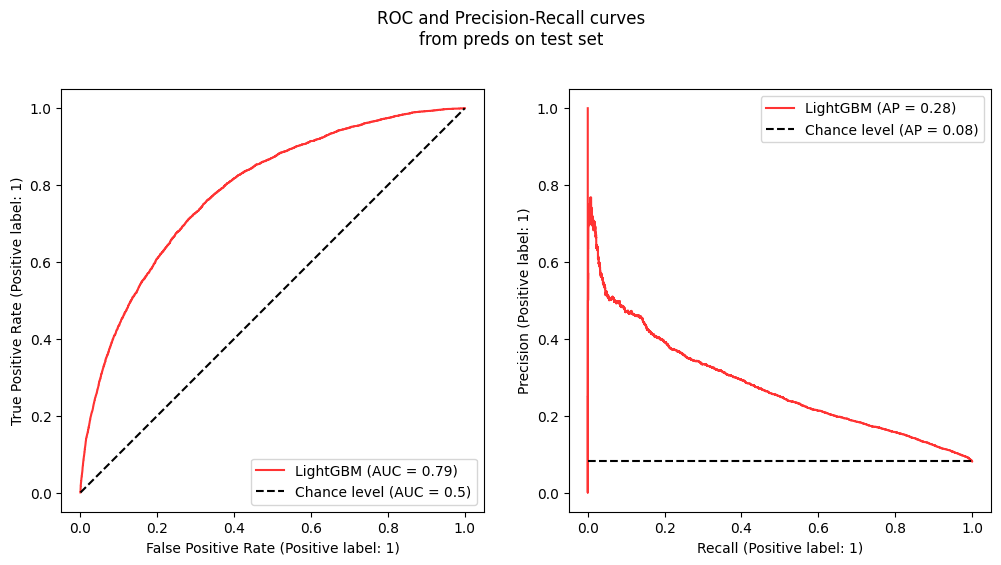

In [181]:
# then, plot ROC and PR curves :
mf.plotROCandPR(
    alreadyFittedModelsList=LBpipeTuned,
    namesList="LightGBM",
    Xtest=XTest,
    ytest=yTest,
    plot_chance_level=True,
    palette="r",
)

Notre `LBpipeTuned` atteint un résultat équivalent sur le jeu de test.

# MODELE CHOISI - et sans les features composites ?<a class="anchor" id="21"></a>

Essayons d'analyser l'impact des features composites et des agrégats sur le résultat :

In [182]:
## initiate a tab to store results
myFeaturesImpact = pd.DataFrame()
myFeaturesImpact.loc["with My and Agg features","LGBM Average Precision"] = \
average_precision_score(y_score=LBpipeTuned.predict_proba(XTest)[:,1],y_true=yTest) 

## considering just NEW and Lastxx features

notMyFeatures = [col for col in XTrain if col not in myFeatures]
# modify transformers 
columnTransformerWithoutMyFeatures = ColumnTransformer(
    [
        ("numericTransformer",numericTransformer,[c for c in numColsNames if c in notMyFeatures]),
        ("highCardiTransformer",highCardiTransformer,[c for c in newHighCardiColsNames if c  in notMyFeatures]),
        ("nomiTransformer",nomiTransformer,[c for c in remainingNomiColsNames if c in notMyFeatures]),
        ("ordiTransformer",ordiTransformer,[e[0] for e in [c for c in remainingOrdiColsNamesAndOrder if c in notMyFeatures]])
    ]
)
# copy original pipe
LBpipeTunedWithoutMyFeatures = clone(LBpipeTuned)
# set params
LBpipeTunedWithoutMyFeatures.set_params(**{"columnTransformer":columnTransformerWithoutMyFeatures})
# fit 
if not os.path.isdir("mySaves/models") :
    os.mkdir("mySaves/models")
if ("LBpipeTunedWithoutMyFeatures.joblib" not in os.listdir("mySaves/models")) or (rapidProcessing == False):
    LBpipeTunedWithoutMyFeatures.fit(XTrain[notMyFeatures],yTrain)
    dump(LBpipeTunedWithoutMyFeatures,"mySaves/models/LBpipeTunedWithoutMyFeatures.joblib")
else :
    LBpipeTunedWithoutMyFeatures=load("mySaves/models/LBpipeTunedWithoutMyFeatures.joblib")
# compute average precision
myFeaturesImpact.loc["without My features","LGBM Average Precision"] = \
average_precision_score(y_score=LBpipeTunedWithoutMyFeatures.predict_proba(XTest[notMyFeatures])[:,1],y_true=yTest) 


## considering NEW, Lastxx features AND all aggregated features

aggFeatures = [col for col in XTrain if (col.startswith(("BUR","PREV","CC","INS","POS"))) and (col not in myFeatures)]
allCustomFeatures = myFeatures + aggFeatures
initialFeatures = [col for col in XTrain if col not in allCustomFeatures]
# modify transformers 
columnTransformerWithoutMyandAggFeatures = ColumnTransformer(
    [
        ("numericTransformer",numericTransformer,[c for c in numColsNames if c in initialFeatures]),
        ("highCardiTransformer",highCardiTransformer,[c for c in newHighCardiColsNames if c  in initialFeatures]),
        ("nomiTransformer",nomiTransformer,[c for c in remainingNomiColsNames if c in initialFeatures]),
        ("ordiTransformer",ordiTransformer,[e[0] for e in [c for c in remainingOrdiColsNamesAndOrder if c in initialFeatures]])
    ]
)
# copy original pipe
LBpipeTunedWithoutMyandAggFeatures = clone(LBpipeTuned)
# set params
LBpipeTunedWithoutMyandAggFeatures.set_params(**{"columnTransformer":columnTransformerWithoutMyandAggFeatures})
# fit 
if not os.path.isdir("mySaves/models") :
    os.mkdir("mySaves/models")
if ("LBpipeTunedWithoutMyandAggFeatures.joblib" not in os.listdir("mySaves/models")) or (rapidProcessing == False):
    LBpipeTunedWithoutMyandAggFeatures.fit(XTrain[initialFeatures],yTrain)
    dump(LBpipeTunedWithoutMyandAggFeatures,"mySaves/models/LBpipeTunedWithoutMyandAggFeatures.joblib")
else :
    LBpipeTunedWithoutMyandAggFeatures=load("mySaves/models/LBpipeTunedWithoutMyandAggFeatures.joblib")
# compute average precision
myFeaturesImpact.loc["without My or Agg features","LGBM Average Precision"] = \
average_precision_score(y_score=LBpipeTunedWithoutMyandAggFeatures.predict_proba(XTest[initialFeatures])[:,1],y_true=yTest) 

## add a column - difference with initial score
myFeaturesImpact["diff%"] = \
(myFeaturesImpact["LGBM Average Precision"] -myFeaturesImpact.loc["with My and Agg features","LGBM Average Precision"]) \
/ myFeaturesImpact.loc["with My and Agg features","LGBM Average Precision"]
myFeaturesImpact["diff%"]=round(myFeaturesImpact["diff%"]*100,1).astype(str)+" %"

display(myFeaturesImpact)

,LGBM Average Precision,diff%
with My and Agg features,0.278420,0.0 %
without My features,0.265955,-4.5 %
without My or Agg features,0.247446,-11.1 %


L'utilisation des autre datasets a donc un impact positif sur l'average precision.

L'ajout des features composites (`NEW_xxx` et `Lastxx_xx`) également.

# MODELE CHOISI - sélectionner un seuil basé sur notre hypothèse business<a class="anchor" id="22"></a>

Nous allons utiliser notre hypothèse **cFN = 10 x cFP** pour déterminer le seuil de classification optimal pour notre problème. La méthode :
- convertir cette hypothèse en matrice de coût
- pour différents seuils :
    - calculer la matrice confusion du modèle
    - calculer le coût moyen par prédiction
- choisir le seuil avec le coût le plus faible

... le tout dans une fonction de `myFunction`

Nous en profiterons pour comparer les modèles précédemment rejetés au modèle sélectionné.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:    0.0s finished


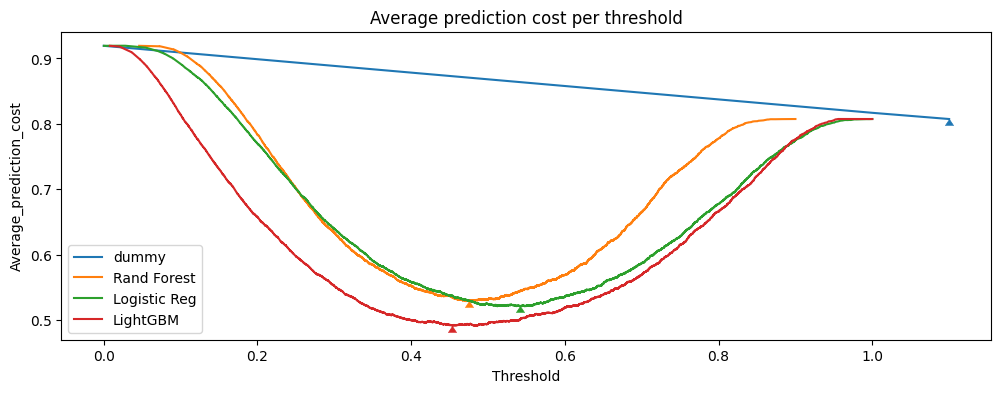

,model,threshold,cost
0,dummy,1.100000,0.807278
1,Rand Forest,0.475025,0.528608
2,Logistic Reg,0.541761,0.520723
3,LightGBM,0.453476,0.491082


le modèle avec le coût le plus faible est  LightGBM
CPU times: total: 1min 7s
Wall time: 1min 49s


In [183]:
%%time
# fit RFpipeTuned and LRpipeTuned on train set
if not os.path.isdir("mySaves/models") :
    os.mkdir("mySaves/models")
if ("RFpipeTuned.joblib" not in os.listdir("mySaves/models")) or (rapidProcessing == False):
    RFpipeTuned.fit(XTrain,yTrain)
    dump(RFpipeTuned,"mySaves/models/RFpipeTuned.joblib")
else :
    RFpipeTuned=load("mySaves/models/RFpipeTuned.joblib")

if ("LRpipeTuned.joblib" not in os.listdir("mySaves/models")) or (rapidProcessing == False):
    LRpipeTuned.fit(XTrain,yTrain)
    dump(LRpipeTuned,"mySaves/models/LRpipeTuned.joblib")
else :
    LRpipeTuned=load("mySaves/models/LRpipeTuned.joblib")

# build a cost matrix
# CTN  CFP
# CFN  CTP
PretADepenserCostMatrix=[
    [0 , 1],
    [10, 0]
] 

# use the getCostEffectiveClassifModelUsingTEST function
_,modelBestThreshold,_ =  \
mf.getCostEffectiveClassifModelUsingTEST(
    alreadyFittedModelsList=[dummy,RFpipeTuned,LRpipeTuned,LBpipeTuned],
    namesList=["dummy","Rand Forest","Logistic Reg","LightGBM"],
    X_test=XTest,
    y_test=yTest,
    costMatrix=PretADepenserCostMatrix,
    drop_intermediate=True,
    plot=True,
    palette=None)

Nous avons déterminé le **meilleur seuil** étant donnée notre **hypothèse de travail (cFN = 10 x cFP)**.

***Nota :*** *nous voyons également quel auraient pu être les seuils pour les autres modèles. A noter que `LBpipeTuned` est bien celui avec le coût le plus bas.*

# MODELE CHOISI - faire des prédictions<a class="anchor" id="23"></a>

Nous pouvons maintenant faire des prédictions sur notre set de test :

In [184]:
len(yTest)

61503

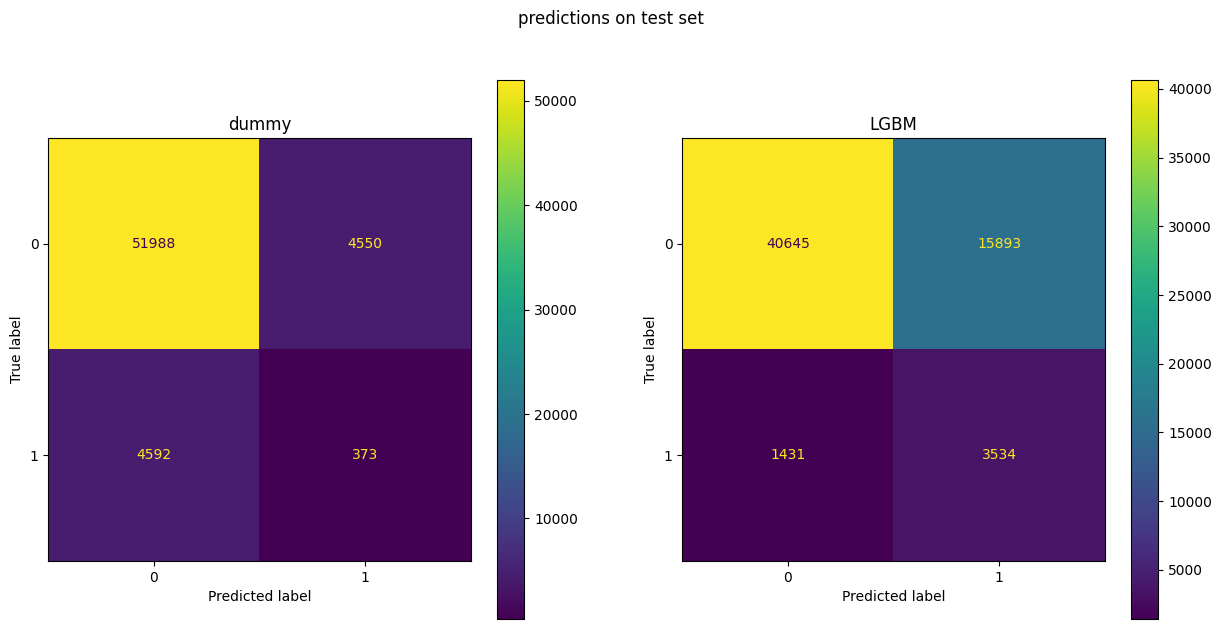

In [185]:
# model probabilities on test set
yProbsOnTest = LBpipeTuned.predict_proba(XTest)[:,1]
# model predictions
yPreds = np.where(yProbsOnTest >= modelBestThreshold,1,0)
errors = (yPreds != yTest.values)

# dummy
yPredsDummy = dummy.predict(XTest)

# plot confusion matrices
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ConfusionMatrixDisplay.from_predictions(y_true=yTest,y_pred=yPredsDummy,ax=ax1);
ConfusionMatrixDisplay.from_predictions(y_true=yTest,y_pred=yPreds,ax=ax2);
ax1.set_title("dummy")
ax2.set_title("LGBM")
fig.suptitle("predictions on test set");

On peut aussi calculer nos différentes métriques :
- le recall,
- la précision
- le coût moyen d'une prédiction (ici on utilise une fonction de `myFonction`)

In [186]:
# intiate a dataframe
metrics = pd.DataFrame()

# compute...
for name,pred in zip(["LGBM","Dummy"],[yPreds,yPredsDummy]) :
    metrics.loc["recall",name]=recall_score(y_true=yTest,y_pred=pred) # ... recall
    metrics.loc["precision",name]=precision_score(y_true=yTest,y_pred=pred,zero_division=np.nan) # ... precision
    metrics.loc["average prediction cost",name]=mf.meanCostPerPrediction( # ... average predicition cost
                                                    confusionMatrix=confusion_matrix(
                                                        y_true=yTest,
                                                        y_pred=pred
                                                    ),
                                                    costMatrix=PretADepenserCostMatrix
                                                )

display(metrics)

,LGBM,Dummy
recall,0.711782,0.075126
precision,0.181912,0.075767
average prediction cost,0.491082,0.820610


Nous voyons que le modèle n'est pas parfait, mais le nombre de faux négatifs est tout de même limité. Cela se fait au détriment du nombre de faux positifs, qui lui est assez important. 

Cependant cette précision globalement faible est à mettre en perspective avec le déséquilibre de classes important de notre problème. Le modèle apportera ainsi tout de même des alertes précieuses à la banque.

# MODELE CHOISI - expliquer nos prédictions<a class="anchor" id="24"></a>

## Préambule<a class="anchor" id="241"></a>

Nous allons utiliser SHAP pour expliquer nos prédictions.

Cet algorithme utilise des approximations des valeurs de Shapley et est une des méthodes d'explicabilité les plus utilisées.

Les valeurs de Shapley permettent de connaître la contribution de chaque feature à une prédiction donnée, ou plus exactement de savoir comment chaque feature fait différer une prédiction de la prédiction moyenne.

Pour obtenir cette contribution :
- on calcule la prédiction pour toutes les combinaisons possibles
- pour une feature donnée, on calcule sa contribution marginale pour chaque combinaison où elle apparaît en effectuant la soustraction entre la prédiction avec elle et la prédiction pour cette même combinaison, mais sans elle.
- on calcule enfin la moyenne pondérée de toutes ces contributions marginales.

Cette méthode permet d'obtenir des contributions "justes", car elle prend en compte les intéractions avec les autres features. Par exemple, si une feature de ne fonctionne bien qu'avec une autre feature en particulier, sa contribution marginale ne sera bonne qu'en présence de cette autre feature dans la combinaison. Cette bonne performance sera lissée par la moyenne.

Le problème des valeurs de Shapley est qu'elles nécessitent beaucoup de puissance de calcul. L'algorithme SHAP estime ces valeurs grâce à un noyau permettant de transformer ce problèmes en un problème de régression linéaire.

SHAP n'étant pas facilement compatible avec ImbLearn `Pipeline`, nous allons de tout d'abord "préprocesser" nos set d'entraînement et de test :

In [187]:
# preprocess Xtrain and XTest with already fitted LBpipeTuned
XTrainPreprocessed = pd.DataFrame(
    LBpipeTuned[:-1].transform(XTrain), # .transform with preprocessing steps of the pipeline
    columns=extract_features_from_pipe(LBpipeTuned)[0] # use custom function to get features names
)
XTestPreprocessed = pd.DataFrame(
    LBpipeTuned[:-1].transform(XTest), # .transform with preprocessing steps of the pipeline
    columns=extract_features_from_pipe(LBpipeTuned)[0] # use custom function to get features names
)

Nous pouvons maintenant créer un SHAP `Explainer` :

In [188]:
lgbmExplainer = shap.TreeExplainer(LBpipeTuned[-1],data=XTrainPreprocessed.sample(10000),model_output="probability")

Et générer notre objet `Explanation` :

*Nota :* Cette opération étant très longue, nous allons le stocker.

In [189]:
%%time
if not os.path.isdir("mySaves/shapValues") :
    os.mkdir("mySaves/shapValues")

if ("lgbmShapValues.joblib" not in os.listdir("mySaves/shapValues")) or (rapidProcessing == False) :
    lgbmShapValues = lgbmExplainer(XTestPreprocessed,check_additivity=False)
    dump(lgbmShapValues,"mySaves/shapValues/lgbmShapValues.joblib")

else :
    lgbmShapValues=load("mySaves/shapValues/lgbmShapValues.joblib")

CPU times: total: 0 ns
Wall time: 140 ms


Nous pouvons comparer les probabilités de sortie réelle de notre algorithme avec la somme des Shapley values (sommes sur les différentes features) issues de l'Explainer :

In [190]:
yProbsOnTest = LBpipeTuned.predict_proba(XTest)[:,1]
yProbsWithShap = lgbmShapValues.values.sum(axis=1) + lgbmExplainer.expected_value

(yProbsOnTest-yProbsWithShap).std()

0.0003044330699605207

Les probabilités/scores sont très proches.

SHAP nous permettant d'interpréter notre modèles aussi bien au niveau global que local, nous allons extraire quelques observations.

L'idée est d'avoir quelques observations pour chaque type de prédiction (TN, FP, FN et TP).

In [191]:
testResults = pd.DataFrame()
testResults["yTest"]=yTest.values
testResults["yPred"]=yPreds

TNidx = testResults.loc[(testResults["yTest"]==0)&(testResults["yPred"]==0)].index
FPidx = testResults.loc[(testResults["yTest"]==0)&(testResults["yPred"]==1)].index
FNidx = testResults.loc[(testResults["yTest"]==1)&(testResults["yPred"]==0)].index
TPidx = testResults.loc[(testResults["yTest"]==1)&(testResults["yPred"]==1)].index

rand_ste = 16
nb_samp = 3
# initiate an list of index for our sample 
sampleIdx=[]

for idx in [TNidx,FPidx,FNidx,TPidx] :
    np.random.seed(rand_ste)
    sampleIdx += np.random.choice(
        idx,
        size=nb_samp,
        replace=False
    ).tolist()

lgbmShapValuesSamples=lgbmShapValues[sampleIdx]
sampleInfos=[elt for elt in ['TN', 'FP', 'FN', 'TP'] for i in range(nb_samp)]
errorsSample=errors[sampleIdx]

## `shap.plots.bar`<a class="anchor" id="242"></a>

Nous pouvons afficher un barplot avec l'importance de chaque variable :

In [192]:
# use widgets to select different options

widTop = widgets.BoundedIntText(# number of features to display
    value=20,
    min=0,
    max=len(lgbmExplainer.data_feature_names),
    description="N top features : ",
    disabled=False,
    style={'description_width': 'initial'}
)

widSample = widgets.Dropdown(# select sample(s)
    options={"all test set" : "allTest"}\
    |{"all samples":"allSamps"}\
    |{"sample "+str(i+1)+" ("+sampleInfos[i]+")" : i for i in range(len(lgbmShapValuesSamples))},
    description = "Which observation(s) : ",
    style={'description_width': 'initial'}
)

ui = widgets.VBox([widSample,widTop])

def boldFeatures(axes) :
    '''
    for features in myFeatures, set fontweight to "bold"
    parameter :
    -----------
    axes : matplotlib axes
    '''
    ytickslabels=axes.get_yticklabels(which='both') # 'both' becaux SHAP uses two layers, one grey, one black
    fontWeights=["bold" if ytick.get_text().split(" ")[-1] in myFeatures else "normal" for ytick in ytickslabels]
    # apply fontweights
    for ytick,fontWeight in zip(ytickslabels,fontWeights) :
        ytick.set_fontweight(fontWeight)

def myShapBarPlot(sample,top) :
    '''
    custom SHAP barplot
    parameters :
    ------------
    sample - str or int : sample(s) we ant to explain
    top - int : number of feature to display
    '''
    fig,ax=plt.subplots(1,figsize=[10,top*0.5])
    if sample=="allTest" :
        shap.plots.bar(lgbmShapValues,max_display=top,show=False)
        ax.set_title("SHAP feature importance bar plot\nGlobal - on test set")
    elif sample=="allSamps" :
        shap.plots.bar(lgbmShapValuesSamples,max_display=top,show=False)
        ax.set_title("SHAP feature importance bar plot\nGlobal - on the "+str(nb_samp)+" test set samples")
    else :
        shap.plots.bar(lgbmShapValuesSamples[sample],max_display=top,show=False)
        ax.set_title("SHAP feature importance bar plot\nLocal - on sample "+str(sample+1))
    
    # adjust fontweights
    boldFeatures(ax)
    
    plt.show()

out = widgets.interactive_output(myShapBarPlot,{"sample":widSample,"top":widTop})

display(ui,out)

Output()

Quelques features composites ressortent, comme la feature synthétisant les `xx_NOT_xx`s, nous informant sur les distances entres les différentes adresses renseignées au dossier. 

Des features `EXT_SOURCE` ressortent également, ainsi que certaines liées au taux du crédit (`NEW_I_x_DOWN` et `PREV_NAME_YIELD_GROUP_AggMin`). 

Globalement nous retrouvons des features révélées lors de l'exploration.

## `shap.decision_plot`<a class="anchor" id="243"></a>

In [193]:
sampSize = len(lgbmShapValuesSamples)

widSampleBis = widgets.Dropdown(# select sample(s)
    options={"all samples":list(range(sampSize))}\
    |{"sample "+str(i+1)+" ("+sampleInfos[i]+")" : i for i in range(sampSize)},
    description = "Which observation(s) : ",
    style={'description_width': 'initial'}
)
widTopBis=widgets.BoundedIntText(# number of features to display
    value=20,
    min=0,
    max=len(lgbmExplainer.data_feature_names),
    description="N top features : ",
    disabled=False,
    style={'description_width': 'initial'}
)

uiBis = widgets.VBox([widSampleBis,widTopBis])

def myShapDecisionPlot(sample,top) :
    '''
    custom SHAP decision plot
    parameters :
    ------------
    sample - str or int : sample(s) we ant to explain
    top - int : number of feature to display
    '''
    fig,ax=plt.subplots(1,figsize=[10,top*0.5])
    shap.decision_plot(
        base_value=lgbmShapValuesSamples.base_values[0],
        shap_values=lgbmShapValuesSamples.values[sample],
        features=lgbmShapValuesSamples.data[sample],
        feature_names=lgbmShapValuesSamples.feature_names,
        feature_display_range=slice(-1, -top, -1),
        xlim=[0,1],
        show=False,
        highlight=errorsSample[sample],
        auto_size_plot=False
    )
    ax.set_title("SHAP decision plot\n(how the model makes decisions)")

    
    # adjust fontweights
    boldFeatures(ax)
    # add a vertical line with threshold
    ax.axvline(x=modelBestThreshold,lw=3,ls=":",c="k")
    plt.show()
    
outBis = widgets.interactive_output(myShapDecisionPlot,{"sample":widSampleBis,"top":widTopBis})

display(uiBis,outBis)


Output()

Nous voyons l'intérêt de l'aspect local de `SHAP` et tout particulièrement du `decision plot` : En apprendre plus sur la manière dont le modèle arrive au score final aidera grandement les chargés de relation client à :
- déceler des incohérences
- savoir quelles parties du dossier d'un client peut être à explorer

## `shap.plots.waterfall`<a class="anchor" id="244"></a>

`SHAP` propose également le graphique `waterfall`, qui apporte les même informations locales que le précédent :

In [194]:
widSampleTER = widgets.Dropdown(# select sample
    options={"sample "+str(i+1)+" ("+sampleInfos[i]+")" : i for i in range(sampSize)},
    description = "Which observation : ",
    style={'description_width': 'initial'}
)
widTopTER=widgets.BoundedIntText(# number of features to display
    value=20,
    min=0,
    max=len(lgbmExplainer.data_feature_names),
    description="N top features : ",
    disabled=False,
    style={'description_width': 'initial'}
)
uiTER = widgets.VBox([widSampleTER,widTopTER])

def myWaterfall(sample,top) :
    '''
    custom SHAP waterfall plot
    parameters :
    ------------
    sample - str or int : sample(s) we ant to explain
    top - int : number of feature to display
    '''
    fig,ax=plt.subplots(1,figsize=[10,top*0.5])
    shap.plots.waterfall(lgbmShapValuesSamples[sample],max_display=top,show=False)
    # adjust fontweights
    boldFeatures(ax)
    plt.show()
    
out=widgets.interactive_output(myWaterfall,{"sample":widSampleTER,"top":widTopTER})

display(uiTER,out)

# shap.plots.waterfall(lgbmShapValuesSamples[-5])

Output()

# CONCLUSION

Nous voyons qu'un modèle **ne peut pas être parfait**, même s'il est toujours possible d'apporter des améliorations. Cet outil de scoring peut effectivement apporter beaucoup à la banque :
- **gain de temps**
- **aide à la décision**

Les chargés de relation client et l'outil s'**apporteront mutuellement** grâce à l'**interprétabilité** du modèle :
- **regard critique** sur le résultat pour un client donné
- **mise en exergue** des éléments du dossier **susceptibles de poser problème**, pour analyse plus poussée par exemple

Sur le plan des améliorations possibles :
- Nous avons vu que `SMOTE` a toujours été surpassé par `classweights`. Nous pensons qu'avec plus de temps de développement et calcul il serait **possible de l'améliorer** :
    - utiliser **SMOTENC** pour éviter mieux traiter les variables **catégorielles**
    - cela nécessiterait de modifier le preprocessing, la feature selection
    - LightGBM est capable de traiter les variable catégorielles directement donc cela ne poserait pas de problème
- Remplacer le RandomUnderSampling par un algorithme plus habile comme l'**`EditedNearestNeighbors`**
- Gérer **plus finement les imputations** :
    - features numériques : `IterativeImputer` ? `KNNImputer` ?
    - features catégorielles : Imputer basé sur un `KNNClassifier` ?
    - features intéressantes (ex : `EXT_SOURCE`) : développer un modèle ?
- Gérer **plus finement les outliers** :
    - `FunctionSampler(func = IsolationForest)` ?
- D'**autres features composites** ? Exemple :

<img src="idee_feature.png" alt="idee_feature" width="1000"/>

In [195]:
end_time = time.time()
execution_time = (end_time - start_time)/60
execution_time

5.659461792310079